In [25]:
import pandas as pd
import os
import statsmodels.stats.multitest as multi
import numpy as np

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [27]:
from scipy.stats import mannwhitneyu
import statsmodels.formula.api as smf
import statsmodels.api as sm
import qnorm
from scipy.stats import mannwhitneyu
from scipy import stats
from sklearn import preprocessing

### Get UKBB risk variants

In [28]:
import json
with open('/cellar/users/mpagadal/resources/tcga/ensembl_map.json', 'r') as f:
    ensembl = json.load(f)
ensembl={k.split(".")[0]:v for k,v in ensembl.items()}

In [29]:
def make_ukbb_prs(raw,sumstats,snps):
    
    print("{} PRS snps".format(len(snps)))
    
    #compile raw files
    compiled_raw=pd.read_csv(raw,delim_whitespace=True)
    
    #keep snps in list
    keep_snps=[]
    
    for x in snps:
        try:
            keep_snps.append([s for s in compiled_raw.columns if x in s][0])
        except:
            try:
                keep_snps.append([s for s in compiled_raw.columns if x.rsplit(":",2)[0]+":"+x.split(":")[3]+":"+x.split(":")[2] in s][0])
            except:
                pass
    
    compiled_raw=compiled_raw[["IID"]+keep_snps]
    #print("loading {} snps".format(len([x for x in compiled_raw.columns if ":" in x])))
    #print([x for x in compiled_raw.columns if ":" in x])
    
    #format raw files
    compiled_raw=compiled_raw.set_index("IID")
    compiled_raw=compiled_raw.T
    compiled_raw["min_allele"]=compiled_raw.index.str.split("_").str[-1]
    
    #remove duplicates
    compiled_raw["snp"]=compiled_raw.index.str.split("_").str[0]
    compiled_raw=compiled_raw[~compiled_raw["snp"].duplicated()]
    del compiled_raw["snp"]
    
    compiled_raw.index=compiled_raw.index.str.rsplit(":",2).str[0]
    
    #reformat summary
    summary_merge=sumstats[["ID","A1","OR"]].copy()
    summary_merge=summary_merge.drop_duplicates(subset="ID",keep="first")
    summary_merge=summary_merge.set_index("ID")
    summary_merge.index=summary_merge.index.str.rsplit(":",2).str[0]
    
    #annotate the genotypes
    compiled_raw=pd.merge(compiled_raw,summary_merge, left_index=True,right_index=True,how="left")
    print("{} snps missing weight".format(len(compiled_raw[compiled_raw["OR"].isnull()])))
    
    compiled_raw["logOR"]=np.log2(compiled_raw["OR"])
    del compiled_raw["OR"]
    compiled_raw=compiled_raw[~compiled_raw["logOR"].isnull()] #remove null weights
    compiled_raw["logOR"]=np.where(compiled_raw["min_allele"]!=compiled_raw["A1"],compiled_raw["logOR"]*-1,compiled_raw["logOR"]) #orient the odds ratio
    print("switching {} genotypes".format(len(compiled_raw[compiled_raw["min_allele"]!=compiled_raw["A1"]]))) #number of mismatched genotypes

    del compiled_raw["min_allele"]
    del compiled_raw["A1"]

    #get beta values
    mp_beta=dict(zip(compiled_raw.index,compiled_raw["logOR"]))
    compiled_raw_switch=compiled_raw.iloc[:,:-1].T
    
    #align to all positive snps
    switch_snps=[k for k,v in mp_beta.items() if v < 0]
    
    compiled_raw_switch=compiled_raw_switch.fillna(0)
    
    for x in switch_snps:
        compiled_raw_switch[x]=2-compiled_raw_switch[x]
        
    compiled_raw_switch=compiled_raw_switch.T
    compiled_raw_switch["beta"]=compiled_raw_switch.index.map(mp_beta)
    compiled_raw_switch["beta"]=abs(compiled_raw_switch["beta"])
    compiled_raw_switch=compiled_raw_switch.astype(float)
    
    #compile weighted genotypes
    
    #FOR TJ TOMORROW, WIEGHT THE SNPS USING THE LOG ORS
    compiled_raw_switch_out=compiled_raw_switch.iloc[:,:-1].mul(compiled_raw_switch["beta"],axis=0)
    
    raw_prs=compiled_raw_switch.iloc[:,:-1].mul(compiled_raw_switch["beta"],axis=0).sum(axis=0).reset_index()
    raw_prs.columns=["IID","PRS"]
    
    return(raw_prs,compiled_raw_switch_out)

In [30]:
def quantile_plot(df,form,num,lin_log):
    '''
    df: dataframe with PRS and pheno/cov in form
    prs: prs column
    form: formula for analysis
    num: number of quantiles
    '''
    
    if lin_log == "logistic":
        
        quant=[]
        odds=[]
        se=[]

        for i in range(num):
            quant.append(str((100/num)*i))
    
            #make groupings for logistic regression
            
            cases=df[(df["PRS"]>df["PRS"].quantile((1/num)*i))&(df["PRS"]<df["PRS"].quantile((1/num)*(i+1)))]["FID"].tolist()
            
            controls=df[(df["PRS"]>df["PRS"].quantile(int(num/2)*(1/num)))&(df["PRS"]<df["PRS"].quantile(int(num/2)*(1/num)+(1/(num))))]["FID"].tolist()
    
            df_filt=df[df["FID"].isin(cases+controls)]
            #df_filt=df[df["FID"].isin(cases)]

            df_filt["group"]=np.where(df_filt["FID"].isin(cases),1,0)
            print(df_filt["group"].value_counts())
            
            if i != int(num/2):
                model=smf.logit(form,data=df_filt,method='bfgs').fit()
                odds.append(np.exp(model.params.tolist()[1]))
                se.append(model.bse.tolist()[1])
            else:
                odds.append(1)
                se.append(0)
                
        df_odds=pd.DataFrame({"quant":quant,"odds":odds,"se":se})
        return(df_odds)

In [31]:
snps=pd.read_csv("/cellar/users/mpagadal/projects/germline-immune/data/supplemental/Supplemental_Table_3.csv",delimiter="\t")
snps["snp_noallele"]=snps["proxy_variant"].str.rsplit(":",2).str[0]
mp_variant=dict(zip(snps["proxy_snp"],snps["proxy_variant"]))

In [32]:
len([x.replace("-",".") for x in snps["file"].unique().tolist()])

129

In [33]:
ukbb=pd.read_csv("/cellar/users/mpagadal/projects/germline-immune/data/supplemental/Supplemental_Table_5.csv")

In [34]:
len(ukbb[ukbb["Outcome"].str.startswith("C")]["Outcome"].value_counts())

15

In [35]:
fdr_thresh=0.05

In [36]:
ukbb_sig=ukbb[ukbb["Overall_Pval"]<fdr_thresh]
ukbb_sig=ukbb_sig[ukbb_sig["Outcome"].str.startswith("C")]
ukbb_annot=pd.merge(ukbb_sig, snps, on="proxy_variant", how="left")
pheno_group=pd.read_csv("/cellar/users/mpagadal/projects/germline-immune/data/networkx/networkx.group.csv")
pheno_group["nodes"]=pheno_group["nodes"].str.replace(".","-")
mp_group=dict(zip(pheno_group["nodes"],pheno_group["group"]))
ukbb_annot["group"]=ukbb_annot["file"].map(mp_group)
ukbb_sig["proxy_variant"]=ukbb_sig["Var1_ID"].map(mp_variant).fillna(ukbb_sig["Var1_ID"])

#annotate dataframe
ukbb_sig_snps=ukbb_sig["proxy_variant"].tolist()+[x.rsplit(":",2)[0]+":"+x.split(":")[3]+":"+x.split(":")[2] for x in ukbb_sig["proxy_variant"].tolist()]
snps["ukbb"]=np.where(snps["proxy_variant"].isin(ukbb_sig_snps),"ukbb","no")

/cm/shared/apps/jupyter/12.3.0/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  """


In [37]:
print("{} UKBB associations from {} IP components".format(len(snps[snps["ukbb"]=="ukbb"]["proxy_variant"].unique()),len(snps[snps["ukbb"]=="ukbb"]["file"].unique())))

619 UKBB associations from 112 IP components


In [38]:
len(ukbb_annot[(ukbb_annot["file"]=="Sigs160-Wolf_MHC2-21978456")|(ukbb_annot["group"]=="group1")]["Var1_ID"].unique())

353

In [39]:
#get significant UKBB associations 
    #filter for cancer associations: Outcome ICD10 codes - C
    #Adjusted for pval instead of FDR thresh
    
ukbb_sig=ukbb[ukbb["Overall_Pval"]<fdr_thresh]
ukbb_sig=ukbb_sig[ukbb_sig["Outcome"].str.startswith("C")]
ukbb_sig["proxy_variant"]=ukbb_sig["Var1_ID"].map(mp_variant).fillna(ukbb_sig["Var1_ID"])

#annotate dataframe
ukbb_sig_snps=ukbb_sig["proxy_variant"].tolist()+[x.rsplit(":",2)[0]+":"+x.split(":")[3]+":"+x.split(":")[2] for x in ukbb_sig["proxy_variant"].tolist()]
snps["ukbb"]=np.where(snps["proxy_variant"].isin(ukbb_sig_snps),"ukbb","no")



In [40]:
print("{} UKBB associations from {} IP components".format(len(snps[snps["ukbb"]=="ukbb"]),len(snps[snps["ukbb"]=="ukbb"]["file"].unique())))

660 UKBB associations from 112 IP components


In [41]:
ukbb_annot=pd.merge(ukbb_sig, snps, on="proxy_variant", how="left")
ukbb_annot["ukbb_a1"]=ukbb_annot["Var1_MAF"].str.split(":").str[0]
ukbb_annot["beta_match"]=np.where(ukbb_annot['ukbb_a1']!=ukbb_annot["A1"],ukbb_annot["beta"]*-1,ukbb_annot["beta"])
ukbb_annot["logOR"]=np.log10(ukbb_annot["Var1_OR"])
ukbb_annot["ref"]=ukbb_annot["proxy_variant"].str.split(":").str[2]

In [42]:
pheno_group=pd.read_csv("/cellar/users/mpagadal/projects/germline-immune/data/networkx/networkx.group.csv")
pheno_group["nodes"]=pheno_group["nodes"].str.replace(".","-")
mp_group=dict(zip(pheno_group["nodes"],pheno_group["group"]))

/cm/shared/apps/jupyter/12.3.0/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  


In [43]:
ukbb_annot["group"]=ukbb_annot["file"].map(mp_group)

#### group1 PRS

In [45]:
group1_sumstats=ukbb_annot[ukbb_annot["group"]=="group1"][["proxy_variant","ukbb_a1","Var1_OR","Outcome"]]
group1_sumstats=group1_sumstats[np.logical_or(group1_sumstats["Outcome"]=="C43-C44",group1_sumstats["Outcome"]=="C60-C63")] #
group1_sumstats.columns=["ID","A1","OR","Outcome"]

In [46]:
ukbb_annot

,Unnamed: 0,Outcome,Var1_ID,Var1_Pos,Var1_MAF,Num_Missing,Analysis_Type,Converged,Var1_Pval,Var1_OR,...,found,proxy_snp,chr,cis tss,ukbb,ukbb_a1,beta_match,logOR,ref,group
0,1,C45-C49,rs56252769,11:65718633,T:0.731893,113151,logistic,1,8.579050e-03,0.865384,...,found,rs56252769,11,-71350.0,ukbb,T,0.239914,-0.062791,T,group1
1,2,C30-C39,rs56252769,11:65718633,T:0.731893,113151,logistic,1,9.891960e-03,1.082210,...,found,rs56252769,11,-71350.0,ukbb,T,0.239914,0.034312,T,group1
2,2,C43-C44,11:65477306:A:C,11:65477306,A:0.523835,105518,logistic,1,4.234990e-02,1.024740,...,found,rs12787843,11,169977.0,ukbb,A,-0.101507,0.010614,A,group1
3,0,C43-C44,rs4785702,16:89733206,G:0.890151,105329,logistic,1,7.512590e-40,0.786236,...,found,rs4785702,16,338072.0,ukbb,G,-0.250181,-0.104447,G,group2
4,1,C15-C26,rs4785702,16:89733206,G:0.890151,105329,logistic,1,7.971590e-03,1.076180,...,found,rs4785702,16,338072.0,ukbb,G,-0.250181,0.031885,G,group2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1087,1,C69-C72,rs13183802,5:79635332,A:0.686152,110070,logistic,1,3.552620e-02,0.893094,...,found,rs13183802,5,286712.0,ukbb,A,0.107530,-0.049103,A,group2
1088,0,C64-C68,rs62376449,5:96202273,G:0.895913,105372,logistic,1,2.556620e-02,1.096060,...,found,rs62376449,5,-92086.0,ukbb,G,0.253384,0.039834,G,group1
1089,2,C81-C96,rs62376449,5:96202273,G:0.895913,105372,logistic,1,4.581120e-02,1.079870,...,found,rs62376449,5,-92086.0,ukbb,G,0.253384,0.033371,G,group1
1090,8,C81-C96,rs7754768,6:32420179,T:0.597129,105537,logistic,1,2.223960e-02,0.948427,...,found,rs7754768,6,NaN,ukbb,T,-0.093750,-0.022996,T,NaN


In [43]:
print("{} phenotypes implicated in PRS".format(",".join(ukbb_annot[(ukbb_annot["group"]=="group1")&(ukbb_annot["Outcome"]=="C43-C44")]["file"].unique())))

CTSW,FCGR3B,CTSS,ERAP1,ERAP2,LYZ,HLA-DQA2,MNDA,HLA-DQA1,HLA-DRB1,HLA-C,MICB,HLA-G,HLA-DQB2,OAS1,TAP2,HLA-DRB5,HLA-DQB1,IL2RA,HLA-H,FPR1,HLA-A,HLA-B phenotypes implicated in PRS


In [44]:
group1_prs,test_ukbb_res=make_ukbb_prs("/cellar/users/mpagadal/projects/germline-immune/data/ukbb/time-snp/dosage-multi/ukbb_bialleleic.raw",group1_sumstats,group1_sumstats["ID"].tolist())
icd=pd.read_csv("/cellar/users/mpagadal/data/ukbb/plato_input/immune_cancer_lev1_pheno.txt",delim_whitespace=True)
group1_prs=pd.merge(group1_prs,icd,on="IID",how="left")


158 PRS snps
0 snps missing weight
switching 128 genotypes


In [45]:
#need to transpose SNP table

Text(0.5, 0, 'PRS')

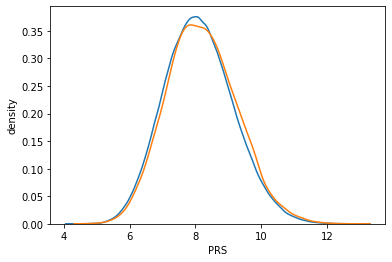

In [46]:
sns.kdeplot(group1_prs[group1_prs["C43-C44"]==0]["PRS"],label="controls")
sns.kdeplot(group1_prs[group1_prs["C43-C44"]==1]["PRS"],label="cases")
plt.ylabel("density")
plt.xlabel("PRS")

In [47]:
cat1 = group1_prs[group1_prs["C43-C44"]==0]
cat2 = group1_prs[group1_prs["C43-C44"]==1]
mannwhitneyu(cat1["PRS"], cat2["PRS"])[1]

9.193457481966835e-24

In [48]:
group1_prs["melanoma"]=group1_prs["C43-C44"]
group1_odds=quantile_plot(group1_prs,"melanoma ~ group + AGE + SEX + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10",10,"logistic")

/cm/shared/apps/jupyter/12.3.0/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/.local/lib/python3.7/site-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['method']
  warnings.warn(msg, ValueWarning)


1    144796
0     38952
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.145063
         Iterations 8
1    144163
0     38952
Name: group, dtype: int64


/cm/shared/apps/jupyter/12.3.0/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/.local/lib/python3.7/site-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['method']
  warnings.warn(msg, ValueWarning)


Optimization terminated successfully.
         Current function value: 0.149523
         Iterations 8


/cm/shared/apps/jupyter/12.3.0/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/.local/lib/python3.7/site-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['method']
  warnings.warn(msg, ValueWarning)


1    144060
0     38952
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.151365
         Iterations 8
1    143642
0     38952
Name: group, dtype: int64


/cm/shared/apps/jupyter/12.3.0/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/.local/lib/python3.7/site-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['method']
  warnings.warn(msg, ValueWarning)


Optimization terminated successfully.
         Current function value: 0.154279
         Iterations 8
1    143672
0     38952
Name: group, dtype: int64


/cm/shared/apps/jupyter/12.3.0/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/.local/lib/python3.7/site-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['method']
  warnings.warn(msg, ValueWarning)


Optimization terminated successfully.
         Current function value: 0.151821
         Iterations 8
1    143522
Name: group, dtype: int64


/cm/shared/apps/jupyter/12.3.0/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1    143573
0     38952
Name: group, dtype: int64


/cellar/users/tsears/.local/lib/python3.7/site-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['method']
  warnings.warn(msg, ValueWarning)


Optimization terminated successfully.
         Current function value: 0.154011
         Iterations 8
1    143643
0     38952
Name: group, dtype: int64


/cm/shared/apps/jupyter/12.3.0/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/.local/lib/python3.7/site-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['method']
  warnings.warn(msg, ValueWarning)


Optimization terminated successfully.
         Current function value: 0.156317
         Iterations 8
1    143694
0     38952
Name: group, dtype: int64


/cm/shared/apps/jupyter/12.3.0/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/.local/lib/python3.7/site-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['method']
  warnings.warn(msg, ValueWarning)


Optimization terminated successfully.
         Current function value: 0.160174
         Iterations 8
1    144967
0     38952
Name: group, dtype: int64


/cm/shared/apps/jupyter/12.3.0/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/.local/lib/python3.7/site-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['method']
  warnings.warn(msg, ValueWarning)


Optimization terminated successfully.
         Current function value: 0.163967
         Iterations 8


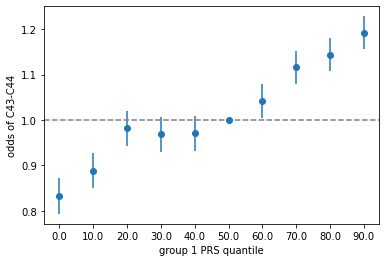

In [33]:
plt.errorbar(x=group1_odds["quant"].tolist(),y=group1_odds["odds"].tolist(),yerr=group1_odds["se"].tolist(),fmt="o")
plt.xlabel("group 1 PRS quantile")
plt.ylabel("odds of C43-C44")
plt.axhline(1,linestyle="--",color="gray")
plt.savefig("/cellar/users/tsears/projects/germline-immune/plots/fig5/group1.melanoma.ukbb.prs.quantile.pdf")

#### MHC II signature

In [34]:
mhcII_sumstats=ukbb_annot[ukbb_annot["file"]=="Sigs160-Wolf_MHC2-21978456"][["proxy_variant","ukbb_a1","Var1_OR","Outcome"]]
mhcII_sumstats=mhcII_sumstats[mhcII_sumstats["Outcome"]=="C43-C44"]
mhcII_sumstats.columns=["ID","A1","OR","Outcome"]

In [35]:
mhcII_prs=make_ukbb_prs("/cellar/users/mpagadal/projects/germline-immune/data/ukbb/time-snp/dosage-multi/ukbb_bialleleic.raw",mhcII_sumstats,mhcII_sumstats["ID"].tolist())
icd=pd.read_csv("/cellar/users/mpagadal/data/ukbb/plato_input/immune_cancer_lev1_pheno.txt",delim_whitespace=True)
mhcII_prs=pd.merge(mhcII_prs,icd,on="IID",how="left")

13 PRS snps
loading 13 snps
['6:32586908:A:G_G', '6:32634405:T:C_C', '6:32692735:T:A_A', '6:32602396:T:C_C', '6:32575658:G:C_C', '6:32683121:A:G_G', '6:32389255:A:C_C', '6:32612397:G:A_A', '6:32592796:C:T_T', '6:32582194:C:T_T', '6:32584625:G:A_A', '6:32581582:G:C_C', '6:32583274:G:T_T']
0 snps missing weight
switching 13 genotypes


Text(0.5, 0, 'PRS')

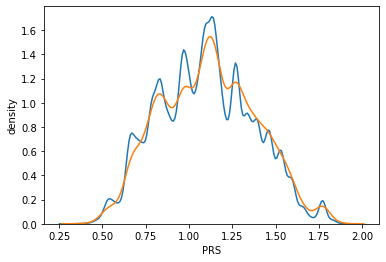

In [36]:
sns.kdeplot(mhcII_prs[mhcII_prs["C43-C44"]==0]["PRS"],label="controls")
sns.kdeplot(mhcII_prs[mhcII_prs["C43-C44"]==1]["PRS"],label="cases")
plt.ylabel("density")
plt.xlabel("PRS")

In [37]:
cat1 = mhcII_prs[mhcII_prs["C43-C44"]==0]
cat2 = mhcII_prs[mhcII_prs["C43-C44"]==1]
mannwhitneyu(cat1["PRS"], cat2["PRS"])[1]

1.7861255457978958e-14

In [38]:
mhcII_prs["melanoma"]=mhcII_prs["C43-C44"]
mhcII_odds=quantile_plot(mhcII_prs,"melanoma ~ group + AGE + SEX + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10",10,"logistic")

/cm/shared/apps/jupyter/12.3.0/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1    145295
0     98145
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.149096
         Iterations 8


/cm/shared/apps/jupyter/12.3.0/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1    144262
0     98145
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.153378
         Iterations 8


/cm/shared/apps/jupyter/12.3.0/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1    142965
0     98145
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.152381
         Iterations 8


/cm/shared/apps/jupyter/12.3.0/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1    141986
0     98145
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.150085
         Iterations 8


/cm/shared/apps/jupyter/12.3.0/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1    134254
0     98145
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.150760
         Iterations 8


/cm/shared/apps/jupyter/12.3.0/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1    141075
0     74166
Name: group, dtype: int64
1    142468
0     76824
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.154349
         Iterations 8


/cm/shared/apps/jupyter/12.3.0/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1    142989
0     80829
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.155369
         Iterations 8


/cm/shared/apps/jupyter/12.3.0/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1    142964
0     79561
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.155538
         Iterations 8


/cm/shared/apps/jupyter/12.3.0/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1    144529
0     82663
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.155820
         Iterations 8


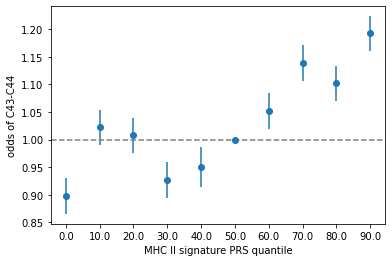

In [39]:
plt.errorbar(x=mhcII_odds["quant"].tolist(),y=mhcII_odds["odds"].tolist(),yerr=mhcII_odds["se"].tolist(),fmt="o")
plt.xlabel("MHC II signature PRS quantile")
plt.ylabel("odds of C43-C44")
plt.axhline(1,linestyle="--",color="gray")
plt.savefig("/cellar/users/tsears/projects/germline-immune/plots/fig5/mhcII.sig.melanoma.ukbb.prs.quantile.pdf")

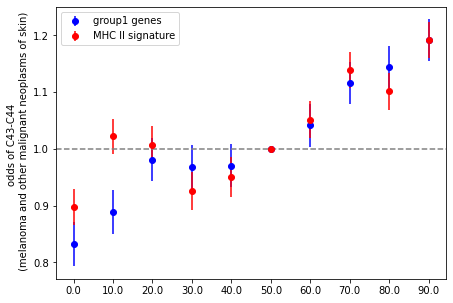

In [40]:
f=plt.figure(figsize=(7,5))
plt.errorbar(x=group1_odds["quant"].tolist(),y=group1_odds["odds"].tolist(),yerr=group1_odds["se"].tolist(),fmt="o",color="blue",label="group1 genes")
plt.errorbar(x=mhcII_odds["quant"].tolist(),y=mhcII_odds["odds"].tolist(),yerr=mhcII_odds["se"].tolist(),fmt="o",color="red",label="MHC II signature")
plt.ylabel("quantile")
plt.ylabel("odds of C43-C44 \n (melanoma and other malignant neoplasms of skin)")
plt.axhline(1,linestyle="--",color="gray")
plt.legend()
plt.savefig("/cellar/users/tsears/projects/germline-immune/plots/fig5/mhcI.II.ukbb.quantile.pdf")

### UKBB with combined MHC+group1 SNPs, Melanoma training and validation ONLY

In [2903]:
group1_sumstats=ukbb_annot[ukbb_annot["group"]=="group1"][["proxy_variant","ukbb_a1","Var1_OR","Outcome"]]
group1_sumstats=group1_sumstats[np.logical_or(group1_sumstats["Outcome"]=="C43-C44",group1_sumstats["Outcome"]=="C60-C63")] #
group1_sumstats.columns=["ID","A1","OR","Outcome"]

mhcII_sumstats=ukbb_annot[ukbb_annot["file"]=="Sigs160-Wolf_MHC2-21978456"][["proxy_variant","ukbb_a1","Var1_OR","Outcome"]]
mhcII_sumstats=mhcII_sumstats[np.logical_or(mhcII_sumstats["Outcome"]=="C43-C44",mhcII_sumstats["Outcome"]=="C60-C63")]
mhcII_sumstats.columns=["ID","A1","OR","Outcome"]

group1_mhcII_sumstats=group1_sumstats.append(mhcII_sumstats)
group1_mhcII_sumstats

group1_mhc_prs,test_ukbb_res=make_ukbb_prs("/cellar/users/mpagadal/projects/germline-immune/data/ukbb/time-snp/dosage-multi/ukbb_bialleleic.raw",group1_mhcII_sumstats,group1_mhcII_sumstats["ID"].tolist())
icd=pd.read_csv("/cellar/users/mpagadal/data/ukbb/plato_input/immune_cancer_lev1_pheno.txt",delim_whitespace=True)
group1_mhc_prs=pd.merge(group1_mhc_prs,icd,on="IID",how="left")


181 PRS snps
0 snps missing weight
switching 148 genotypes


#### melanoma genes ONLY

In [131]:
random_sate=75#31 all except M2 #35 is good w alpha 0.00016

#75 is the WINNARRRRRRRR, lasso alpha=0.000015, n_estimators = 200, random_state = random_sate,learning_rate=0.3,max_depth=9 

In [132]:
group1_sumstats=ukbb_annot[ukbb_annot["group"]=="group1"][["proxy_variant","ukbb_a1","Var1_OR","Outcome"]]
group1_sumstats=group1_sumstats[group1_sumstats["Outcome"]=="C43-C44"]
group1_sumstats.columns=["ID","A1","OR","Outcome"]

mhcII_sumstats=ukbb_annot[ukbb_annot["file"]=="Sigs160-Wolf_MHC2-21978456"][["proxy_variant","ukbb_a1","Var1_OR","Outcome"]]
mhcII_sumstats=mhcII_sumstats[mhcII_sumstats["Outcome"]=="C43-C44"]
mhcII_sumstats.columns=["ID","A1","OR","Outcome"]

group1_mhcII_sumstats=group1_sumstats.append(mhcII_sumstats)
group1_mhcII_sumstats

group1_mhc_prs,test_ukbb_res=make_ukbb_prs("/cellar/users/mpagadal/projects/germline-immune/data/ukbb/time-snp/dosage-multi/ukbb_bialleleic.raw",group1_mhcII_sumstats,group1_mhcII_sumstats["ID"].tolist())
icd=pd.read_csv("/cellar/users/mpagadal/data/ukbb/plato_input/immune_cancer_lev1_pheno.txt",delim_whitespace=True)
group1_mhc_prs=pd.merge(group1_mhc_prs,icd,on="IID",how="left")


124 PRS snps
0 snps missing weight
switching 115 genotypes


In [133]:
#merge group1_mhc_prs with raw SNP data then format for model building
group1_mhc_prs_short=group1_mhc_prs[["IID","C43-C44","C60-C63","AGE","SEX","PC1","PC2","PC3","PC4","PC5","PC6","PC7","PC8","PC9","PC10"]]
test_ukbb_res_t=test_ukbb_res.transpose()
SNP_outcome_cov_table=pd.merge(test_ukbb_res_t,group1_mhc_prs,right_on="IID",how="left",left_index=True)

In [134]:
SNP_outcome_cov_table["Cancer"]=SNP_outcome_cov_table[["C43-C44","C60-C63"]].max(axis=1)
np.nansum(SNP_outcome_cov_table["Cancer"]),np.nansum(SNP_outcome_cov_table["C43-C44"]),np.nansum(SNP_outcome_cov_table["C60-C63"])

(21701.0, 14960.0, 7291.0)

In [135]:
#Try joint gene score but slim down to melanoma only
SNP_outcome_cov_table.columns.values
SNP_outcome_cov_table["AnyCancer"]=SNP_outcome_cov_table[['C73-C75', 'C81-C96', 'C40-C41',
        'C50-C50',  'C00-C14', 'C45-C49',
       'C30-C39', 'C97-C97', 'C76-C80', 'C60-C63',
       'C15-C26', 'C51-C58', 'C43-C44', 'C69-C72', 'C64-C68']].max(axis=1)

SNP_outcome_cov_table=SNP_outcome_cov_table[np.logical_or(SNP_outcome_cov_table["C43-C44"]==1,SNP_outcome_cov_table["AnyCancer"]==0)]
SNP_outcome_cov_table["Cancer"]=SNP_outcome_cov_table[["C43-C44"]].max(axis=1)


In [136]:
SNP_outcome_cov_table=SNP_outcome_cov_table.reset_index()
SNP_outcome_cov_table=SNP_outcome_cov_table[~SNP_outcome_cov_table["Cancer"].isnull()]

In [137]:
SNP_outcome_cov_table = SNP_outcome_cov_table.reset_index()

In [138]:
#downsample the controls by a lot
from sklearn.utils import resample

# Separate majority and minority classes
df_majority = SNP_outcome_cov_table[SNP_outcome_cov_table["Cancer"]==0]
df_minority = SNP_outcome_cov_table[SNP_outcome_cov_table["Cancer"]==1]
 
# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,random_state=random_sate,
                                 n_samples=len(df_majority))
print(df_majority_downsampled.shape)

# Combine minority class with downsampled majority class
SNP_outcome_cov_table_downsamp = pd.concat([df_majority_downsampled, df_minority])

(341376, 174)


In [139]:
SNP_outcome_cov_table_training_x=SNP_outcome_cov_table_downsamp.drop(["IID","Cancer","C43-C44","C60-C63","AGE","SEX","PC1","PC2","PC3","PC4","PC5","PC6","PC7","PC8","PC9","PC10",'PRS',
       'FID', 'D55-D59', 'D80-D89', 'E70-E90', 'I70-I79', 'K20-K31',
       'K50-K52', 'K70-K77', 'K80-K87', 'K90-K93', 'L40-L45', 'M00-M03',
       'M05-M14', 'M15-M19', 'M20-M25', 'M70-M79', 'M45-M49', 'M60-M63',
       'R70-R79', 'C73-C75', 'C81-C96', 'D60-D64', 'C40-C41', 'D37-D48',
       'D70-D77', 'C50-C50', 'D65-D69', 'C00-C14', 'C45-C49', 'D00-D09',
       'C30-C39', 'C97-C97', 'D50-D53', 'C76-C80', 'C15-C26', 'C51-C58',
       'D10-D36', 'C69-C72', 'C64-C68','AnyCancer'],axis=1)
SNP_outcome_cov_table_training_x.index=SNP_outcome_cov_table_downsamp["IID"]
SNP_outcome_cov_table_training_x=SNP_outcome_cov_table_training_x.drop(["level_0","index"],axis=1)
SNP_outcome_cov_table_training_y=SNP_outcome_cov_table_downsamp["Cancer"]
SNP_outcome_cov_table_training_y.index=SNP_outcome_cov_table_downsamp["IID"]


### Generating and preparing the validation datasets

In [140]:
geneva_prs,geneva_snps=make_ukbb_prs("/cellar/users/mpagadal/projects/germline-immune/data/genotypes/geneva_melanoma/geneva.raw",group1_mhcII_sumstats,group1_mhcII_sumstats["ID"].tolist())

pheno=pd.read_csv("/cellar/controlled/dbgap-genetic/phs000187v1_geneva_melanoma/phenotypes/phs000187.v1.pht000814.v1.p1.c1.Melanoma_Data.GRU.txt.gz",comment="#",delimiter="\t")
pheno["case_control"]=pheno["case_control"].map({1:1,2:0,3:np.nan})
pheno["pheno"]=pheno["case_control"]
pheno=pheno.rename(columns={"Geneva_ID_":"IID"})
pheno["age"]=pheno["Age_at_DX"].fillna(pheno["Control_Age_at_DX"])
geneva_prs=pd.merge(geneva_prs,pheno[["IID","pheno","age","Gender_","Breslow_tumor_thickness","family_history"]],on="IID",how="left")
geneva_prs["sex"]=geneva_prs["Gender_"].map({"M":0,"F":1})
pcs=pd.read_csv("/cellar/users/mpagadal/ancestry-analysis/geneva/all.cluster.mds",delim_whitespace=True)
pcs["IID"]=pcs["IID"].astype(str)
geneva_prs["IID"]=geneva_prs["IID"].astype(str)

geneva_prs=pd.merge(geneva_prs,pcs,on="IID",how="left")
geneva_prs["FID"]=geneva_prs["IID"]

#Merge geneva_prs file with SNP inputs, then chop up into train/test
geneva_snps_t=geneva_snps.transpose()
geneva_snps_t["IID"]=geneva_snps_t.index

geneva_snps_t = geneva_snps_t.reset_index()
geneva_prs = geneva_prs.reset_index()

geneva_snps_t["IID"]=geneva_snps_t['IID'].astype(str)
geneva_prs["IID"]=geneva_prs['IID'].astype(str)

geneva_outcome_cov_table=pd.merge(pd.DataFrame(geneva_snps_t),pd.DataFrame(geneva_prs),on="IID",how="left")


124 PRS snps
0 snps missing weight
switching 111 genotypes


In [141]:
geneva_outcome_cov_table=geneva_outcome_cov_table[~geneva_outcome_cov_table["pheno"].isnull()]
geneva_outcome_cov_table_x=geneva_outcome_cov_table.drop(['IID',
       'PRS', 'pheno', 'age', 'Gender_', 'Breslow_tumor_thickness',
       'family_history', 'sex', 'FID', 'SOL', 'C1', 'C2', 'C3', 'C4',
       'C5', 'C6', 'C7', 'C8', 'C9', 'C10'],axis=1)
geneva_outcome_cov_table_x.index=geneva_outcome_cov_table["IID"]
geneva_outcome_cov_table_x=geneva_outcome_cov_table_x.drop(["index_x","index_y"],axis=1)

geneva_outcome_cov_table_y=geneva_outcome_cov_table["pheno"]
geneva_outcome_cov_table_y.index=geneva_outcome_cov_table["IID"]

In [142]:
SNP_outcome_cov_table_training_y=pd.to_numeric(SNP_outcome_cov_table_training_y, errors='coerce').astype("Int32")
geneva_outcome_cov_table_y=pd.to_numeric(geneva_outcome_cov_table_y, errors='coerce').astype("Int32")

In [143]:
SNP_outcome_cov_table_training_x.shape,SNP_outcome_cov_table_training_y.shape,geneva_outcome_cov_table_x.shape,geneva_outcome_cov_table_y.shape

((356336, 115), (356336,), (3029, 115), (3029,))

0.5390563113191547


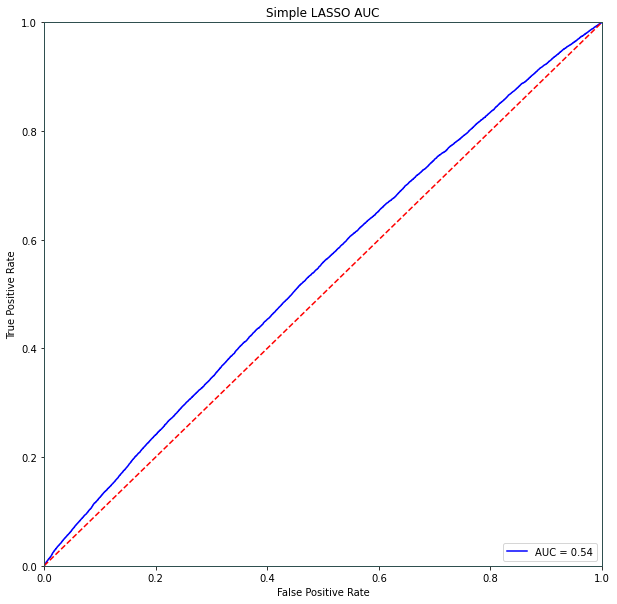

['11:65477306' '1:150456350' '11:65585257' '5:96374150' '5:96200770'
 '5:96257285' '11:65407886' '6:32438298' '6:32606941' '5:96101944'
 '6:32592605' '5:96323549' '5:96124330' '6:31239896' '6:31461771'
 '5:96057882' '1:150406172' '5:96092990' '1:150861859' '5:96115721'
 '5:96206563' '6:32581973' '6:32731258' '5:96147733' '6:32614080'
 '6:32789480' '6:32580657' '5:96128022' '5:96125330' '11:65640906'
 '11:65747057' '1:150467096' '1:150958977' '1:150635066' '1:150558293'
 '5:96185467' '5:95897963' '5:96198479' '6:29910358' '6:32636866'
 '11:65473798' '5:95999526' '5:96174446' '5:96229272' '1:150527294'
 '5:96174186' '5:96182717' '11:65583066' '1:150878649' '5:95981261'
 '6:31322980' '12:113411806' '11:65412467' '5:96120933' '5:96216387'
 '1:150737220' '5:95909680' '5:96293021' '6:32561327' '6:32610059'
 '1:150618632' '5:96151760' '6:32602396' '6:32575658' '6:32683121'
 '6:32389255' '6:32612397' '6:32592796' '6:32582194' '6:32584625'
 '6:32581582' '6:32583274']


In [144]:
#Now recreate model from fig. 7 using this new composite dataframe

#filter using LASSO regression
from sklearn.linear_model import Lasso

model = Lasso(alpha=0.000015,random_state=random_sate)  

# fit model
model.fit(SNP_outcome_cov_table_training_x, SNP_outcome_cov_table_training_y)

p = model.predict(SNP_outcome_cov_table_training_x)  # test the output by changing values
#Find model that gives best AUC, do a cutoff of weakest contributing SNPS, then run all analysis portions

import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
#preds = np.around(p, decimals=0, out=None)

preds=p

fpr, tpr, threshold = metrics.roc_curve(list(SNP_outcome_cov_table_training_y), preds,pos_label=1)

roc_auc = metrics.auc(fpr, tpr)

print(roc_auc)
# method I: plt
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.title('Simple LASSO AUC')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#now drop SNPs with low contribution
print(SNP_outcome_cov_table_training_x.columns.values[model.coef_==0])


In [145]:
#remake SNP list with dropped "useless" SNPs

geneva_outcome_cov_table_dropped=geneva_outcome_cov_table.drop(SNP_outcome_cov_table_training_x.columns.values[model.coef_==0],axis=1)
SNP_outcome_cov_table_downsamp_dropped=SNP_outcome_cov_table_downsamp.drop(SNP_outcome_cov_table_training_x.columns.values[model.coef_==0],axis=1)

geneva_outcome_cov_table_x=geneva_outcome_cov_table_dropped.drop(['IID',
       'PRS', 'pheno', 'age', 'Gender_', 'Breslow_tumor_thickness',
       'family_history', 'sex', 'FID', 'SOL', 'C1', 'C2', 'C3', 'C4',
       'C5', 'C6', 'C7', 'C8', 'C9', 'C10'],axis=1)
geneva_outcome_cov_table_x.index=geneva_outcome_cov_table_dropped["IID"]
geneva_outcome_cov_table_x=geneva_outcome_cov_table_x.drop(["index_x","index_y"],axis=1)

geneva_outcome_cov_table_y=geneva_outcome_cov_table_dropped["pheno"]
geneva_outcome_cov_table_y.index=geneva_outcome_cov_table_dropped["IID"]

SNP_outcome_cov_table_training_x=SNP_outcome_cov_table_downsamp_dropped.drop(["IID","Cancer","C43-C44","C60-C63","AGE","SEX","PC1","PC2","PC3","PC4","PC5","PC6","PC7","PC8","PC9","PC10",'PRS',
       'FID', 'D55-D59', 'D80-D89', 'E70-E90', 'I70-I79', 'K20-K31',
       'K50-K52', 'K70-K77', 'K80-K87', 'K90-K93', 'L40-L45', 'M00-M03',
       'M05-M14', 'M15-M19', 'M20-M25', 'M70-M79', 'M45-M49', 'M60-M63',
       'R70-R79', 'C73-C75', 'C81-C96', 'D60-D64', 'C40-C41', 'D37-D48',
       'D70-D77', 'C50-C50', 'D65-D69', 'C00-C14', 'C45-C49', 'D00-D09',
       'C30-C39', 'C97-C97', 'D50-D53', 'C76-C80', 'C15-C26', 'C51-C58',
       'D10-D36', 'C69-C72', 'C64-C68',"AnyCancer"],axis=1)
SNP_outcome_cov_table_training_x.index=SNP_outcome_cov_table_downsamp_dropped["IID"]
SNP_outcome_cov_table_training_x=SNP_outcome_cov_table_training_x.drop(["level_0","index"],axis=1)
SNP_outcome_cov_table_training_y=SNP_outcome_cov_table_downsamp_dropped["Cancer"]
SNP_outcome_cov_table_training_y.index=SNP_outcome_cov_table_downsamp_dropped["IID"]

geneva_outcome_cov_table_dropped=geneva_outcome_cov_table_dropped.reset_index()


In [146]:
pd.DataFrame(SNP_outcome_cov_table_training_x.columns.values).to_csv("/cellar/users/tsears/projects/germline-immune/data/fig4/melanoma_final_snps.txt",sep="\t")

In [147]:
import xgboost
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold

regressor_xgb = xgboost.XGBRFRegressor(n_estimators = 200, random_state = random_sate,learning_rate=0.3,max_depth=9,verbose_eval=10)

regressor_xgb.fit(SNP_outcome_cov_table_training_x, SNP_outcome_cov_table_training_y)  

p = regressor_xgb.predict(geneva_outcome_cov_table_x)  # test the output by changing values
p_disc=regressor_xgb.predict(SNP_outcome_cov_table_training_x)

geneva_outcome_cov_table_dropped["LASSO_burden"]=p
SNP_outcome_cov_table_downsamp_dropped["LASSO_burden"]=p_disc

[17:58:00] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:576: 
Parameters: { "verbose_eval" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




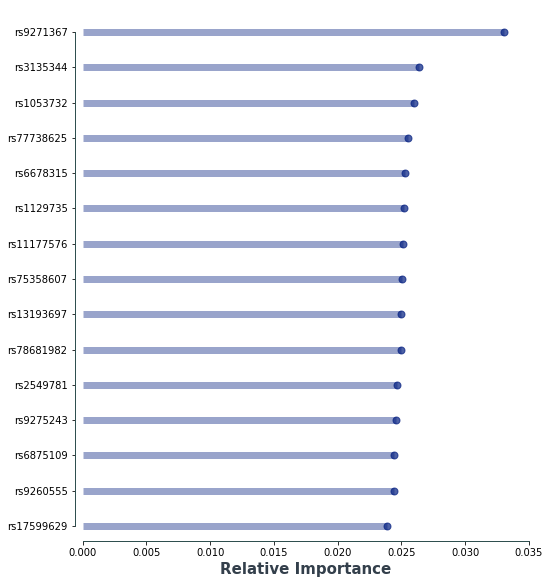

In [148]:
features = SNP_outcome_cov_table_training_x.columns.values.tolist()
features=[x.rsplit("_")[0] for x in features]
importances = regressor_xgb.feature_importances_

mapping_table=pd.concat([pd.DataFrame(features),pd.DataFrame(importances)],axis=1)
mapping_table.columns=["ID","importance"]

rsid_table=pd.read_csv("/cellar/users/mpagadal/projects/germline-immune/data/supplemental/Supplemental_Table_3_annot.csv",sep="\t")
rsid_table=rsid_table.drop_duplicates(subset="rsid")
rsid_table=rsid_table[["snp_noallele","rsid"]]

compiled_icb_rsid_plot=pd.merge(mapping_table,rsid_table,left_on="ID",right_on="snp_noallele")

compiled_icb_rsid_plot=compiled_icb_rsid_plot.sort_values(by="importance")
compiled_icb_rsid_plot=compiled_icb_rsid_plot.iloc[compiled_icb_rsid_plot.shape[0]-15:compiled_icb_rsid_plot.shape[0],:]

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'

plt.rcParams['axes.edgecolor']='darkslategrey'
plt.rcParams['axes.linewidth']=1
plt.rcParams['xtick.color']='black'
plt.rcParams['ytick.color']='black'
plt.style.use('seaborn-dark-palette')

my_range=list(range(0,len(compiled_icb_rsid_plot["importance"])))
fig, ax = plt.subplots(figsize=(8,10))
plt.hlines(y=my_range, xmin=0, xmax=compiled_icb_rsid_plot["importance"], alpha=0.4, linewidth=7)
plt.plot(compiled_icb_rsid_plot["importance"], my_range, "o", markersize=7, alpha=0.7)
# set labels style
ax.set_xlabel('Relative Importance', fontsize=15, fontweight='black', color = '#333F4B')
ax.set_ylabel('')
# change the style of the axis spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_bounds((0, len(my_range)-1))
ax.set_xlim(0,0.035)
plt.yticks(range(len(compiled_icb_rsid_plot["importance"])), compiled_icb_rsid_plot["rsid"])
# add some space between the axis and the plot
ax.spines['left'].set_position(('outward', 8))
ax.spines['bottom'].set_position(('outward', -10))

plt.savefig("/cellar/users/tsears/projects/germline-immune/plots/fig4/melanoma_feature_importance_V2.pdf",bbox_inches = "tight")


/cm/shared/apps/jupyter/12.3.0/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


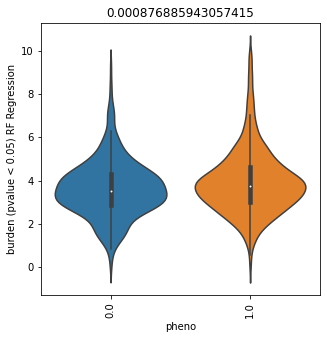

In [65]:
geneva_outcome_cov_table2=geneva_outcome_cov_table_dropped[geneva_outcome_cov_table_dropped["family_history"]!=1]
geneva_outcome_cov_table_plot=geneva_outcome_cov_table2
geneva_outcome_cov_table_plot=geneva_outcome_cov_table_plot.loc[geneva_outcome_cov_table_plot['LASSO_burden']<float(geneva_outcome_cov_table_plot['LASSO_burden'].quantile([0.99]))]
minmax_scale = preprocessing.MinMaxScaler(feature_range=(0, 10))
x = geneva_outcome_cov_table_plot["LASSO_burden"].values.reshape(-1, 1)
geneva_outcome_cov_table_plot["LASSO_scaled"] = minmax_scale.fit_transform(x)

fig = plt.figure(figsize=(5,5))

sns.violinplot(x="pheno",y="LASSO_scaled",data=geneva_outcome_cov_table_plot)

cat1 = geneva_outcome_cov_table2[geneva_outcome_cov_table2["pheno"]==0]
cat2 = geneva_outcome_cov_table2[geneva_outcome_cov_table2["pheno"]==1]
disc_score=cat2["LASSO_burden"].mean()-cat1["LASSO_burden"].mean()

plt.title(stats.mannwhitneyu(cat1["LASSO_burden"], cat2["LASSO_burden"])[1])

plt.ylabel("burden (pvalue < 0.05) RF Regression")
plt.xticks(rotation=90)
#plt.savefig("/cellar/users/tsears/projects/germline-immune/plots/fig5/melanomaViolin_FH_only_RescaledOutlierDroppedFromPlot.pdf")
plt.savefig("/cellar/users/tsears/projects/germline-immune/plots/fig5/melanomaViolin_FH_only_rescaled_99th_dropped.pdf")



In [66]:
#restructure PRS score so that it makes more sense to plot
geneva_outcome_cov_table_dropped.columns.values
geneva_outcome_cov_table_dropped["PRS"]=geneva_outcome_cov_table_dropped["LASSO_burden"]
geneva_outcome_cov_table2["PRS"]=geneva_outcome_cov_table2["LASSO_burden"]

/cm/shared/apps/jupyter/12.3.0/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [67]:
geneva_outcome_odds=quantile_plot(geneva_outcome_cov_table2,"pheno ~ group + age + sex + C1 + C2 + C3 + C4 + C5 + C6 + C7 + C8 + C9 + C10",10,"logistic")
#geneva_outcome_odds=quantile_plot(geneva_outcome_cov_table2,"pheno ~ group",10,"logistic")

/cm/shared/apps/jupyter/12.3.0/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/.local/lib/python3.7/site-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['method']
  warnings.warn(msg, ValueWarning)
/cm/shared/apps/jupyter/12.3.0/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/.local/lib/python3.7/site-packages/statsmodels/base/model.py:127: Value

0    169
1    169
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.551226
         Iterations 6
1    170
0    169
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.519002
         Iterations 6
1    169
0    169
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.545223
         Iterations 6
1    170
0    169
Name: group, dtype: int64


/cellar/users/tsears/.local/lib/python3.7/site-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['method']
  warnings.warn(msg, ValueWarning)
/cm/shared/apps/jupyter/12.3.0/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/.local/lib/python3.7/site-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['method']
  warnings.warn(msg, ValueWarning)
/cm/shared/apps/jupyter/12.3.0/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/panda

Optimization terminated successfully.
         Current function value: 0.540988
         Iterations 6
0    169
1    169
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.501235
         Iterations 6
1    169
Name: group, dtype: int64
1    170
0    169
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.529732
         Iterations 6
1    170
0    169
Name: group, dtype: int64


/cellar/users/tsears/.local/lib/python3.7/site-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['method']
  warnings.warn(msg, ValueWarning)
/cm/shared/apps/jupyter/12.3.0/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/.local/lib/python3.7/site-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['method']
  warnings.warn(msg, ValueWarning)
/cm/shared/apps/jupyter/12.3.0/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/panda

Optimization terminated successfully.
         Current function value: 0.508096
         Iterations 6
1    170
0    169
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.483214
         Iterations 6
1    169
0    169
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.464374
         Iterations 7


/cellar/users/tsears/.local/lib/python3.7/site-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['method']
  warnings.warn(msg, ValueWarning)


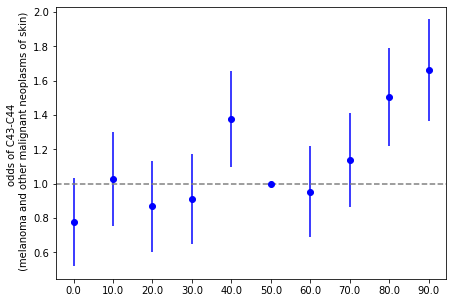

In [68]:
f=plt.figure(figsize=(7,5))

plt.errorbar(x=geneva_outcome_odds["quant"].tolist(),y=geneva_outcome_odds["odds"].tolist(),yerr=geneva_outcome_odds["se"].tolist(),fmt="o",color="blue",label="group1 + mhc genes")
plt.ylabel("quantile")
plt.ylabel("odds of C43-C44 \n (melanoma and other malignant neoplasms of skin)")
plt.axhline(1,linestyle="--",color="gray")
plt.savefig("/cellar/users/tsears/projects/germline-immune/plots/fig5/melanoma.quantile.FH.pdf")


Text(0.5, 0, 'PRS')

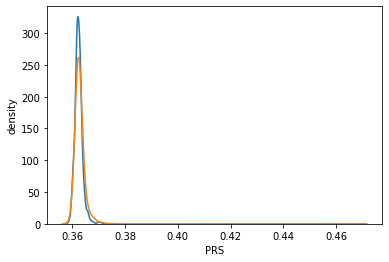

In [69]:
sns.kdeplot(geneva_outcome_cov_table2[geneva_outcome_cov_table2["pheno"]==0]["LASSO_burden"],label="controls")
sns.kdeplot(geneva_outcome_cov_table2[geneva_outcome_cov_table2["pheno"]==1]["LASSO_burden"],label="cases")
plt.ylabel("density")
plt.xlabel("PRS")

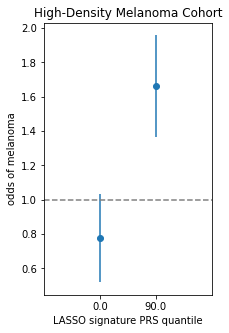

In [70]:
#1st vs 10th quantile
geneva_outcome_odds_filt=geneva_outcome_odds[geneva_outcome_odds["quant"].isin(["0.0","90.0"])]
f=plt.figure(figsize=(3,5))
plt.errorbar(x=geneva_outcome_odds_filt["quant"].tolist(),y=geneva_outcome_odds_filt["odds"].tolist(),yerr=geneva_outcome_odds_filt["se"].tolist(),fmt="o")
plt.xlabel("LASSO signature PRS quantile")
plt.ylabel("odds of melanoma")
plt.title("High-Density Melanoma Cohort")
plt.xticks([0,1])
plt.xlim((-1, 2))
plt.axhline(1,linestyle="--",color="gray")
plt.savefig("/cellar/users/tsears/projects/germline-immune/plots/fig5/1vs9_melanoma.quantile.pdf")


## Melanoma based TCGA inflammation

In [72]:
group1_sumstats=ukbb_annot[ukbb_annot["group"]=="group1"][["proxy_variant","ukbb_a1","Var1_OR","Outcome"]]
group1_sumstats=group1_sumstats[group1_sumstats["Outcome"]=="C43-C44"]
group1_sumstats.columns=["ID","A1","OR","Outcome"]

mhcII_sumstats=ukbb_annot[ukbb_annot["file"]=="Sigs160-Wolf_MHC2-21978456"][["proxy_variant","ukbb_a1","Var1_OR","Outcome"]]
mhcII_sumstats=mhcII_sumstats[mhcII_sumstats["Outcome"]=="C43-C44"]
mhcII_sumstats.columns=["ID","A1","OR","Outcome"]

group1_mhcII_sumstats=group1_sumstats.append(mhcII_sumstats)
group1_mhcII_sumstats

tcga_group1_prs,tcga_snp_table=make_ukbb_prs("/cellar/users/mpagadal/projects/germline-immune/data/genotypes/all.time.raw",group1_mhcII_sumstats,group1_mhcII_sumstats["ID"].tolist())

124 PRS snps
0 snps missing weight
switching 108 genotypes


In [73]:
canc = pd.read_csv("/cellar/controlled/dbgap-genetic/phs000178_TCGA/birdseed-processing/gtype.meta", delimiter="\t", header=None)
mp = canc.set_index(2)[0].to_dict()
tcga_group1_prs["cancer"]=tcga_group1_prs["IID"].map(mp)
tcga_group1_prs_SKCM=tcga_group1_prs[tcga_group1_prs["cancer"]=="SKCM"]

tcga_snp_table=tcga_snp_table[tcga_group1_prs_SKCM["IID"]]
tcga_snp_table=tcga_snp_table.transpose()

In [74]:
#trim tcga_snp_table down to model feature space
tcga_snp_table_test=tcga_snp_table[geneva_outcome_cov_table_x.columns.values]

In [75]:
#test the melanoma xgboost model using tcga_snp_table as an input dataset..?
import xgboost
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold

#MAKE SURE YOU RUN THIS SECTION JUST AFTER THE MELANOMA MODEL TRAINING BECAUSE IT HAS THE SAME VARIABLE NAME AS THE PROSTATE MODEL... SORRY
p = regressor_xgb.predict(tcga_snp_table_test)  # test the output by changing values

tcga_snp_table_test["LASSO_burden"]=p
tcga_group1_prs_SKCM["LASSO_burden"]=p

/cm/shared/apps/jupyter/12.3.0/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/cm/shared/apps/jupyter/12.3.0/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [76]:
#get cibersortx data
ciber_lm22=pd.read_csv("/cellar/users/mpagadal/projects/germline-immune/data/plink-associations/phenotypes/TCGA.Kallisto.fullIDs.cibersort.relative.tsv",delimiter="\t")
ciber_lm22["id"]=ciber_lm22["SampleID"].str.replace(".","-")
ciber_lm22["code"]=ciber_lm22["id"].str.rsplit("-",4).str[1]
ciber_lm22["id"]=ciber_lm22["id"].str.rsplit("-",4).str[0]
ciber_lm22=ciber_lm22[ciber_lm22["code"].str.contains("01")]
ciber_lm22.index=ciber_lm22["id"]
ciber_lm22=ciber_lm22[ciber_lm22.columns[2:-5].tolist()]
ciber_lm22=ciber_lm22.groupby(ciber_lm22.index).mean()
ciber_lm22=ciber_lm22.reset_index().rename(columns={"id":"IID"})

tcga_group1_prs=pd.merge(tcga_group1_prs_SKCM,ciber_lm22,on="IID",how="left")

/cm/shared/apps/jupyter/12.3.0/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  This is separate from the ipykernel package so we can avoid doing imports until


/cm/shared/apps/jupyter/12.3.0/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


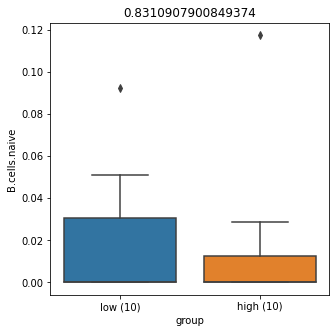

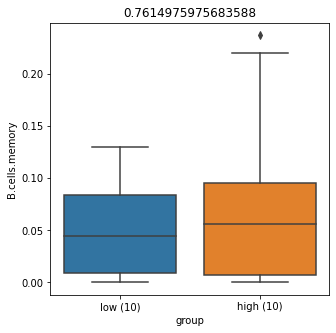

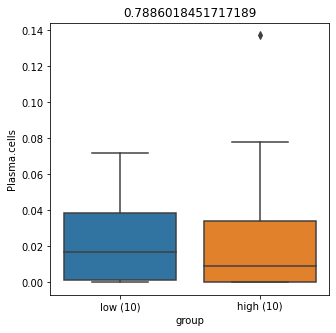

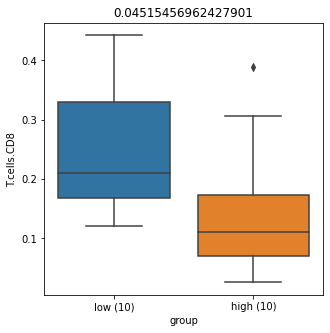

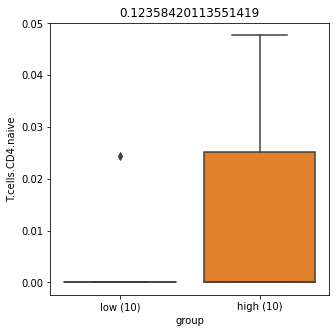

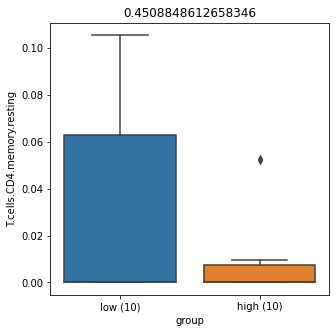

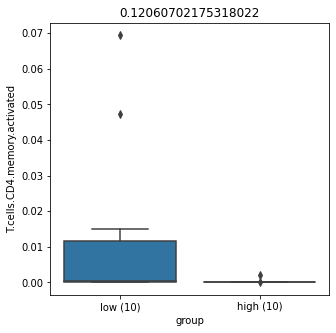

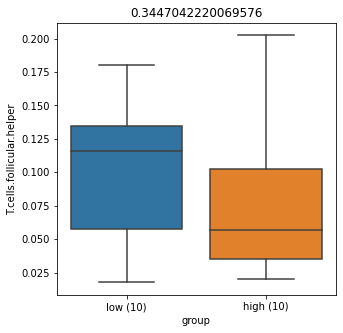

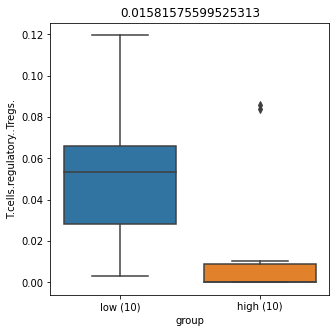

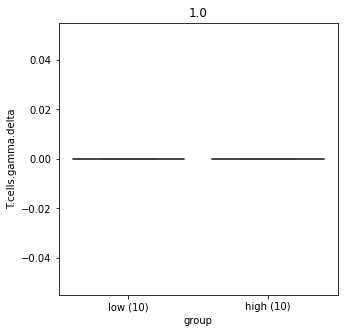

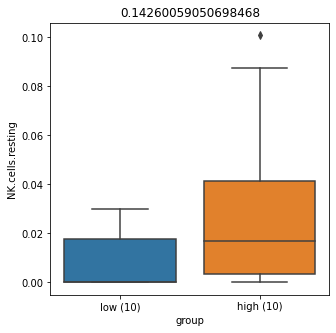

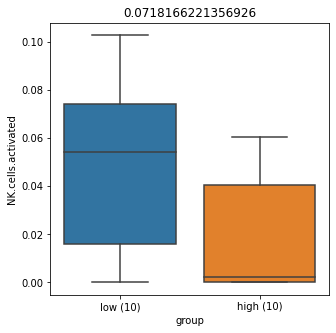

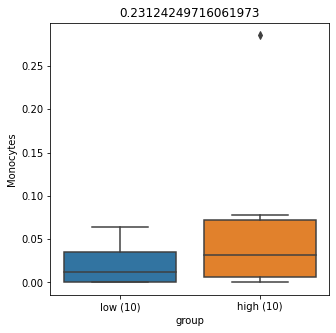

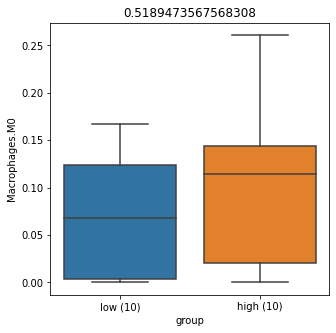

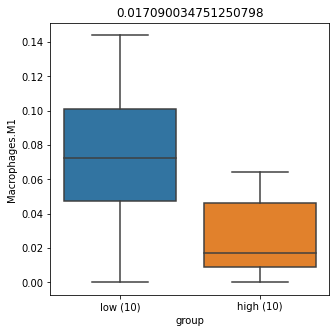

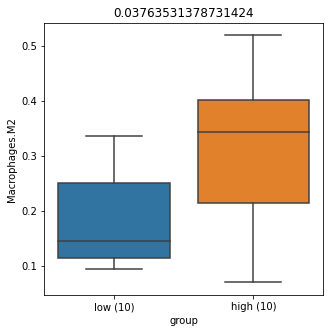

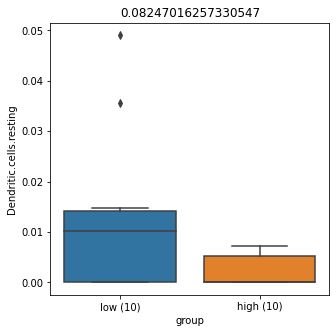

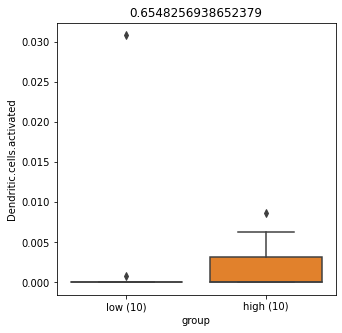

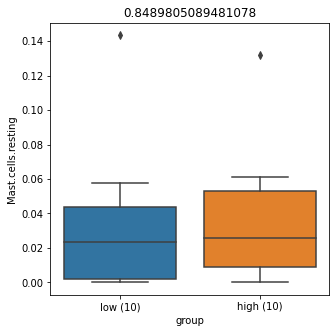

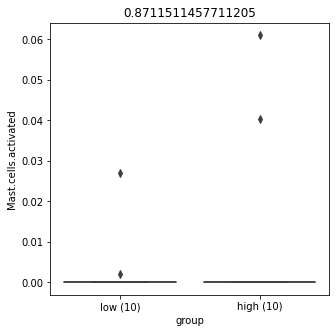

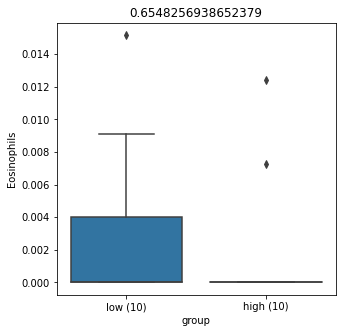

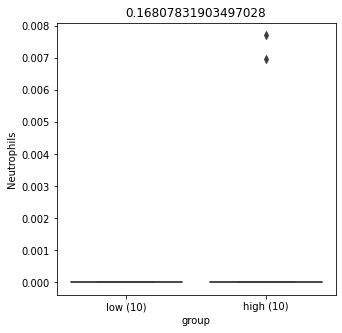

In [77]:
for x in tcga_group1_prs.columns[4:]:
    f=plt.figure(figsize=(5,5))
    
    pheno=x 
    tcga_group1_prs_cancer=tcga_group1_prs[tcga_group1_prs["cancer"]=="SKCM"]
    tcga_group1_prs_cancer=tcga_group1_prs_cancer[~tcga_group1_prs_cancer[x].isnull()]
    
    tcga_group1_prs_cancer["group"]=np.where(tcga_group1_prs_cancer["LASSO_burden"]>tcga_group1_prs_cancer["LASSO_burden"].quantile(0.9),"high","medium")
    tcga_group1_prs_cancer["group"]=np.where(tcga_group1_prs_cancer["LASSO_burden"]<tcga_group1_prs_cancer["LASSO_burden"].quantile(0.1),"low",tcga_group1_prs_cancer["group"])

    ax=sns.boxplot(x="group",y=pheno,data=tcga_group1_prs_cancer,order=["low","high"])
    
    labels=[item.get_text() for item in ax.get_xticklabels()]
    labels=[x+" ("+str(len(tcga_group1_prs_cancer[tcga_group1_prs_cancer["group"]==x]))+")" for x in labels]
    ax.set_xticklabels(labels)
    
    cat1 = tcga_group1_prs_cancer[(tcga_group1_prs_cancer["group"]=="low")]
    cat2 = tcga_group1_prs_cancer[(tcga_group1_prs_cancer["group"]=="high")]
    plt.title(str(mannwhitneyu(cat1[pheno], cat2[pheno])[1]))
    plt.savefig("/cellar/users/tsears/projects/germline-immune/plots/fig5/melanoma.PRS."+x+".pdf")

In [78]:
mac_plot=pd.melt(tcga_group1_prs_cancer,id_vars=["IID","group"],value_vars=["Macrophages.M1","Macrophages.M2"])

In [79]:
mac_plot=mac_plot[mac_plot["group"].isin(["low","high"])]

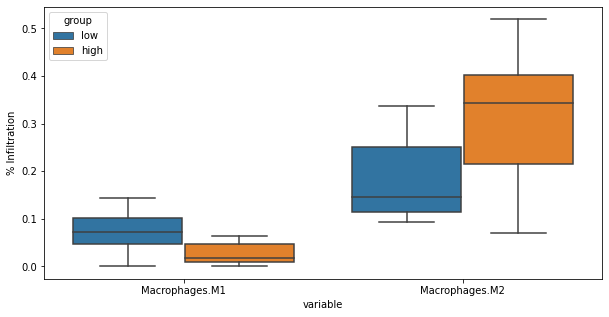

In [80]:
f=plt.figure(figsize=(10,5))
sns.boxplot(x="variable",hue="group",y="value",data=mac_plot)
plt.ylabel('% Infiltration')
plt.savefig("/cellar/users/tsears/projects/germline-immune/plots/fig5/mac.pdf")

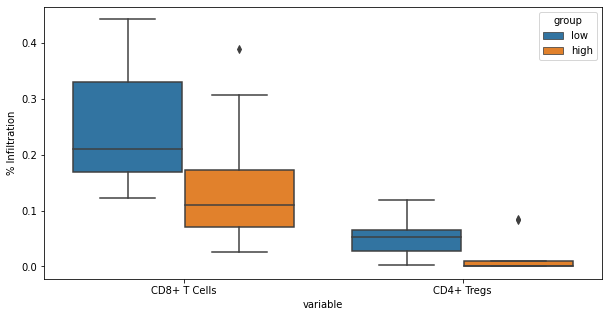

In [2820]:
tcga_group1_prs_cancer=tcga_group1_prs_cancer.rename(columns={"T.cells.regulatory..Tregs.": "CD4+ Tregs", "T.cells.CD8": "CD8+ T Cells"})
T_plot=pd.melt(tcga_group1_prs_cancer,id_vars=["IID","group"],value_vars=["CD8+ T Cells","CD4+ Tregs"])
T_plot=T_plot[T_plot["group"].isin(["low","high"])]
f=plt.figure(figsize=(10,5))
sns.boxplot(x="variable",hue="group",y="value",data=T_plot)
plt.ylabel('% Infiltration')
plt.savefig("/cellar/users/tsears/projects/germline-immune/plots/fig5/Tcells.pdf")

### UKBB with combined MHC+group1 SNPs, protstate training and validation ONLY

#### Prostate Genes ONLY

In [149]:
group1_sumstats=ukbb_annot[ukbb_annot["group"]=="group1"][["proxy_variant","ukbb_a1","Var1_OR","Outcome"]]
group1_sumstats=group1_sumstats[group1_sumstats["Outcome"]=="C60-C63"]
group1_sumstats.columns=["ID","A1","OR","Outcome"]

mhcII_sumstats=ukbb_annot[ukbb_annot["file"]=="Sigs160-Wolf_MHC2-21978456"][["proxy_variant","ukbb_a1","Var1_OR","Outcome"]]
mhcII_sumstats=mhcII_sumstats[mhcII_sumstats["Outcome"]=="C60-C63"]
mhcII_sumstats.columns=["ID","A1","OR","Outcome"]

group1_mhcII_sumstats=group1_sumstats.append(mhcII_sumstats)
group1_mhcII_sumstats

group1_mhc_prs,test_ukbb_res=make_ukbb_prs("/cellar/users/mpagadal/projects/germline-immune/data/ukbb/time-snp/dosage-multi/ukbb_bialleleic.raw",group1_mhcII_sumstats,group1_mhcII_sumstats["ID"].tolist())
icd=pd.read_csv("/cellar/users/mpagadal/data/ukbb/plato_input/immune_cancer_lev1_pheno.txt",delim_whitespace=True)
group1_mhc_prs=pd.merge(group1_mhc_prs,icd,on="IID",how="left")



57 PRS snps
0 snps missing weight
switching 53 genotypes


In [150]:
#merge group1_mhc_prs with raw SNP data then format for model building
group1_mhc_prs_short=group1_mhc_prs[["IID","C43-C44","C60-C63","AGE","SEX","PC1","PC2","PC3","PC4","PC5","PC6","PC7","PC8","PC9","PC10"]]
test_ukbb_res_t=test_ukbb_res.transpose()
SNP_outcome_cov_table=pd.merge(test_ukbb_res_t,group1_mhc_prs,right_on="IID",how="left",left_index=True)

In [151]:
SNP_outcome_cov_table["Cancer"]=SNP_outcome_cov_table[["C43-C44","C60-C63"]].max(axis=1)
np.nansum(SNP_outcome_cov_table["Cancer"]),np.nansum(SNP_outcome_cov_table["C43-C44"]),np.nansum(SNP_outcome_cov_table["C60-C63"])

(21701.0, 14960.0, 7291.0)

In [152]:
#Try joint gene score but slim down to melanoma only
SNP_outcome_cov_table.columns.values
SNP_outcome_cov_table["AnyCancer"]=SNP_outcome_cov_table[['C73-C75', 'C81-C96', 'C40-C41',
        'C50-C50',  'C00-C14', 'C45-C49',
       'C30-C39', 'C97-C97', 'C76-C80', 'C60-C63',
       'C15-C26', 'C51-C58', 'C43-C44', 'C69-C72', 'C64-C68']].max(axis=1)

SNP_outcome_cov_table=SNP_outcome_cov_table[np.logical_or(SNP_outcome_cov_table["C60-C63"]==1,SNP_outcome_cov_table["AnyCancer"]==0)]
SNP_outcome_cov_table["Cancer"]=SNP_outcome_cov_table[["C60-C63"]].max(axis=1)


In [153]:
SNP_outcome_cov_table=SNP_outcome_cov_table.reset_index()
SNP_outcome_cov_table=SNP_outcome_cov_table[~SNP_outcome_cov_table["Cancer"].isnull()]

In [154]:
SNP_outcome_cov_table = SNP_outcome_cov_table.reset_index()

In [155]:
#downsample the controls by a lot
from sklearn.utils import resample

# Separate majority and minority classes
df_majority = SNP_outcome_cov_table[SNP_outcome_cov_table["Cancer"]==0]
df_minority = SNP_outcome_cov_table[SNP_outcome_cov_table["Cancer"]==1]
 
# Downsample majority class
df_majority_downsampled = resample(df_majority, random_state=random_sate,
                                 replace=False,    
                                 n_samples=len(df_majority))
print(df_majority_downsampled.shape)

# Combine minority class with downsampled majority class
SNP_outcome_cov_table_downsamp = pd.concat([df_majority_downsampled, df_minority])

(341376, 112)


In [156]:
SNP_outcome_cov_table_training_x=SNP_outcome_cov_table_downsamp.drop(["IID","Cancer","C43-C44","C60-C63","AGE","SEX","PC1","PC2","PC3","PC4","PC5","PC6","PC7","PC8","PC9","PC10",'PRS',
       'FID', 'D55-D59', 'D80-D89', 'E70-E90', 'I70-I79', 'K20-K31',
       'K50-K52', 'K70-K77', 'K80-K87', 'K90-K93', 'L40-L45', 'M00-M03',
       'M05-M14', 'M15-M19', 'M20-M25', 'M70-M79', 'M45-M49', 'M60-M63',
       'R70-R79', 'C73-C75', 'C81-C96', 'D60-D64', 'C40-C41', 'D37-D48',
       'D70-D77', 'C50-C50', 'D65-D69', 'C00-C14', 'C45-C49', 'D00-D09',
       'C30-C39', 'C97-C97', 'D50-D53', 'C76-C80', 'C15-C26', 'C51-C58',
       'D10-D36', 'C69-C72', 'C64-C68','AnyCancer'],axis=1)
SNP_outcome_cov_table_training_x.index=SNP_outcome_cov_table_downsamp["IID"]
SNP_outcome_cov_table_training_x=SNP_outcome_cov_table_training_x.drop(["level_0","index"],axis=1)
SNP_outcome_cov_table_training_y=SNP_outcome_cov_table_downsamp["Cancer"]
SNP_outcome_cov_table_training_y.index=SNP_outcome_cov_table_downsamp["IID"]


### Generating and preparing the validation datasets

In [157]:
ellipse_prs,ellipse_snps=make_ukbb_prs("/cellar/users/mpagadal/projects/germline-immune/data/genotypes/ellipse/ellipse.raw",group1_mhcII_sumstats,group1_mhcII_sumstats["ID"].tolist())
#add phenotyping
pheno=pd.read_csv("/cellar/controlled/dbgap-genetic/phs001120.v1.p1_ellipse/phenotypes/pheno_affection_status.txt",delimiter="\t",header=None)
pheno[2]=pheno[2].map({1:0,2:1})

mp_pheno=dict(zip(pheno[1],pheno[2]))

ellipse_prs["pheno"]=ellipse_prs["IID"].map(mp_pheno)
cov=pd.read_csv("/cellar/controlled/dbgap-genetic/phs001120.v1.p1_ellipse/covs/age-pcs-fh",delimiter="\t")
ellipse_prs=pd.merge(ellipse_prs,cov,on="IID",how="left")
ellipse_prs["FH_PROS"]=ellipse_prs["FH_PROS"].replace(-9,0)

ellipse_prs["FID"]=ellipse_prs["IID"]

#Merge geneva_prs file with SNP inputs, then chop up into train/test
ellipse_snps_t=ellipse_snps.transpose()
ellipse_snps_t["IID"]=ellipse_snps_t.index

ellipse_snps_t = ellipse_snps_t.reset_index()
ellipse_prs = ellipse_prs.reset_index()

ellipse_snps_t["IID"]=ellipse_snps_t['IID'].astype(str)
ellipse_prs["IID"]=ellipse_prs['IID'].astype(str)

ellipse_outcome_cov_table=pd.merge(pd.DataFrame(ellipse_snps_t),pd.DataFrame(ellipse_prs),on="IID",how="left")


57 PRS snps
0 snps missing weight
switching 45 genotypes


In [158]:
ellipse_outcome_cov_table=ellipse_outcome_cov_table[~ellipse_outcome_cov_table["pheno"].isnull()]
#ellipse_outcome_cov_table=ellipse_outcome_cov_table[ellipse_outcome_cov_table["FH_PROS"]!=0]

ellipse_outcome_cov_table_x=ellipse_outcome_cov_table.drop(['IID',
       'PRS', 'pheno', 'age',
       'FH_PROS', 'FID', 'PC1', 'PC2', 'PC3', 'PC4',
       'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10'],axis=1)

ellipse_outcome_cov_table_x.index=ellipse_outcome_cov_table["IID"]
ellipse_outcome_cov_table_x=ellipse_outcome_cov_table_x.drop(["index_x","index_y"],axis=1)

ellipse_outcome_cov_table_y=ellipse_outcome_cov_table["pheno"]
ellipse_outcome_cov_table_y.index=ellipse_outcome_cov_table["IID"]

In [159]:
SNP_outcome_cov_table_training_y=pd.to_numeric(SNP_outcome_cov_table_training_y, errors='coerce').astype("Int32")
ellipse_outcome_cov_table_y=pd.to_numeric(ellipse_outcome_cov_table_y, errors='coerce').astype("Int32")

In [160]:
#Minor lack of overlap in SNPs from training to testing dataset, so need to pare down training table to SNPs that exist in the ellipse cohort
SNP_outcome_cov_table_training_x=SNP_outcome_cov_table_training_x[ellipse_outcome_cov_table_x.columns.values]

In [161]:
SNP_outcome_cov_table_training_x.shape,SNP_outcome_cov_table_training_y.shape,ellipse_outcome_cov_table_x.shape,ellipse_outcome_cov_table_y.shape

((348667, 50), (348667,), (91644, 50), (91644,))

0.5382223014559917


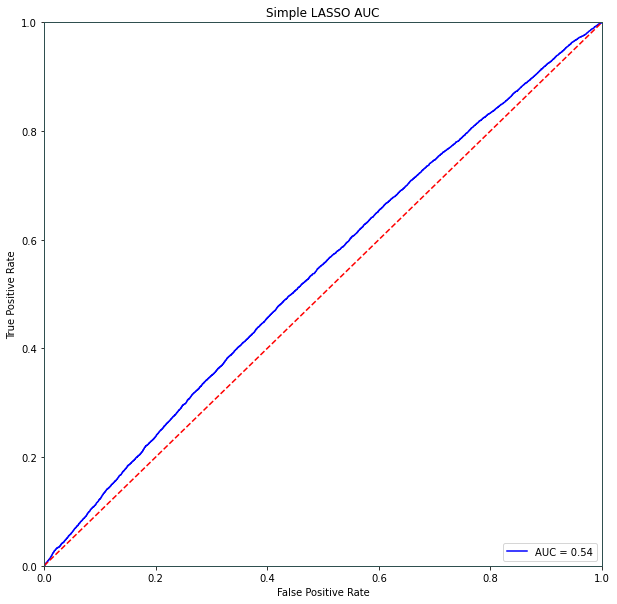

['6:32651641' '6:32438298' '6:29933439' '11:10490415' '6:26364628'
 '5:96124330' '1:150861859' '11:10489826' '6:32634243' '5:96216173'
 '5:96115146' '5:95981776' '1:150558293' '6:29910358' '5:96229272'
 '6:31322980' '6:32204433' '6:32602396' '6:32635629' '6:32212241'
 '6:32647701' '6:32575658' '6:32659609' '6:32134510']


In [162]:
#Now recreate model from fig. 7 using this new composite dataframe

#filter using LASSO regression
from sklearn.linear_model import Lasso

# define model
model = Lasso(alpha=0.00001,random_state=random_sate)

# fit model
model.fit(SNP_outcome_cov_table_training_x, SNP_outcome_cov_table_training_y)

p = model.predict(SNP_outcome_cov_table_training_x)  

#Find model that gives best AUC, do a cutoff of weakest contributing SNPS, then run all analysis portions

import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
#preds = np.around(p, decimals=0, out=None)

preds=p

fpr, tpr, threshold = metrics.roc_curve(list(SNP_outcome_cov_table_training_y), preds,pos_label=1)

roc_auc = metrics.auc(fpr, tpr)

print(roc_auc)
# method I: plt
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.title('Simple LASSO AUC')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#now drop SNPs with low contribution
print(SNP_outcome_cov_table_training_x.columns.values[model.coef_==0])


In [163]:
#remake SNP list with dropped "useless" SNPs

ellipse_outcome_cov_table=ellipse_outcome_cov_table.drop(SNP_outcome_cov_table_training_x.columns.values[model.coef_==0],axis=1)
SNP_outcome_cov_table_downsamp=SNP_outcome_cov_table_downsamp.drop(SNP_outcome_cov_table_training_x.columns.values[model.coef_==0],axis=1)

ellipse_outcome_cov_table_x=ellipse_outcome_cov_table.drop(['IID',
       'PRS', 'pheno', 'age',
       'FH_PROS', 'FID', 'PC1', 'PC2', 'PC3', 'PC4',
       'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10'],axis=1)
ellipse_outcome_cov_table_x.index=ellipse_outcome_cov_table["IID"]
ellipse_outcome_cov_table_x=ellipse_outcome_cov_table_x.drop(["index_x","index_y"],axis=1)

ellipse_outcome_cov_table_y=ellipse_outcome_cov_table["pheno"]
ellipse_outcome_cov_table_y.index=ellipse_outcome_cov_table["IID"]

SNP_outcome_cov_table_training_x=SNP_outcome_cov_table_downsamp.drop(["IID","Cancer","C43-C44","C60-C63","AGE","SEX","PC1","PC2","PC3","PC4","PC5","PC6","PC7","PC8","PC9","PC10",'PRS',
       'FID', 'D55-D59', 'D80-D89', 'E70-E90', 'I70-I79', 'K20-K31',
       'K50-K52', 'K70-K77', 'K80-K87', 'K90-K93', 'L40-L45', 'M00-M03',
       'M05-M14', 'M15-M19', 'M20-M25', 'M70-M79', 'M45-M49', 'M60-M63',
       'R70-R79', 'C73-C75', 'C81-C96', 'D60-D64', 'C40-C41', 'D37-D48',
       'D70-D77', 'C50-C50', 'D65-D69', 'C00-C14', 'C45-C49', 'D00-D09',
       'C30-C39', 'C97-C97', 'D50-D53', 'C76-C80', 'C15-C26', 'C51-C58',
       'D10-D36', 'C69-C72', 'C64-C68'],axis=1)
SNP_outcome_cov_table_training_x.index=SNP_outcome_cov_table_downsamp["IID"]
SNP_outcome_cov_table_training_x=SNP_outcome_cov_table_training_x.drop(["level_0","index"],axis=1)
SNP_outcome_cov_table_training_y=SNP_outcome_cov_table_downsamp["Cancer"]
SNP_outcome_cov_table_training_y.index=SNP_outcome_cov_table_downsamp["IID"]

ellipse_outcome_cov_table=ellipse_outcome_cov_table.reset_index()

SNP_outcome_cov_table_training_x=SNP_outcome_cov_table_training_x[ellipse_outcome_cov_table_x.columns.values]



In [164]:
pd.DataFrame(ellipse_outcome_cov_table_x.columns.values).to_csv("/cellar/users/tsears/projects/germline-immune/data/fig4/prostate_final_snps.txt",sep="\t")

In [165]:
import xgboost
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold

regressor_xgb = xgboost.XGBRFRegressor(n_estimators = 200, random_state = random_sate,learning_rate=0.1,max_depth=9,verbose_eval=10)
regressor_xgb.fit(SNP_outcome_cov_table_training_x, SNP_outcome_cov_table_training_y)  

p = regressor_xgb.predict(ellipse_outcome_cov_table_x)  # test the output by changing values
p_disc=regressor_xgb.predict(SNP_outcome_cov_table_training_x)

ellipse_outcome_cov_table["LASSO_burden"]=p
SNP_outcome_cov_table_downsamp["LASSO_burden"]=p_disc

[18:01:07] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:576: 
Parameters: { "verbose_eval" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




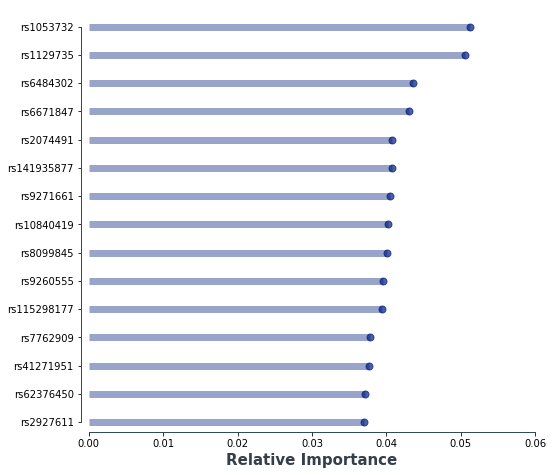

In [166]:
features = SNP_outcome_cov_table_training_x.columns.values.tolist()
features=[x.rsplit("_")[0] for x in features]
importances = regressor_xgb.feature_importances_

mapping_table=pd.concat([pd.DataFrame(features),pd.DataFrame(importances)],axis=1)
mapping_table.columns=["ID","importance"]

rsid_table=pd.read_csv("/cellar/users/mpagadal/projects/germline-immune/data/supplemental/Supplemental_Table_3_annot.csv",sep="\t")
rsid_table=rsid_table.drop_duplicates(subset="rsid")
rsid_table=rsid_table[["snp_noallele","rsid"]]

compiled_icb_rsid_plot=pd.merge(mapping_table,rsid_table,left_on="ID",right_on="snp_noallele")

compiled_icb_rsid_plot=compiled_icb_rsid_plot.sort_values(by="importance")
compiled_icb_rsid_plot=compiled_icb_rsid_plot.iloc[compiled_icb_rsid_plot.shape[0]-15:compiled_icb_rsid_plot.shape[0],:]

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'

plt.rcParams['axes.edgecolor']='darkslategrey'
plt.rcParams['axes.linewidth']=1
plt.rcParams['xtick.color']='black'
plt.rcParams['ytick.color']='black'
plt.style.use('seaborn-dark-palette')

my_range=list(range(0,len(compiled_icb_rsid_plot["importance"])))
fig, ax = plt.subplots(figsize=(8,8))
plt.hlines(y=my_range, xmin=0, xmax=compiled_icb_rsid_plot["importance"], alpha=0.4, linewidth=7)
plt.plot(compiled_icb_rsid_plot["importance"], my_range, "o", markersize=7, alpha=0.7)
# set labels style
ax.set_xlabel('Relative Importance', fontsize=15, fontweight='black', color = '#333F4B')
ax.set_ylabel('')
# change the style of the axis spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_bounds((0, len(my_range)-1))
ax.set_xlim(0,0.06)
plt.yticks(range(len(compiled_icb_rsid_plot["importance"])), compiled_icb_rsid_plot["rsid"])
# add some space between the axis and the plot
ax.spines['left'].set_position(('outward', 8))
ax.spines['bottom'].set_position(('outward', -10))

plt.savefig("/cellar/users/tsears/projects/germline-immune/plots/fig4/prostate_feature_importance_V2.pdf",bbox_inches = "tight")


/cm/shared/apps/jupyter/12.3.0/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


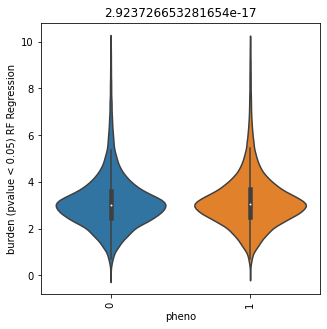

In [2944]:
ellipse_outcome_cov_table_plot=ellipse_outcome_cov_table[ellipse_outcome_cov_table['LASSO_burden']<float(ellipse_outcome_cov_table['LASSO_burden'].quantile([0.99]))]
minmax_scale = preprocessing.MinMaxScaler(feature_range=(0, 10))
x = ellipse_outcome_cov_table_plot["LASSO_burden"].values.reshape(-1, 1)
ellipse_outcome_cov_table_plot["LASSO_scaled"] = minmax_scale.fit_transform(x)

fig = plt.figure(figsize=(5,5))

#sns.boxplot(x="pheno",y="LASSO_scaled",data=ellipse_outcome_cov_table_plot)
sns.violinplot(x="pheno",y="LASSO_scaled",data=ellipse_outcome_cov_table_plot)


cat1 = ellipse_outcome_cov_table[ellipse_outcome_cov_table["pheno"]==0]
cat2 = ellipse_outcome_cov_table[ellipse_outcome_cov_table["pheno"]==1]
disc_score=cat2["LASSO_burden"].mean()-cat1["LASSO_burden"].mean()

plt.title(stats.mannwhitneyu(cat1["LASSO_burden"], cat2["LASSO_burden"])[1])

plt.ylabel("burden (pvalue < 0.05) RF Regression")
plt.xticks(rotation=90)
plt.savefig("/cellar/users/tsears/projects/germline-immune/plots/fig5/prostateViolin_0.99_quantile_Dropped_rescaled.pdf")



Text(0.5, 0, 'PRS')

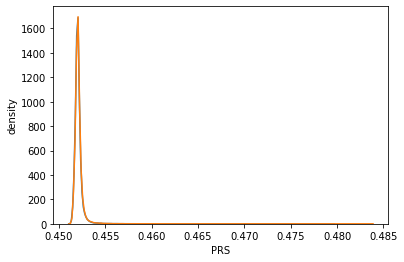

In [2887]:
sns.kdeplot(ellipse_outcome_cov_table[ellipse_outcome_cov_table["pheno"]==0]["LASSO_burden"],label="controls")
sns.kdeplot(ellipse_outcome_cov_table[ellipse_outcome_cov_table["pheno"]==1]["LASSO_burden"],label="cases")
plt.ylabel("density")
plt.xlabel("PRS")

In [2889]:
#restructure PRS score so that it makes more sense to plot
ellipse_outcome_cov_table["PRS"]=ellipse_outcome_cov_table["LASSO_burden"]

In [2890]:
ellipse_outcome_odds=quantile_plot(ellipse_outcome_cov_table,"pheno ~ group + age + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10",10,"logistic")

1    9162
0    9155
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.633328
         Iterations 6


/cm/shared/apps/jupyter/12.3.0/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/.local/lib/python3.7/site-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['method']
  warnings.warn(msg, ValueWarning)
/cm/shared/apps/jupyter/12.3.0/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1    9163
0    9155
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.633945
         Iterations 6
1    9157
0    9155
Name: group, dtype: int64


/cellar/users/tsears/.local/lib/python3.7/site-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['method']
  warnings.warn(msg, ValueWarning)
/cm/shared/apps/jupyter/12.3.0/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/.local/lib/python3.7/site-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['method']
  warnings.warn(msg, ValueWarning)


Optimization terminated successfully.
         Current function value: 0.633066
         Iterations 6
1    9158
0    9155
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.630499
         Iterations 6


/cm/shared/apps/jupyter/12.3.0/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/.local/lib/python3.7/site-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['method']
  warnings.warn(msg, ValueWarning)
/cm/shared/apps/jupyter/12.3.0/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


0    9155
1    9149
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.632324
         Iterations 6
1    9155
Name: group, dtype: int64


/cellar/users/tsears/.local/lib/python3.7/site-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['method']
  warnings.warn(msg, ValueWarning)
/cm/shared/apps/jupyter/12.3.0/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1    9162
0    9155
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.630556
         Iterations 6
1    9156
0    9155
Name: group, dtype: int64


/cellar/users/tsears/.local/lib/python3.7/site-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['method']
  warnings.warn(msg, ValueWarning)
/cm/shared/apps/jupyter/12.3.0/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/.local/lib/python3.7/site-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['method']
  warnings.warn(msg, ValueWarning)


Optimization terminated successfully.
         Current function value: 0.626826
         Iterations 6
1    9162
0    9155
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.627650
         Iterations 6


/cm/shared/apps/jupyter/12.3.0/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/cellar/users/tsears/.local/lib/python3.7/site-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['method']
  warnings.warn(msg, ValueWarning)
/cm/shared/apps/jupyter/12.3.0/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1    9163
0    9155
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.628002
         Iterations 6


/cellar/users/tsears/.local/lib/python3.7/site-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['method']
  warnings.warn(msg, ValueWarning)


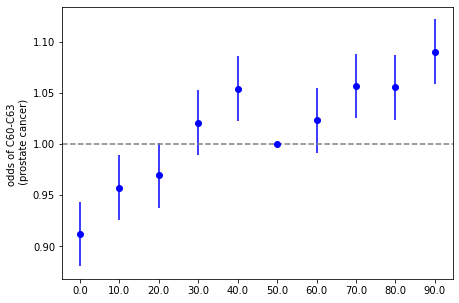

In [2969]:
f=plt.figure(figsize=(7,5))
plt.errorbar(x=ellipse_outcome_odds["quant"].tolist(),y=ellipse_outcome_odds["odds"].tolist(),yerr=ellipse_outcome_odds["se"].tolist(),fmt="o",color="blue",label="group1 + mhc genes")
plt.ylabel("quantile")
plt.ylabel("odds of C60-C63 \n (prostate cancer)")
plt.axhline(1,linestyle="--",color="gray")
plt.savefig("/cellar/users/tsears/projects/germline-immune/plots/fig5/ellipse.quantile.pdf")




Text(0.5, 0, 'PRS')

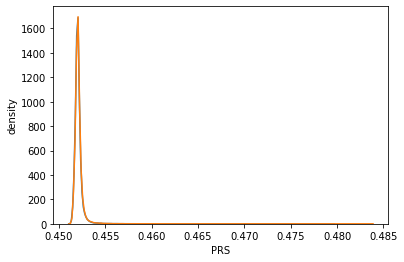

In [2892]:
sns.kdeplot(ellipse_outcome_cov_table[ellipse_outcome_cov_table["pheno"]==0]["LASSO_burden"],label="controls")
sns.kdeplot(ellipse_outcome_cov_table[ellipse_outcome_cov_table["pheno"]==1]["LASSO_burden"],label="cases")
plt.ylabel("density")
plt.xlabel("PRS")

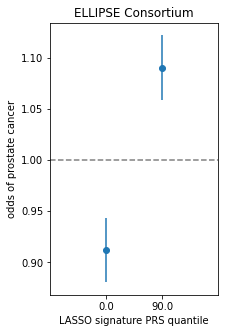

In [2959]:
#1st vs 10th quantile
ellipse_outcome_odds_filt=ellipse_outcome_odds[ellipse_outcome_odds["quant"].isin(["0.0","90.0"])]
f=plt.figure(figsize=(3,5))
plt.errorbar(x=ellipse_outcome_odds_filt["quant"].tolist(),y=ellipse_outcome_odds_filt["odds"].tolist(),yerr=ellipse_outcome_odds_filt["se"].tolist(),fmt="o")
plt.xlabel("LASSO signature PRS quantile")
plt.ylabel("odds of prostate cancer")
plt.xticks([0,1])
plt.xlim((-1, 2))
plt.title("ELLIPSE Consortium")
plt.axhline(1,linestyle="--",color="gray")
plt.savefig("/cellar/users/tsears/projects/germline-immune/plots/fig5/1vs9_prostate.quantile.pdf")


### Prostate Inflam? 

In [2794]:
# Do a version of geneva model onto TCGA, and also do a version of TCGA train test split. Pick best from either one?
# Consider family history in the inflammation plots

In [2961]:
group1_sumstats=ukbb_annot[ukbb_annot["group"]=="group1"][["proxy_variant","ukbb_a1","Var1_OR","Outcome"]]
group1_sumstats=group1_sumstats[group1_sumstats["Outcome"]=="C60-C63"]
group1_sumstats.columns=["ID","A1","OR","Outcome"]

mhcII_sumstats=ukbb_annot[ukbb_annot["file"]=="Sigs160-Wolf_MHC2-21978456"][["proxy_variant","ukbb_a1","Var1_OR","Outcome"]]
mhcII_sumstats=mhcII_sumstats[mhcII_sumstats["Outcome"]=="C60-C63"]
mhcII_sumstats.columns=["ID","A1","OR","Outcome"]

group1_mhcII_sumstats=group1_sumstats.append(mhcII_sumstats)
group1_mhcII_sumstats

tcga_group1_prs,tcga_snp_table=make_ukbb_prs("/cellar/users/mpagadal/projects/germline-immune/data/genotypes/all.time.raw",group1_mhcII_sumstats,group1_mhcII_sumstats["ID"].tolist())

57 PRS snps
0 snps missing weight
switching 50 genotypes


In [2962]:
canc = pd.read_csv("/cellar/controlled/dbgap-genetic/phs000178_TCGA/birdseed-processing/gtype.meta", delimiter="\t", header=None)
mp = canc.set_index(2)[0].to_dict()
tcga_group1_prs["cancer"]=tcga_group1_prs["IID"].map(mp)
tcga_group1_prs_SKCM=tcga_group1_prs[tcga_group1_prs["cancer"]=="PRAD"]

tcga_snp_table=tcga_snp_table[tcga_group1_prs_SKCM["IID"]]
tcga_snp_table=tcga_snp_table.transpose()

In [2965]:
#trim tcga_snp_table down to model feature space
tcga_snp_table_test=tcga_snp_table[ellipse_outcome_cov_table_x.columns.values]

In [2966]:
#test the melanoma xgboost model using tcga_snp_table as an input dataset..?
import xgboost
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold

#MAKE SURE YOU RUN THIS SECTION JUST AFTER THE MELANOMA MODEL TRAINING BECAUSE IT HAS THE SAME VARIABLE NAME AS THE PROSTATE MODEL... SORRY
p = regressor_xgb.predict(tcga_snp_table_test)  # test the output by changing values

tcga_snp_table_test["LASSO_burden"]=p
tcga_group1_prs_SKCM["LASSO_burden"]=p

/cm/shared/apps/jupyter/12.3.0/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/cm/shared/apps/jupyter/12.3.0/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [2967]:
#get cibersortx data
ciber_lm22=pd.read_csv("/cellar/users/mpagadal/projects/germline-immune/data/plink-associations/phenotypes/TCGA.Kallisto.fullIDs.cibersort.relative.tsv",delimiter="\t")
ciber_lm22["id"]=ciber_lm22["SampleID"].str.replace(".","-")
ciber_lm22["code"]=ciber_lm22["id"].str.rsplit("-",4).str[1]
ciber_lm22["id"]=ciber_lm22["id"].str.rsplit("-",4).str[0]
ciber_lm22=ciber_lm22[ciber_lm22["code"].str.contains("01")]
ciber_lm22.index=ciber_lm22["id"]
ciber_lm22=ciber_lm22[ciber_lm22.columns[2:-5].tolist()]
ciber_lm22=ciber_lm22.groupby(ciber_lm22.index).mean()
ciber_lm22=ciber_lm22.reset_index().rename(columns={"id":"IID"})

tcga_group1_prs=pd.merge(tcga_group1_prs_SKCM,ciber_lm22,on="IID",how="left")

/cm/shared/apps/jupyter/12.3.0/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  This is separate from the ipykernel package so we can avoid doing imports until


/cm/shared/apps/jupyter/12.3.0/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


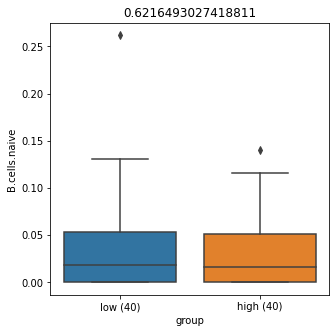

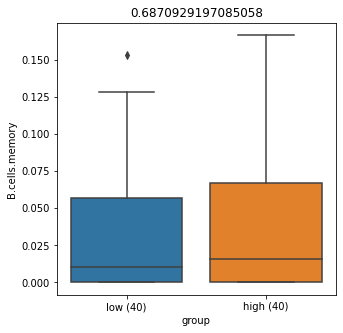

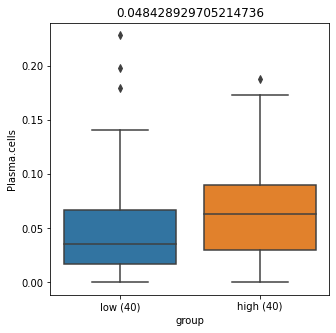

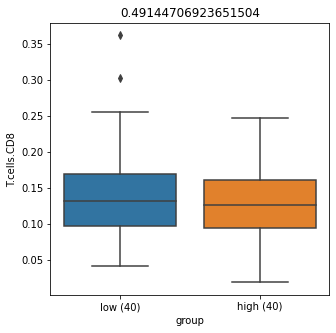

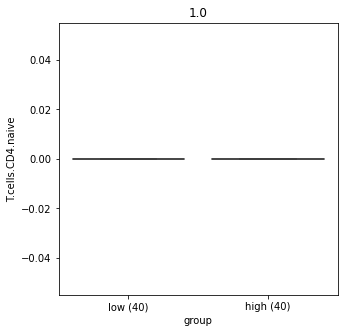

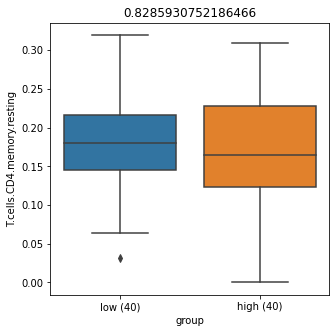

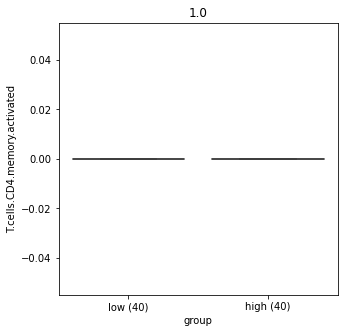

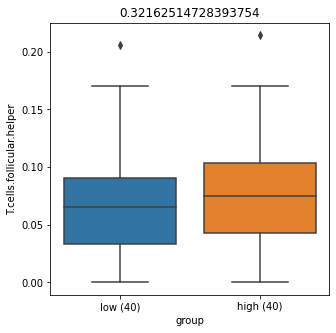

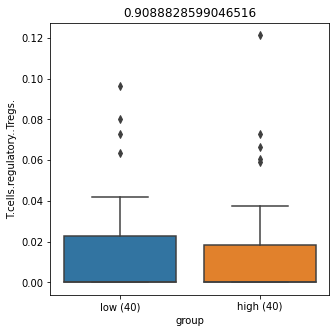

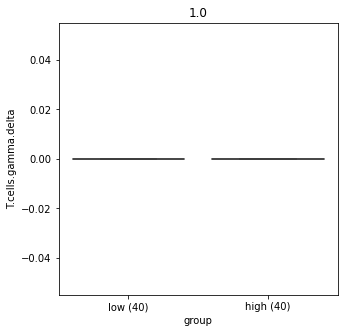

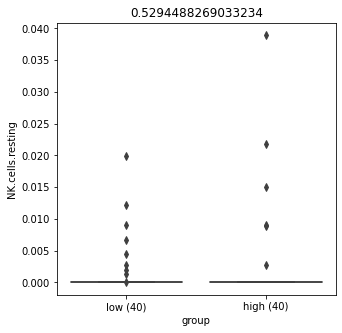

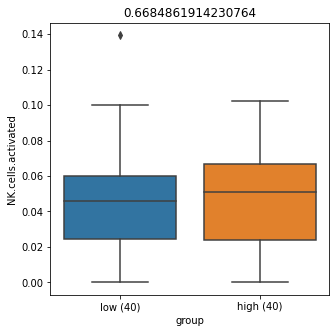

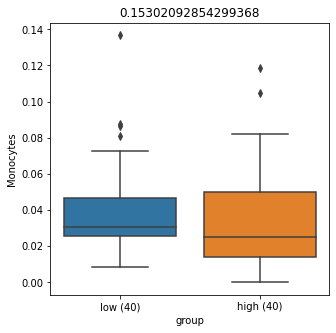

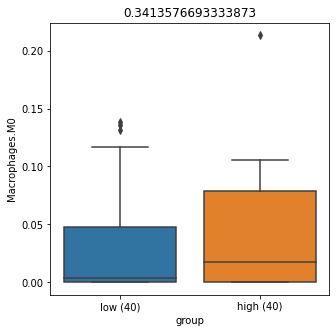

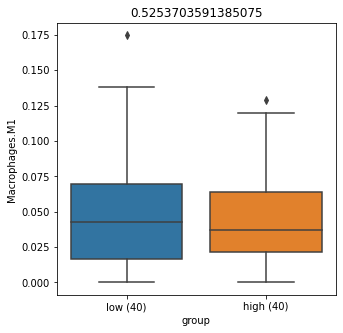

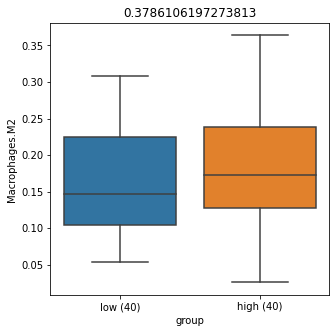

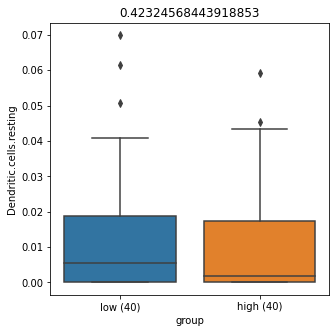

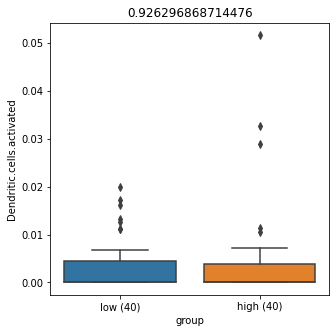

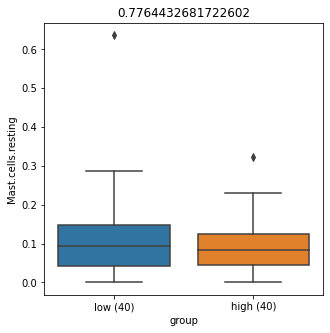

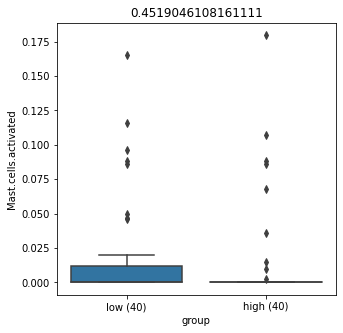

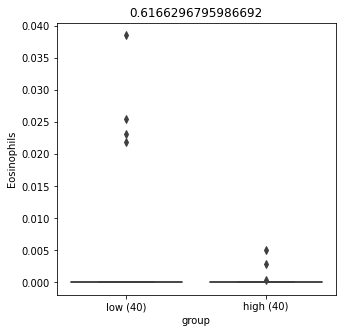

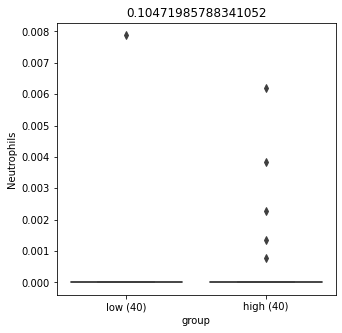

In [2968]:
for x in tcga_group1_prs.columns[4:]:
    f=plt.figure(figsize=(5,5))
    
    pheno=x 
    tcga_group1_prs_cancer=tcga_group1_prs[tcga_group1_prs["cancer"]=="PRAD"]
    tcga_group1_prs_cancer=tcga_group1_prs_cancer[~tcga_group1_prs_cancer[x].isnull()]
    
    tcga_group1_prs_cancer["group"]=np.where(tcga_group1_prs_cancer["LASSO_burden"]>tcga_group1_prs_cancer["LASSO_burden"].quantile(0.9),"high","medium")
    tcga_group1_prs_cancer["group"]=np.where(tcga_group1_prs_cancer["LASSO_burden"]<tcga_group1_prs_cancer["LASSO_burden"].quantile(0.1),"low",tcga_group1_prs_cancer["group"])

    ax=sns.boxplot(x="group",y=pheno,data=tcga_group1_prs_cancer,order=["low","high"])
    
    labels=[item.get_text() for item in ax.get_xticklabels()]
    labels=[x+" ("+str(len(tcga_group1_prs_cancer[tcga_group1_prs_cancer["group"]==x]))+")" for x in labels]
    ax.set_xticklabels(labels)
    
    cat1 = tcga_group1_prs_cancer[(tcga_group1_prs_cancer["group"]=="low")]
    cat2 = tcga_group1_prs_cancer[(tcga_group1_prs_cancer["group"]=="high")]
    plt.title(str(mannwhitneyu(cat1[pheno], cat2[pheno])[1]))
    #plt.savefig("/cellar/users/tsears/projects/germline-immune/plots/fig5/melanoma.PRS."+x+".pdf")
    
    

In [533]:
group1_mhcII_sumstats=group1_sumstats.append(mhcII_sumstats)
group1_mhcII_sumstats

,ID,A1,OR,Outcome
2,11:65477306:A:C,A,1.024740,C43-C44
10,1:161388413:A:C,A,0.965676,C43-C44
23,6:32651641:G:T,G,1.082750,C60-C63
32,1:150456350:A:T,A,0.966559,C43-C44
37,11:65585257:C:A,C,1.026000,C43-C44
...,...,...,...,...
788,6:32582194:C:T,C,0.959915,C43-C44
848,6:32584625:G:A,G,0.952881,C43-C44
929,6:32581582:G:C,G,1.047460,C43-C44
1042,6:32583274:G:T,G,1.042730,C43-C44


In [534]:
geneva_prs=make_ukbb_prs("../data/genotypes/geneva_melanoma/geneva.raw",group1_mhcII_sumstats,group1_mhcII_sumstats["ID"].tolist())
pheno=pd.read_csv("/cellar/controlled/dbgap-genetic/phs000187v1_geneva_melanoma/phenotypes/phs000187.v1.pht000814.v1.p1.c1.Melanoma_Data.GRU.txt.gz",comment="#",delimiter="\t")
pheno["case_control"]=pheno["case_control"].map({1:1,2:0,3:np.nan})
pheno["pheno"]=pheno["case_control"]
pheno=pheno.rename(columns={"Geneva_ID_":"IID"})
pheno["age"]=pheno["Age_at_DX"].fillna(pheno["Control_Age_at_DX"])
geneva_prs=pd.merge(geneva_prs,pheno[["IID","pheno","age","Gender_","Breslow_tumor_thickness","family_history"]],on="IID",how="left")
geneva_prs["sex"]=geneva_prs["Gender_"].map({"M":0,"F":1})
pcs=pd.read_csv("/cellar/users/mpagadal/ancestry-analysis/geneva/all.cluster.mds",delim_whitespace=True)
pcs["IID"]=pcs["IID"].astype(str)
geneva_prs["IID"]=geneva_prs["IID"].astype(str)

181 PRS snps


FileNotFoundError: [Errno 2] No such file or directory: '../data/genotypes/geneva_melanoma/geneva.raw'

In [ ]:
geneva_prs=pd.merge(geneva_prs,pcs,on="IID",how="left")

In [ ]:
geneva_prs["FID"]=geneva_prs["IID"]

In [ ]:
f=plt.figure(figsize=(4,5))
ax=sns.violinplot(x="pheno",y="PRS",data=geneva_prs)
cat1 = geneva_prs[(geneva_prs["pheno"]==0)]
cat2 = geneva_prs[(geneva_prs["pheno"]==1)]

labels=[item.get_text() for item in ax.get_xticklabels()]
labels=[x+" ("+str(len(geneva_prs[geneva_prs["pheno"]==float(x)]))+")" for x in labels]
ax.set_xticklabels(labels)

plt.title(str(mannwhitneyu(cat1["PRS"], cat2["PRS"])[1]))

plt.savefig("../plots/fig5/mhcII.geneva.pdf")

In [ ]:
geneva_prs_fh=geneva_prs[geneva_prs["family_history"]!=1]
f=plt.figure(figsize=(4,5))
ax=sns.violinplot(x="pheno",y="PRS",data=geneva_prs_fh)

labels=[item.get_text() for item in ax.get_xticklabels()]
labels=[x+" ("+str(len(geneva_prs_fh[geneva_prs_fh["pheno"]==float(x)]))+")" for x in labels]
ax.set_xticklabels(labels)

cat1 = geneva_prs_fh[(geneva_prs_fh["pheno"]==0)]
cat2 = geneva_prs_fh[(geneva_prs_fh["pheno"]==1)]
plt.title("no FH\n"+str(mannwhitneyu(cat1["PRS"], cat2["PRS"])[1]))
plt.savefig("../plots/fig5/mhcII.geneva.no.fh.pdf")

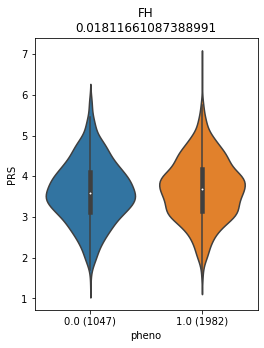

In [43]:
geneva_prs_fh=geneva_prs[geneva_prs["family_history"]!=0]

f=plt.figure(figsize=(4,5))
ax=sns.violinplot(x="pheno",y="PRS",data=geneva_prs_fh)
cat1 = geneva_prs_fh[(geneva_prs_fh["pheno"]==0)]
cat2 = geneva_prs_fh[(geneva_prs_fh["pheno"]==1)]

labels=[item.get_text() for item in ax.get_xticklabels()]
labels=[x+" ("+str(len(geneva_prs_fh[geneva_prs_fh["pheno"]==float(x)]))+")" for x in labels]
ax.set_xticklabels(labels)

plt.title("FH\n"+str(mannwhitneyu(cat1["PRS"], cat2["PRS"])[1]))
mannwhitneyu(cat1["PRS"], cat2["PRS"])[1]
plt.savefig("../plots/fig5/mhcII.geneva.fh.pdf")

In [44]:
geneva_odds=quantile_plot(geneva_prs,"pheno ~ group + age + sex + C1 + C2 + C3 + C4 + C5 + C6 + C7 + C8 + C9 + C10",10,"logistic")

<ipython-input-6-b86c29504aba>:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  controls=df[(df["PRS"]>df["PRS"].quantile(int(num/2)*(1/num)))&(group1_prs["PRS"]<group1_prs["PRS"].quantile(int(num/2)*(1/num)+(1/(num))))]["FID"].tolist()
<ipython-input-6-b86c29504aba>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt["group"]=np.where(df_filt["FID"].isin(cases),1,0)


0    870
1    303
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.615695
         Iterations 5


<ipython-input-6-b86c29504aba>:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  controls=df[(df["PRS"]>df["PRS"].quantile(int(num/2)*(1/num)))&(group1_prs["PRS"]<group1_prs["PRS"].quantile(int(num/2)*(1/num)+(1/(num))))]["FID"].tolist()
<ipython-input-6-b86c29504aba>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt["group"]=np.where(df_filt["FID"].isin(cases),1,0)


0    870
1    303
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.601438
         Iterations 5


<ipython-input-6-b86c29504aba>:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  controls=df[(df["PRS"]>df["PRS"].quantile(int(num/2)*(1/num)))&(group1_prs["PRS"]<group1_prs["PRS"].quantile(int(num/2)*(1/num)+(1/(num))))]["FID"].tolist()
<ipython-input-6-b86c29504aba>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt["group"]=np.where(df_filt["FID"].isin(cases),1,0)


0    870
1    303
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.606957
         Iterations 5


<ipython-input-6-b86c29504aba>:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  controls=df[(df["PRS"]>df["PRS"].quantile(int(num/2)*(1/num)))&(group1_prs["PRS"]<group1_prs["PRS"].quantile(int(num/2)*(1/num)+(1/(num))))]["FID"].tolist()
<ipython-input-6-b86c29504aba>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt["group"]=np.where(df_filt["FID"].isin(cases),1,0)


0    870
1    303
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.611543
         Iterations 5


<ipython-input-6-b86c29504aba>:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  controls=df[(df["PRS"]>df["PRS"].quantile(int(num/2)*(1/num)))&(group1_prs["PRS"]<group1_prs["PRS"].quantile(int(num/2)*(1/num)+(1/(num))))]["FID"].tolist()
<ipython-input-6-b86c29504aba>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt["group"]=np.where(df_filt["FID"].isin(cases),1,0)


0    870
1    303
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.609890
         Iterations 5


<ipython-input-6-b86c29504aba>:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  controls=df[(df["PRS"]>df["PRS"].quantile(int(num/2)*(1/num)))&(group1_prs["PRS"]<group1_prs["PRS"].quantile(int(num/2)*(1/num)+(1/(num))))]["FID"].tolist()
<ipython-input-6-b86c29504aba>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt["group"]=np.where(df_filt["FID"].isin(cases),1,0)


0    698
1    303
Name: group, dtype: int64
0    709
1    303
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.601442
         Iterations 5


<ipython-input-6-b86c29504aba>:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  controls=df[(df["PRS"]>df["PRS"].quantile(int(num/2)*(1/num)))&(group1_prs["PRS"]<group1_prs["PRS"].quantile(int(num/2)*(1/num)+(1/(num))))]["FID"].tolist()
<ipython-input-6-b86c29504aba>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt["group"]=np.where(df_filt["FID"].isin(cases),1,0)


0    670
1    303
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.599981
         Iterations 5


<ipython-input-6-b86c29504aba>:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  controls=df[(df["PRS"]>df["PRS"].quantile(int(num/2)*(1/num)))&(group1_prs["PRS"]<group1_prs["PRS"].quantile(int(num/2)*(1/num)+(1/(num))))]["FID"].tolist()
<ipython-input-6-b86c29504aba>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt["group"]=np.where(df_filt["FID"].isin(cases),1,0)


0    705
1    303
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.602801
         Iterations 5
0    698
1    303
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.601029
         Iterations 5


<ipython-input-6-b86c29504aba>:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  controls=df[(df["PRS"]>df["PRS"].quantile(int(num/2)*(1/num)))&(group1_prs["PRS"]<group1_prs["PRS"].quantile(int(num/2)*(1/num)+(1/(num))))]["FID"].tolist()
<ipython-input-6-b86c29504aba>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt["group"]=np.where(df_filt["FID"].isin(cases),1,0)


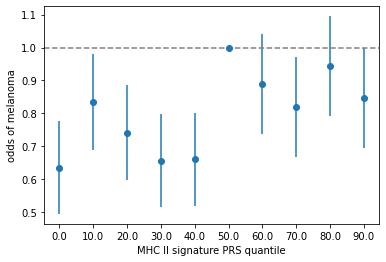

In [45]:
plt.errorbar(x=geneva_odds["quant"].tolist(),y=geneva_odds["odds"].tolist(),yerr=geneva_odds["se"].tolist(),fmt="o")
plt.xlabel("MHC II signature PRS quantile")
plt.ylabel("odds of melanoma")
plt.axhline(1,linestyle="--",color="gray")
plt.savefig("../plots/fig5/mhcII.geneva.quantile.pdf")

In [46]:
geneva_prs_fh=geneva_prs[geneva_prs["family_history"]!=0]
geneva_odds=quantile_plot(geneva_prs_fh,"pheno ~ group + age + sex + C1 + C2 + C3 + C4 + C5 + C6 + C7 + C8 + C9 + C10",10,"logistic")

<ipython-input-6-b86c29504aba>:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  controls=df[(df["PRS"]>df["PRS"].quantile(int(num/2)*(1/num)))&(group1_prs["PRS"]<group1_prs["PRS"].quantile(int(num/2)*(1/num)+(1/(num))))]["FID"].tolist()
<ipython-input-6-b86c29504aba>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt["group"]=np.where(df_filt["FID"].isin(cases),1,0)


0    870
1    303
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.615695
         Iterations 5


<ipython-input-6-b86c29504aba>:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  controls=df[(df["PRS"]>df["PRS"].quantile(int(num/2)*(1/num)))&(group1_prs["PRS"]<group1_prs["PRS"].quantile(int(num/2)*(1/num)+(1/(num))))]["FID"].tolist()
<ipython-input-6-b86c29504aba>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt["group"]=np.where(df_filt["FID"].isin(cases),1,0)


0    870
1    303
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.601438
         Iterations 5


<ipython-input-6-b86c29504aba>:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  controls=df[(df["PRS"]>df["PRS"].quantile(int(num/2)*(1/num)))&(group1_prs["PRS"]<group1_prs["PRS"].quantile(int(num/2)*(1/num)+(1/(num))))]["FID"].tolist()
<ipython-input-6-b86c29504aba>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt["group"]=np.where(df_filt["FID"].isin(cases),1,0)


0    870
1    303
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.606957
         Iterations 5


<ipython-input-6-b86c29504aba>:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  controls=df[(df["PRS"]>df["PRS"].quantile(int(num/2)*(1/num)))&(group1_prs["PRS"]<group1_prs["PRS"].quantile(int(num/2)*(1/num)+(1/(num))))]["FID"].tolist()
<ipython-input-6-b86c29504aba>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt["group"]=np.where(df_filt["FID"].isin(cases),1,0)


0    870
1    303
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.611543
         Iterations 5


<ipython-input-6-b86c29504aba>:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  controls=df[(df["PRS"]>df["PRS"].quantile(int(num/2)*(1/num)))&(group1_prs["PRS"]<group1_prs["PRS"].quantile(int(num/2)*(1/num)+(1/(num))))]["FID"].tolist()
<ipython-input-6-b86c29504aba>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt["group"]=np.where(df_filt["FID"].isin(cases),1,0)


0    870
1    303
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.609890
         Iterations 5


<ipython-input-6-b86c29504aba>:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  controls=df[(df["PRS"]>df["PRS"].quantile(int(num/2)*(1/num)))&(group1_prs["PRS"]<group1_prs["PRS"].quantile(int(num/2)*(1/num)+(1/(num))))]["FID"].tolist()
<ipython-input-6-b86c29504aba>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt["group"]=np.where(df_filt["FID"].isin(cases),1,0)


0    698
1    303
Name: group, dtype: int64
0    709
1    303
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.601442
         Iterations 5


<ipython-input-6-b86c29504aba>:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  controls=df[(df["PRS"]>df["PRS"].quantile(int(num/2)*(1/num)))&(group1_prs["PRS"]<group1_prs["PRS"].quantile(int(num/2)*(1/num)+(1/(num))))]["FID"].tolist()
<ipython-input-6-b86c29504aba>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt["group"]=np.where(df_filt["FID"].isin(cases),1,0)


0    670
1    303
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.599981
         Iterations 5


<ipython-input-6-b86c29504aba>:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  controls=df[(df["PRS"]>df["PRS"].quantile(int(num/2)*(1/num)))&(group1_prs["PRS"]<group1_prs["PRS"].quantile(int(num/2)*(1/num)+(1/(num))))]["FID"].tolist()
<ipython-input-6-b86c29504aba>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt["group"]=np.where(df_filt["FID"].isin(cases),1,0)


0    705
1    303
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.602801
         Iterations 5
0    698
1    303
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.601029
         Iterations 5


<ipython-input-6-b86c29504aba>:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  controls=df[(df["PRS"]>df["PRS"].quantile(int(num/2)*(1/num)))&(group1_prs["PRS"]<group1_prs["PRS"].quantile(int(num/2)*(1/num)+(1/(num))))]["FID"].tolist()
<ipython-input-6-b86c29504aba>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt["group"]=np.where(df_filt["FID"].isin(cases),1,0)


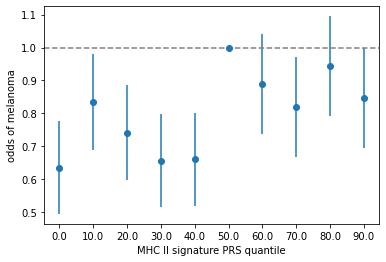

In [47]:
plt.errorbar(x=geneva_odds["quant"].tolist(),y=geneva_odds["odds"].tolist(),yerr=geneva_odds["se"].tolist(),fmt="o")
plt.xlabel("MHC II signature PRS quantile")
plt.ylabel("odds of melanoma")
plt.axhline(1,linestyle="--",color="gray")
plt.savefig("../plots/fig5/mhcII.fh.geneva.quantile.pdf")

In [48]:
geneva_prs_fh=geneva_prs[geneva_prs["family_history"]!=1]
geneva_odds=quantile_plot(geneva_prs_fh,"pheno ~ group + age + sex + C1 + C2 + C3 + C4 + C5 + C6 + C7 + C8 + C9 + C10",10,"logistic")

<ipython-input-6-b86c29504aba>:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  controls=df[(df["PRS"]>df["PRS"].quantile(int(num/2)*(1/num)))&(group1_prs["PRS"]<group1_prs["PRS"].quantile(int(num/2)*(1/num)+(1/(num))))]["FID"].tolist()
<ipython-input-6-b86c29504aba>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt["group"]=np.where(df_filt["FID"].isin(cases),1,0)


0    488
1    169
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.491646
         Iterations 6


<ipython-input-6-b86c29504aba>:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  controls=df[(df["PRS"]>df["PRS"].quantile(int(num/2)*(1/num)))&(group1_prs["PRS"]<group1_prs["PRS"].quantile(int(num/2)*(1/num)+(1/(num))))]["FID"].tolist()
<ipython-input-6-b86c29504aba>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt["group"]=np.where(df_filt["FID"].isin(cases),1,0)


0    488
1    169
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.484702
         Iterations 6


<ipython-input-6-b86c29504aba>:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  controls=df[(df["PRS"]>df["PRS"].quantile(int(num/2)*(1/num)))&(group1_prs["PRS"]<group1_prs["PRS"].quantile(int(num/2)*(1/num)+(1/(num))))]["FID"].tolist()
<ipython-input-6-b86c29504aba>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt["group"]=np.where(df_filt["FID"].isin(cases),1,0)


0    488
1    169
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.490100
         Iterations 6


<ipython-input-6-b86c29504aba>:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  controls=df[(df["PRS"]>df["PRS"].quantile(int(num/2)*(1/num)))&(group1_prs["PRS"]<group1_prs["PRS"].quantile(int(num/2)*(1/num)+(1/(num))))]["FID"].tolist()
<ipython-input-6-b86c29504aba>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt["group"]=np.where(df_filt["FID"].isin(cases),1,0)


0    488
1    169
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.492295
         Iterations 6


<ipython-input-6-b86c29504aba>:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  controls=df[(df["PRS"]>df["PRS"].quantile(int(num/2)*(1/num)))&(group1_prs["PRS"]<group1_prs["PRS"].quantile(int(num/2)*(1/num)+(1/(num))))]["FID"].tolist()
<ipython-input-6-b86c29504aba>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt["group"]=np.where(df_filt["FID"].isin(cases),1,0)


0    488
1    169
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.486284
         Iterations 6


<ipython-input-6-b86c29504aba>:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  controls=df[(df["PRS"]>df["PRS"].quantile(int(num/2)*(1/num)))&(group1_prs["PRS"]<group1_prs["PRS"].quantile(int(num/2)*(1/num)+(1/(num))))]["FID"].tolist()
<ipython-input-6-b86c29504aba>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt["group"]=np.where(df_filt["FID"].isin(cases),1,0)


0    395
1    169
Name: group, dtype: int64
0    398
1    169
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.485771
         Iterations 6


<ipython-input-6-b86c29504aba>:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  controls=df[(df["PRS"]>df["PRS"].quantile(int(num/2)*(1/num)))&(group1_prs["PRS"]<group1_prs["PRS"].quantile(int(num/2)*(1/num)+(1/(num))))]["FID"].tolist()
<ipython-input-6-b86c29504aba>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt["group"]=np.where(df_filt["FID"].isin(cases),1,0)


0    377
1    169
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.483457
         Iterations 6


<ipython-input-6-b86c29504aba>:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  controls=df[(df["PRS"]>df["PRS"].quantile(int(num/2)*(1/num)))&(group1_prs["PRS"]<group1_prs["PRS"].quantile(int(num/2)*(1/num)+(1/(num))))]["FID"].tolist()
<ipython-input-6-b86c29504aba>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt["group"]=np.where(df_filt["FID"].isin(cases),1,0)


0    392
1    169
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.462387
         Iterations 6
0    393
1    169
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.467444
         Iterations 6


<ipython-input-6-b86c29504aba>:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  controls=df[(df["PRS"]>df["PRS"].quantile(int(num/2)*(1/num)))&(group1_prs["PRS"]<group1_prs["PRS"].quantile(int(num/2)*(1/num)+(1/(num))))]["FID"].tolist()
<ipython-input-6-b86c29504aba>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt["group"]=np.where(df_filt["FID"].isin(cases),1,0)


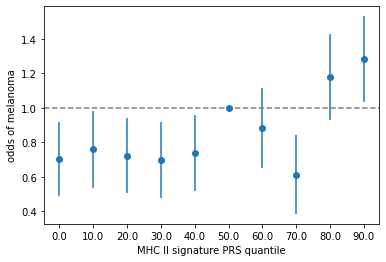

In [49]:
plt.errorbar(x=geneva_odds["quant"].tolist(),y=geneva_odds["odds"].tolist(),yerr=geneva_odds["se"].tolist(),fmt="o")
plt.xlabel("MHC II signature PRS quantile")
plt.ylabel("odds of melanoma")
plt.axhline(1,linestyle="--",color="gray")
plt.savefig("../plots/fig5/mhcII.fh.geneva.quantile.pdf")

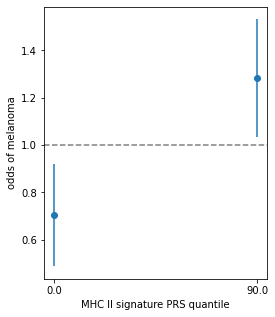

In [51]:
geneva_odds_filt=geneva_odds[geneva_odds["quant"].isin(["0.0","90.0"])]
f=plt.figure(figsize=(4,5))
plt.errorbar(x=geneva_odds_filt["quant"].tolist(),y=geneva_odds_filt["odds"].tolist(),yerr=geneva_odds_filt["se"].tolist(),fmt="o")
plt.xlabel("MHC II signature PRS quantile")
plt.ylabel("odds of melanoma")
plt.axhline(1,linestyle="--",color="gray")
plt.savefig("../plots/fig5/mhcII.fh.geneva.quantile.pdf")

In [52]:
#get cell type information

In [53]:
group1_mhcII_sumstats.head()

,ID,A1,OR,Outcome
9,5:96374150:A:G,A,1.049420,C43-C44
10,5:96374150:A:G,A,1.049420,C43-C44
11,1:151119769:T:A,T,0.913677,C43-C44
12,5:96200770:T:A,T,1.039710,C43-C44
14,1:150597890:A:G,A,1.046310,C43-C44


In [54]:
melanoma_prs_snps=snps[snps["proxy_variant"].isin(group1_mhcII_sumstats["ID"].tolist()+[x.rsplit(":",2)[0]+":"+x.split(":")[3]+":"+x.split(":")[2] for x in group1_mhcII_sumstats["ID"].tolist()])]["proxy_snp"].tolist()

In [55]:
len(melanoma_prs_snps)

52

In [56]:
cell=pd.read_csv("../data/supplemental/Supplemental_Table_10.csv")
cell["snp"]=cell["assoc"].str.split("_").str[0]

In [57]:
len(cell[(cell["snp"].isin(melanoma_prs_snps))&(cell["cell"]=="Macrophages")]["snp"].unique())

10

In [58]:
len(cell[(cell["snp"].isin(melanoma_prs_snps))&(cell["cell"]=="CD8+ T cells")]["snp"].unique())

10

In [59]:
cell

,assoc,cell,type,snp
0,rs1193692_CTSW,B-cells,ieqtl,rs1193692
1,rs61802301_FCGR2B,B-cells,ieqtl,rs61802301
2,rs9380306_HLA-DQA2,B-cells,ieqtl,rs9380306
3,rs9272546_HLA-DQA2,B-cells,ieqtl,rs9272546
4,rs521539_HLA-DQA2,B-cells,ieqtl,rs521539
...,...,...,...,...
217,rs34843907_HLA-DQA1,Monocytes,dice,rs34843907
218,rs9273242_HLA-DQB2,Monocytes,dice,rs9273242
219,rs17612852_HLA-DQB1,Monocytes,dice,rs17612852
220,rs3134996_HLA-DQA2,Monocytes,dice,rs3134996


In [74]:
prostate_group1_sumstats=ukbb_annot[(ukbb_annot["Outcome"]=="C60-C63")&(ukbb_annot["group"]=="group1")][["proxy_variant","ukbb_a1","Var1_OR","Outcome"]]
prostate_group1_sumstats.columns=["ID","A1","OR","Outcome"]
prostate_mhcII_sumstats=ukbb_annot[(ukbb_annot["Outcome"]=="C60-C63")&(ukbb_annot["file"]=="Sigs160-Wolf_MHC2-21978456")][["proxy_variant","ukbb_a1","Var1_OR","Outcome"]]
prostate_mhcII_sumstats.columns=["ID","A1","OR","Outcome"]
prostate_sumstats=prostate_group1_sumstats.append(prostate_mhcII_sumstats)
prostate_sumstats=prostate_sumstats.drop_duplicates()
prostate_prs=make_ukbb_prs("../data/ukbb/time-snp/dosage-multi/ukbb_bialleleic.raw",prostate_sumstats,prostate_sumstats["ID"].tolist())
icd=pd.read_csv("/cellar/users/mpagadal/data/ukbb/plato_input/immune_cancer_lev1_pheno.txt",delim_whitespace=True)
prostate_prs=pd.merge(prostate_prs,icd,on="IID",how="left")

11 PRS snps
loading 11 snps
['6:32651641:G:T_T', '6:31239896:T:C_C', '6:29921773:C:T_T', '5:96004344:C:T_T', '6:32634243:G:A_A', '6:31321578:G:A_A', '1:150658287:A:G_G', '6:29909372:C:G_G', '6:29910358:C:G_G', '6:32659609:T:C_C', '6:31783507:G:C_C']
0 snps missing weight
switching 11 genotypes


In [75]:
prostate_prs_snps=snps[snps["proxy_variant"].isin(prostate_sumstats["ID"].tolist()+[x.rsplit(":",2)[0]+":"+x.split(":")[3]+":"+x.split(":")[2] for x in prostate_sumstats["ID"].tolist()])]["proxy_snp"].tolist()

In [76]:
cell[cell["snp"].isin(prostate_prs_snps)]["cell"].value_counts()

Dendritic cells    2
Macrophages        2
CD4+ T cells       2
Erythrocytes       1
CD8+ T cells       1
NK                 1
B-cells            1
Monocytes          1
Name: cell, dtype: int64

In [77]:
cell[cell["snp"].isin(prostate_prs_snps)]["snp"].unique()

array(['rs9274514', 'rs3134977', 'rs2074491', 'rs9260555'], dtype=object)

In [78]:
prostate_prs["prostate"]=prostate_prs["C60-C63"]
prostate_odds=quantile_plot(prostate_prs,"prostate ~ group + AGE + SEX + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10",10,"logistic")

<ipython-input-6-b86c29504aba>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt["group"]=np.where(df_filt["FID"].isin(cases),1,0)


1    142425
0    115227
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.074662
         Iterations 12
1    141721
0    115227
Name: group, dtype: int64


<ipython-input-6-b86c29504aba>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt["group"]=np.where(df_filt["FID"].isin(cases),1,0)


Optimization terminated successfully.
         Current function value: 0.075580
         Iterations 12
1    137032
0    115227
Name: group, dtype: int64


<ipython-input-6-b86c29504aba>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt["group"]=np.where(df_filt["FID"].isin(cases),1,0)


Optimization terminated successfully.
         Current function value: 0.075361
         Iterations 12
1    141567
0    115227
Name: group, dtype: int64


<ipython-input-6-b86c29504aba>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt["group"]=np.where(df_filt["FID"].isin(cases),1,0)


Optimization terminated successfully.
         Current function value: 0.076973
         Iterations 12
1    142690
0    115227
Name: group, dtype: int64


<ipython-input-6-b86c29504aba>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt["group"]=np.where(df_filt["FID"].isin(cases),1,0)


Optimization terminated successfully.
         Current function value: 0.077062
         Iterations 12
1    140283
0     91781
Name: group, dtype: int64


<ipython-input-6-b86c29504aba>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt["group"]=np.where(df_filt["FID"].isin(cases),1,0)


1    143821
0     91207
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.077139
         Iterations 12
1    139694
0     96764
Name: group, dtype: int64


<ipython-input-6-b86c29504aba>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt["group"]=np.where(df_filt["FID"].isin(cases),1,0)


Optimization terminated successfully.
         Current function value: 0.077080
         Iterations 12
1    141771
0     94911
Name: group, dtype: int64


<ipython-input-6-b86c29504aba>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt["group"]=np.where(df_filt["FID"].isin(cases),1,0)


Optimization terminated successfully.
         Current function value: 0.077623
         Iterations 12
1    144908
0     93691
Name: group, dtype: int64


<ipython-input-6-b86c29504aba>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt["group"]=np.where(df_filt["FID"].isin(cases),1,0)


Optimization terminated successfully.
         Current function value: 0.077887
         Iterations 12


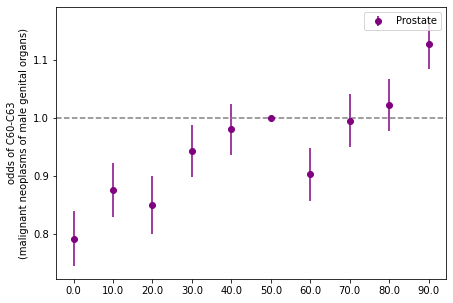

In [79]:
f=plt.figure(figsize=(7,5))
plt.errorbar(x=prostate_odds["quant"].tolist(),y=prostate_odds["odds"].tolist(),yerr=prostate_odds["se"].tolist(),fmt="o",color="purple",label="Prostate")
plt.ylabel("quantile")
plt.ylabel("odds of C60-C63\n(malignant neoplasms of male genital organs)")
plt.axhline(1,linestyle="--",color="gray")
plt.legend()
plt.savefig("../plots/fig5/ukbb.prostate.quantile.pdf")

In [80]:
prostate_group1_sumstats[prostate_group1_sumstats["ID"].isin(group1_mhcII_sumstats["ID"].tolist())]

,ID,A1,OR,Outcome
104,1:150658287:A:G,A,0.934438,C60-C63


#### Validation

In [81]:
ellipse_prs=make_ukbb_prs("../data/genotypes/ellipse/ellipse.raw",prostate_sumstats,prostate_sumstats["ID"].tolist())
#add phenotyping
pheno=pd.read_csv("/cellar/controlled/dbgap-genetic/phs001120.v1.p1_ellipse/phenotypes/pheno_affection_status.txt",delimiter="\t",header=None)
pheno[2]=pheno[2].map({1:0,2:1})
mp_pheno=dict(zip(pheno[1],pheno[2]))
ellipse_prs["pheno"]=ellipse_prs["IID"].map(mp_pheno)
cov=pd.read_csv("/cellar/controlled/dbgap-genetic/phs001120.v1.p1_ellipse/covs/age-pcs-fh",delimiter="\t")
ellipse_prs=pd.merge(ellipse_prs,cov,on="IID",how="left")
ellipse_prs["FH_PROS"]=ellipse_prs["FH_PROS"].replace(-9,0)

ellipse_prs["FID"]=ellipse_prs["IID"]

violinplot

11 PRS snps
loading 11 snps
['6:32651641:G:T_T', '6:31239896:T:C_C', '6:29921773:T:C_T', '5:96004344:C:T_T', '6:32634243:G:A_A', '6:31321578:A:G_A', '1:150658287:A:G_G', '6:29909372:C:G_C', '6:29910358:C:G_C', '6:32659609:T:C_C', '6:31783507:G:C_G']
0 snps missing weight
switching 8 genotypes


In [82]:
ellipse_prs["FID"]=ellipse_prs["IID"]
ellipse_odds=quantile_plot(ellipse_prs,"pheno ~ group + age + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10",10,"logistic")

<ipython-input-6-b86c29504aba>:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  controls=df[(df["PRS"]>df["PRS"].quantile(int(num/2)*(1/num)))&(group1_prs["PRS"]<group1_prs["PRS"].quantile(int(num/2)*(1/num)+(1/(num))))]["FID"].tolist()
<ipython-input-6-b86c29504aba>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt["group"]=np.where(df_filt["FID"].isin(cases),1,0)


0    27031
1     8730
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.627846
         Iterations 6


<ipython-input-6-b86c29504aba>:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  controls=df[(df["PRS"]>df["PRS"].quantile(int(num/2)*(1/num)))&(group1_prs["PRS"]<group1_prs["PRS"].quantile(int(num/2)*(1/num)+(1/(num))))]["FID"].tolist()
<ipython-input-6-b86c29504aba>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt["group"]=np.where(df_filt["FID"].isin(cases),1,0)


0    27031
1     8446
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.628889
         Iterations 6


<ipython-input-6-b86c29504aba>:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  controls=df[(df["PRS"]>df["PRS"].quantile(int(num/2)*(1/num)))&(group1_prs["PRS"]<group1_prs["PRS"].quantile(int(num/2)*(1/num)+(1/(num))))]["FID"].tolist()
<ipython-input-6-b86c29504aba>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt["group"]=np.where(df_filt["FID"].isin(cases),1,0)


0    27031
1     8675
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.629016
         Iterations 6


<ipython-input-6-b86c29504aba>:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  controls=df[(df["PRS"]>df["PRS"].quantile(int(num/2)*(1/num)))&(group1_prs["PRS"]<group1_prs["PRS"].quantile(int(num/2)*(1/num)+(1/(num))))]["FID"].tolist()
<ipython-input-6-b86c29504aba>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt["group"]=np.where(df_filt["FID"].isin(cases),1,0)


0    27031
1     8352
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.629683
         Iterations 6


<ipython-input-6-b86c29504aba>:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  controls=df[(df["PRS"]>df["PRS"].quantile(int(num/2)*(1/num)))&(group1_prs["PRS"]<group1_prs["PRS"].quantile(int(num/2)*(1/num)+(1/(num))))]["FID"].tolist()
<ipython-input-6-b86c29504aba>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt["group"]=np.where(df_filt["FID"].isin(cases),1,0)


0    27031
1     6775
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.627535
         Iterations 6


<ipython-input-6-b86c29504aba>:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  controls=df[(df["PRS"]>df["PRS"].quantile(int(num/2)*(1/num)))&(group1_prs["PRS"]<group1_prs["PRS"].quantile(int(num/2)*(1/num)+(1/(num))))]["FID"].tolist()
<ipython-input-6-b86c29504aba>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt["group"]=np.where(df_filt["FID"].isin(cases),1,0)


0    21970
1     8354
Name: group, dtype: int64
0    21859
1     8683
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.626779
         Iterations 6


<ipython-input-6-b86c29504aba>:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  controls=df[(df["PRS"]>df["PRS"].quantile(int(num/2)*(1/num)))&(group1_prs["PRS"]<group1_prs["PRS"].quantile(int(num/2)*(1/num)+(1/(num))))]["FID"].tolist()
<ipython-input-6-b86c29504aba>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt["group"]=np.where(df_filt["FID"].isin(cases),1,0)


0    22546
1     7503
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.626594
         Iterations 6


<ipython-input-6-b86c29504aba>:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  controls=df[(df["PRS"]>df["PRS"].quantile(int(num/2)*(1/num)))&(group1_prs["PRS"]<group1_prs["PRS"].quantile(int(num/2)*(1/num)+(1/(num))))]["FID"].tolist()
<ipython-input-6-b86c29504aba>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt["group"]=np.where(df_filt["FID"].isin(cases),1,0)


0    21751
1     8843
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.626177
         Iterations 6
0    21562
1     9069
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.625181
         Iterations 6


<ipython-input-6-b86c29504aba>:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  controls=df[(df["PRS"]>df["PRS"].quantile(int(num/2)*(1/num)))&(group1_prs["PRS"]<group1_prs["PRS"].quantile(int(num/2)*(1/num)+(1/(num))))]["FID"].tolist()
<ipython-input-6-b86c29504aba>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt["group"]=np.where(df_filt["FID"].isin(cases),1,0)


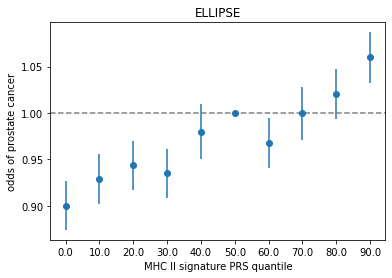

In [83]:
plt.errorbar(x=ellipse_odds["quant"].tolist(),y=ellipse_odds["odds"].tolist(),yerr=ellipse_odds["se"].tolist(),fmt="o")
plt.xlabel("MHC II signature PRS quantile")
plt.ylabel("odds of prostate cancer")
plt.axhline(1,linestyle="--",color="gray")
plt.title("ELLIPSE")
plt.savefig("../plots/fig5/ellipse.prostate.quantile.pdf")

In [84]:
ellipse_odds_filt=ellipse_odds[ellipse_odds["quant"].isin(["0.0","90.0"])]

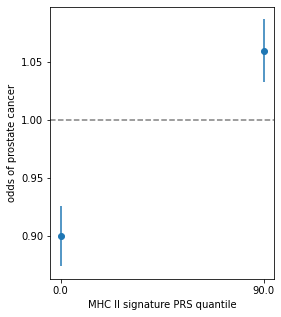

In [85]:
f=plt.figure(figsize=(4,5))
plt.errorbar(x=ellipse_odds_filt["quant"].tolist(),y=ellipse_odds_filt["odds"].tolist(),yerr=ellipse_odds_filt["se"].tolist(),fmt="o")
plt.xlabel("MHC II signature PRS quantile")
plt.ylabel("odds of prostate cancer")
plt.axhline(1,linestyle="--",color="gray")
plt.savefig("../plots/fig5/ellipse.prostate.quantile.pdf")

In [88]:
ethnic=pd.read_csv("/nrnbold/users/mpagadal/oncoarray/phenotypes/oncoarray_subject_phenotypes.txt",delimiter="\t")

In [96]:
eur_pts=ethnic[ethnic["ETHNICITY"]=="European"]["IID"].tolist()
afr_pts=ethnic[ethnic["ETHNICITY"]=="African Ancestry"]["IID"].tolist()

In [97]:
ellipse_prs_eur=ellipse_prs[ellipse_prs["IID"].isin(eur_pts)]
ellipse_prs_afr=ellipse_prs[ellipse_prs["IID"].isin(afr_pts)]

In [100]:
ellipse_odds_eur=quantile_plot(ellipse_prs_eur,"pheno ~ group + age + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10",10,"logistic")
ellipse_odds_afr=quantile_plot(ellipse_prs_afr,"pheno ~ group + age + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10",10,"logistic")

<ipython-input-6-b86c29504aba>:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  controls=df[(df["PRS"]>df["PRS"].quantile(int(num/2)*(1/num)))&(group1_prs["PRS"]<group1_prs["PRS"].quantile(int(num/2)*(1/num)+(1/(num))))]["FID"].tolist()
<ipython-input-6-b86c29504aba>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt["group"]=np.where(df_filt["FID"].isin(cases),1,0)


0    24658
1     7841
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.621187
         Iterations 6


<ipython-input-6-b86c29504aba>:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  controls=df[(df["PRS"]>df["PRS"].quantile(int(num/2)*(1/num)))&(group1_prs["PRS"]<group1_prs["PRS"].quantile(int(num/2)*(1/num)+(1/(num))))]["FID"].tolist()
<ipython-input-6-b86c29504aba>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt["group"]=np.where(df_filt["FID"].isin(cases),1,0)


0    24658
1     8193
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.621967
         Iterations 6


<ipython-input-6-b86c29504aba>:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  controls=df[(df["PRS"]>df["PRS"].quantile(int(num/2)*(1/num)))&(group1_prs["PRS"]<group1_prs["PRS"].quantile(int(num/2)*(1/num)+(1/(num))))]["FID"].tolist()
<ipython-input-6-b86c29504aba>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt["group"]=np.where(df_filt["FID"].isin(cases),1,0)


0    24658
1     8145
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.621501
         Iterations 6


<ipython-input-6-b86c29504aba>:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  controls=df[(df["PRS"]>df["PRS"].quantile(int(num/2)*(1/num)))&(group1_prs["PRS"]<group1_prs["PRS"].quantile(int(num/2)*(1/num)+(1/(num))))]["FID"].tolist()
<ipython-input-6-b86c29504aba>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt["group"]=np.where(df_filt["FID"].isin(cases),1,0)


0    24658
1     6949
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.621337
         Iterations 6


<ipython-input-6-b86c29504aba>:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  controls=df[(df["PRS"]>df["PRS"].quantile(int(num/2)*(1/num)))&(group1_prs["PRS"]<group1_prs["PRS"].quantile(int(num/2)*(1/num)+(1/(num))))]["FID"].tolist()
<ipython-input-6-b86c29504aba>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt["group"]=np.where(df_filt["FID"].isin(cases),1,0)


0    24658
1     7562
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.619993
         Iterations 6


<ipython-input-6-b86c29504aba>:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  controls=df[(df["PRS"]>df["PRS"].quantile(int(num/2)*(1/num)))&(group1_prs["PRS"]<group1_prs["PRS"].quantile(int(num/2)*(1/num)+(1/(num))))]["FID"].tolist()
<ipython-input-6-b86c29504aba>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt["group"]=np.where(df_filt["FID"].isin(cases),1,0)


0    19730
1     8159
Name: group, dtype: int64
0    20428
1     7061
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.619803
         Iterations 6


<ipython-input-6-b86c29504aba>:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  controls=df[(df["PRS"]>df["PRS"].quantile(int(num/2)*(1/num)))&(group1_prs["PRS"]<group1_prs["PRS"].quantile(int(num/2)*(1/num)+(1/(num))))]["FID"].tolist()
<ipython-input-6-b86c29504aba>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt["group"]=np.where(df_filt["FID"].isin(cases),1,0)


0    19804
1     8122
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.619889
         Iterations 6


<ipython-input-6-b86c29504aba>:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  controls=df[(df["PRS"]>df["PRS"].quantile(int(num/2)*(1/num)))&(group1_prs["PRS"]<group1_prs["PRS"].quantile(int(num/2)*(1/num)+(1/(num))))]["FID"].tolist()
<ipython-input-6-b86c29504aba>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt["group"]=np.where(df_filt["FID"].isin(cases),1,0)


0    19973
1     7834
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.619341
         Iterations 6


<ipython-input-6-b86c29504aba>:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  controls=df[(df["PRS"]>df["PRS"].quantile(int(num/2)*(1/num)))&(group1_prs["PRS"]<group1_prs["PRS"].quantile(int(num/2)*(1/num)+(1/(num))))]["FID"].tolist()
<ipython-input-6-b86c29504aba>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt["group"]=np.where(df_filt["FID"].isin(cases),1,0)


0    20085
1     7626
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.618666
         Iterations 6


<ipython-input-6-b86c29504aba>:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  controls=df[(df["PRS"]>df["PRS"].quantile(int(num/2)*(1/num)))&(group1_prs["PRS"]<group1_prs["PRS"].quantile(int(num/2)*(1/num)+(1/(num))))]["FID"].tolist()
<ipython-input-6-b86c29504aba>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt["group"]=np.where(df_filt["FID"].isin(cases),1,0)


0    1915
1     649
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.685985
         Iterations 5


<ipython-input-6-b86c29504aba>:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  controls=df[(df["PRS"]>df["PRS"].quantile(int(num/2)*(1/num)))&(group1_prs["PRS"]<group1_prs["PRS"].quantile(int(num/2)*(1/num)+(1/(num))))]["FID"].tolist()
<ipython-input-6-b86c29504aba>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt["group"]=np.where(df_filt["FID"].isin(cases),1,0)


0    1915
1     627
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.685728
         Iterations 4


<ipython-input-6-b86c29504aba>:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  controls=df[(df["PRS"]>df["PRS"].quantile(int(num/2)*(1/num)))&(group1_prs["PRS"]<group1_prs["PRS"].quantile(int(num/2)*(1/num)+(1/(num))))]["FID"].tolist()
<ipython-input-6-b86c29504aba>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt["group"]=np.where(df_filt["FID"].isin(cases),1,0)


0    1915
1     536
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.686065
         Iterations 4


<ipython-input-6-b86c29504aba>:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  controls=df[(df["PRS"]>df["PRS"].quantile(int(num/2)*(1/num)))&(group1_prs["PRS"]<group1_prs["PRS"].quantile(int(num/2)*(1/num)+(1/(num))))]["FID"].tolist()
<ipython-input-6-b86c29504aba>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt["group"]=np.where(df_filt["FID"].isin(cases),1,0)


0    1915
1     534
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.685464
         Iterations 4


<ipython-input-6-b86c29504aba>:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  controls=df[(df["PRS"]>df["PRS"].quantile(int(num/2)*(1/num)))&(group1_prs["PRS"]<group1_prs["PRS"].quantile(int(num/2)*(1/num)+(1/(num))))]["FID"].tolist()
<ipython-input-6-b86c29504aba>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt["group"]=np.where(df_filt["FID"].isin(cases),1,0)


0    1915
1     529
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.685431
         Iterations 4


<ipython-input-6-b86c29504aba>:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  controls=df[(df["PRS"]>df["PRS"].quantile(int(num/2)*(1/num)))&(group1_prs["PRS"]<group1_prs["PRS"].quantile(int(num/2)*(1/num)+(1/(num))))]["FID"].tolist()
<ipython-input-6-b86c29504aba>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt["group"]=np.where(df_filt["FID"].isin(cases),1,0)


0    1556
1     622
Name: group, dtype: int64
0    1574
1     562
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.685987
         Iterations 4


<ipython-input-6-b86c29504aba>:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  controls=df[(df["PRS"]>df["PRS"].quantile(int(num/2)*(1/num)))&(group1_prs["PRS"]<group1_prs["PRS"].quantile(int(num/2)*(1/num)+(1/(num))))]["FID"].tolist()
<ipython-input-6-b86c29504aba>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt["group"]=np.where(df_filt["FID"].isin(cases),1,0)


0    1588
1     540
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.685551
         Iterations 4


<ipython-input-6-b86c29504aba>:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  controls=df[(df["PRS"]>df["PRS"].quantile(int(num/2)*(1/num)))&(group1_prs["PRS"]<group1_prs["PRS"].quantile(int(num/2)*(1/num)+(1/(num))))]["FID"].tolist()
<ipython-input-6-b86c29504aba>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt["group"]=np.where(df_filt["FID"].isin(cases),1,0)


0    1538
1     648
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.684349
         Iterations 4
0    1531
1     645
Name: group, dtype: int64
Optimization terminated successfully.
         Current function value: 0.685039
         Iterations 4


<ipython-input-6-b86c29504aba>:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  controls=df[(df["PRS"]>df["PRS"].quantile(int(num/2)*(1/num)))&(group1_prs["PRS"]<group1_prs["PRS"].quantile(int(num/2)*(1/num)+(1/(num))))]["FID"].tolist()
<ipython-input-6-b86c29504aba>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt["group"]=np.where(df_filt["FID"].isin(cases),1,0)


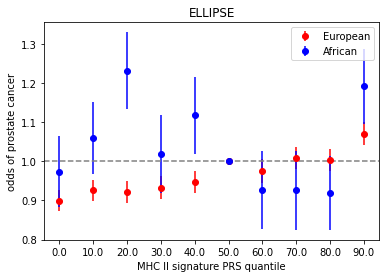

In [104]:
plt.errorbar(x=ellipse_odds_eur["quant"].tolist(),y=ellipse_odds_eur["odds"].tolist(),yerr=ellipse_odds_eur["se"].tolist(),fmt="o",color="red",label="European")
plt.errorbar(x=ellipse_odds_afr["quant"].tolist(),y=ellipse_odds_afr["odds"].tolist(),yerr=ellipse_odds_afr["se"].tolist(),fmt="o",color="blue",label="African")

plt.xlabel("MHC II signature PRS quantile")
plt.ylabel("odds of prostate cancer")
plt.axhline(1,linestyle="--",color="gray")
plt.title("ELLIPSE")
plt.legend()

plt.savefig("../plots/fig5/ellipse.prostate.eur.afr.quantile.pdf")

In [121]:
# f=plt.figure(figsize=(4,5))
# ax=sns.violinplot(x="pheno",y="PRS",data=ellipse_prs_eur)
# cat1 = ellipse_prs_eur[(ellipse_prs_eur["pheno"]==0)]
# cat2 = ellipse_prs_eur[(ellipse_prs_eur["pheno"]==1)]

# labels=[item.get_text() for item in ax.get_xticklabels()]
# labels=[x+" ("+str(len(ellipse_prs_eur[ellipse_prs_eur["pheno"]==float(x)]))+")" for x in labels]
# ax.set_xticklabels(labels)

# plt.title("ELLIPSE n="+str(len(ellipse_prs_eur))+"\n"+str(mannwhitneyu(cat1["PRS"], cat2["PRS"])[1]))
# mannwhitneyu(cat1["PRS"], cat2["PRS"])[1]
# plt.savefig("../plots/fig5/ellipse.prs.pdf")

check association with cibersortx infiltration

In [172]:
tcga_group1_prs,x=make_ukbb_prs("/cellar/users/mpagadal/projects/germline-immune/data/genotypes/all.time.raw",group1_mhcII_sumstats,group1_mhcII_sumstats["ID"].tolist())

124 PRS snps
0 snps missing weight
switching 108 genotypes


In [174]:
x

,TCGA-01-0628,TCGA-01-0630,TCGA-01-0633,TCGA-01-0636,TCGA-01-0637,TCGA-01-0639,TCGA-01-0642,TCGA-02-0001,TCGA-02-0003,TCGA-02-0006,...,TCGA-ZP-A9D2,TCGA-ZP-A9D4,TCGA-ZQ-A9CR,TCGA-ZR-A9CJ,TCGA-ZS-A9CD,TCGA-ZS-A9CE,TCGA-ZS-A9CF,TCGA-ZS-A9CG,TCGA-ZU-A8S4,TCGA-ZX-AA5X
11:65477306,0.035258,0.070516,0.070516,0.070516,0.000000,0.070516,0.000000,0.035258,0.000000,0.070516,...,0.035258,0.035258,0.070516,0.035258,0.035258,0.035258,0.000000,0.070516,0.035258,0.035258
1:161388413,0.050389,0.050389,0.050389,0.050389,0.050389,0.000000,0.050389,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.050389,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1:150456350,0.000000,0.000000,0.049070,0.098141,0.098141,0.049070,0.000000,0.000000,0.049070,0.000000,...,0.000000,0.000000,0.049070,0.000000,0.049070,0.049070,0.049070,0.000000,0.049070,0.000000
11:65585257,0.074061,0.074061,0.074061,0.037031,0.037031,0.037031,0.037031,0.037031,0.037031,0.074061,...,0.037031,0.037031,0.037031,0.000000,0.037031,0.037031,0.000000,0.037031,0.037031,0.037031
5:96374150,0.069592,0.139184,0.139184,0.139184,0.139184,0.069592,0.069592,0.069592,0.139184,0.139184,...,0.139184,0.069592,0.139184,0.000000,0.139184,0.069592,0.139184,0.139184,0.139184,0.069592
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6:32592796,0.176935,0.176935,0.088467,0.176935,0.088467,0.088467,0.176935,0.176935,0.176935,0.088467,...,0.176935,0.088467,0.176935,0.176935,0.176935,0.176935,0.088467,0.176935,0.176935,0.176935
6:32582194,0.000000,0.118043,0.059021,0.059021,0.000000,0.059021,0.000000,0.059021,0.000000,0.000000,...,0.118043,0.000000,0.059021,0.059021,0.000000,0.118043,0.000000,0.059021,0.000000,0.000000
6:32584625,0.139264,0.000000,0.000000,0.000000,0.000000,0.000000,0.069632,0.000000,0.069632,0.069632,...,0.069632,0.000000,0.069632,0.000000,0.069632,0.000000,0.069632,0.000000,0.000000,0.139264
6:32581582,0.133790,0.133790,0.133790,0.066895,0.066895,0.133790,0.066895,0.066895,0.000000,0.000000,...,0.133790,0.066895,0.066895,0.066895,0.000000,0.133790,0.133790,0.066895,0.000000,0.000000


,FID,IID,C1,C2,C3,C4,C5,C6,C7,C8,...,TISSUE_21,TISSUE_24,TISSUE_8,TISSUE_26,TISSUE_12,TISSUE_9,TISSUE_28,TISSUE_0,TISSUE_19,TISSUE_29
0,TCGA-01-0628,TCGA-01-0628,-0.029151,0.010055,0.003451,-0.000455,-0.000731,-0.002889,0.000913,-0.002270,...,0,0,0,0,0,0,0,0,0,0
1,TCGA-01-0630,TCGA-01-0630,-0.032295,0.008237,0.004207,-0.001678,0.001649,-0.004889,0.000780,0.001690,...,0,0,0,0,0,0,0,0,0,0
2,TCGA-01-0633,TCGA-01-0633,-0.031724,0.007415,0.005220,0.000963,0.002030,-0.003924,-0.000987,0.000943,...,0,0,0,0,0,0,0,0,0,0
3,TCGA-01-0636,TCGA-01-0636,-0.026123,0.008766,0.004780,0.005326,0.002076,-0.007119,0.001319,-0.001768,...,0,0,0,0,0,0,0,0,0,0
4,TCGA-01-0637,TCGA-01-0637,-0.028613,0.010156,0.007154,0.003382,-0.002132,-0.002361,0.003855,0.001674,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8277,TCGA-ZS-A9CE,TCGA-ZS-A9CE,-0.029030,0.009857,0.003363,0.004224,0.001063,-0.008216,-0.004821,-0.001233,...,0,0,0,0,0,0,0,0,0,0
8278,TCGA-ZS-A9CF,TCGA-ZS-A9CF,-0.028729,0.011772,0.009607,0.001511,0.001386,-0.009847,-0.002474,-0.001632,...,0,0,0,0,0,0,0,0,0,0
8279,TCGA-ZS-A9CG,TCGA-ZS-A9CG,-0.028792,0.011405,0.005767,0.002667,-0.000797,-0.007900,-0.000899,-0.002227,...,0,0,0,0,0,0,0,0,0,0
8280,TCGA-ZU-A8S4,TCGA-ZU-A8S4,-0.029592,0.010647,0.004976,0.000644,0.002022,-0.002869,-0.000893,0.000518,...,0,0,0,0,0,0,0,0,0,0


In [124]:
#map to cancer type
tcga_group1_prs,x=make_ukbb_prs("/cellar/users/mpagadal/projects/germline-immune/data/genotypes/all.time.raw",group1_mhcII_sumstats,group1_mhcII_sumstats["ID"].tolist())
cov=pd.read_csv("/cellar/users/mpagadal/projects/germline-immune/data/plink-associations/cov/immune.filt.cov",delim_whitespace=True)
tcga_group1_prs=pd.merge(tcga_group1_prs,cov,on="IID",how="left")
canc = pd.read_csv("/cellar/controlled/dbgap-genetic/phs000178_TCGA/birdseed-processing/gtype.meta", delimiter="\t", header=None)
mp = canc.set_index(2)[0].to_dict()
tcga_group1_prs["cancer"]=tcga_group1_prs["FID"].map(mp)

In [93]:
# for x in cov.columns[13:-29]:
#     tcga_group1_prs_clean=tcga_group1_prs[tcga_group1_prs[x]!=-9]
#     tcga_group1_prs_clean=tcga_group1_prs_clean[tcga_group1_prs_clean["cancer"]=="PRAD"]
#     f=plt.figure(figsize=(4,5))
#     plt.scatter(tcga_group1_prs_clean["PRS"],tcga_group1_prs_clean[x])
#     plt.title(x+"\n"+str(tcga_group1_prs_clean["PRS"].corr(tcga_group1_prs_clean[x])))

check association with Sayaman et al Signatures

In [126]:
sayaman_sig=pd.read_csv("/cellar/users/mpagadal/projects/germline-immune/data/sayaman/Scores_160_Signatures.tsv.gz",delimiter="\t")
del sayaman_sig["Source"]
sayaman_sig=sayaman_sig.set_index("SetName")

In [127]:
sayaman_sig=sayaman_sig.T.reset_index()

In [128]:
sayaman_sig["code"]=sayaman_sig["index"].str.split("-").str[3]

In [129]:
sayaman_sig["code"].value_counts()

01A    9004
01B     121
01C       4
Name: code, dtype: int64

In [130]:
sayaman_sig["IID"]=sayaman_sig["index"].str.rsplit("-",4).str[0]

In [131]:
tcga_group1_prs=make_ukbb_prs("../data/genotypes/all.time.raw",group1_mhcII_sumstats,group1_mhcII_sumstats["ID"].tolist())
tcga_group1_prs=pd.merge(tcga_group1_prs,sayaman_sig,on="IID",how="left")

52 PRS snps
loading 52 snps
['5:96374150:A:G_G', '5:96374150:A:G_G', '1:151119769:T:A_A', '5:96200770:T:A_A', '1:150597890:A:G_G', '6:32438298:A:G_G', '6:32606941:C:T_T', '6:32605295:C:T_T', '5:96230122:T:G_G', '6:32592605:T:A_A', '1:150861859:C:T_T', '5:96115721:T:C_C', '1:150130096:G:A_A', '6:32581973:G:A_A', '6:32614080:C:T_T', '5:96069295:G:A_A', '5:96069295:G:A_A', '5:96373750:A:G_G', '5:96152436:G:C_C', '5:96152436:G:C_C', '6:32658935:A:G_G', '6:32580657:T:C_C', '6:32580657:T:C_C', '11:65493807:T:C_C', '1:150467096:T:A_A', '1:150658287:A:G_G', '6:32636351:T:C_C', '1:150958977:T:C_C', '1:150635066:C:T_T', '6:32395036:T:C_C', '6:32660784:G:C_C', '11:65394322:A:G_G', '6:32796793:G:A_A', '6:32636866:T:A_A', '5:96229272:G:A_A', '5:96229272:G:A_A', '11:65712413:A:G_G', '1:150878649:C:T_T', '1:150737220:A:G_G', '5:96293021:G:A_A', '6:32610059:G:T_T', '11:65580638:T:G_G', '1:150618632:C:A_A', '6:32586908:A:G_G', '6:32634405:T:C_C', '6:32692735:T:A_A', '6:32575658:G:C_C', '6:32683121:A:G_

In [132]:
#map to cancer type
canc = pd.read_csv("/cellar/controlled/dbgap-genetic/phs000178_TCGA/birdseed-processing/gtype.meta", delimiter="\t", header=None)
mp = canc.set_index(2)[0].to_dict()
tcga_group1_prs["cancer"]=tcga_group1_prs["IID"].map(mp)

In [133]:
signature=[]
corr=[]

for x in sayaman_sig.columns[2:-2]:
    tcga_group1_prs_skcm=tcga_group1_prs[tcga_group1_prs["cancer"]=="SKCM"]
    signature.append(x)
    corr.append(tcga_group1_prs_skcm["PRS"].corr(tcga_group1_prs_skcm[x]))

In [134]:
df_corr=pd.DataFrame({"signature":signature,"pearson":corr})

In [135]:
df_corr.sort_values(by="pearson",ascending=False).head()

,signature,pearson
66,TAMsurr_TcClassII_ratio,0.242265
50,LYMPHS_PCA_16704732,0.240403
93,C7_Atom_12,0.209450
154,Macrophages.M2,0.194696
26,IL8_21978456,0.192385


In [136]:
tcga_prostate_prs=make_ukbb_prs("../data/genotypes/all.time.raw",prostate_sumstats,prostate_sumstats["ID"].tolist())
tcga_prostate_prs=pd.merge(tcga_prostate_prs,sayaman_sig,on="IID",how="left")
tcga_prostate_prs["cancer"]=tcga_prostate_prs["IID"].map(mp)

11 PRS snps
loading 11 snps
['6:32651641:G:T_T', '6:31239896:T:C_C', '6:29921773:C:T_T', '5:96004344:C:T_T', '6:32634243:G:A_A', '6:31321578:G:A_A', '1:150658287:A:G_G', '6:29909372:G:C_C', '6:29910358:G:C_C', '6:32659609:T:C_C', '6:31783507:G:C_C']
0 snps missing weight
switching 9 genotypes


In [137]:
signature=[]
corr=[]

for x in sayaman_sig.columns[2:-2]:
    tcga_prostate_prs_prad=tcga_prostate_prs[tcga_prostate_prs["cancer"]=="PRAD"]
    signature.append(x)
    corr.append(tcga_prostate_prs_prad["PRS"].corr(tcga_prostate_prs_prad[x]))

In [138]:
df_corr=pd.DataFrame({"signature":signature,"pearson":corr})

In [139]:
df_corr.sort_values(by="pearson",ascending=False)["signature"].tolist()

['LYMPHS_PCA_16704732',
 'C7_Atom_24',
 'Mast.cells.activated',
 'PDL1_data',
 'T helper cells',
 'C7_Atom_26',
 'Cytotoxic cells',
 'T.cells.follicular.helper',
 'Tcm cells',
 'STAT1_19272155',
 'T.cells.CD8',
 'CD103pos_CD103neg_ratio_25446897',
 'Th2 cells',
 'MHC.I_19272155',
 'T.cells.CD4.naive',
 'T.cells.CD4.memory.resting',
 'Bcell_mg_IGJ',
 'PD1_PDL1_score',
 'TAMsurr_score',
 'C7_Atom_30',
 'MHC1_21978456',
 'C7_Atom_17',
 'TAMsurr_TcClassII_ratio',
 'NHI_5gene_score',
 'B.cells.naive',
 'TREM1_data',
 'ICR_ACT_SCORE',
 'CD8_CD68_ratio',
 'MHC2_21978456',
 'Chemokine12_score',
 'ICR_SCORE',
 'C7_Atom_7',
 'C7_Atom_27',
 'CD8A',
 'ICS5_score',
 'Minterferon_Cluster_21214954',
 'T cells',
 'Immune_NSCLC_score',
 'Macrophages.M1',
 'APM2',
 'ICR_INHIB_SCORE',
 'Th17 cells',
 'C7_Atom_18',
 'T.cells.gamma.delta',
 'CD8_PCA_16704732',
 'IL12_score_21050467',
 'C7_Atom_8',
 'C7_Atom_13',
 'C7_Atom_28',
 'C7_Atom_32',
 'C7_Atom_1',
 'IGG_Cluster_21214954',
 'IgG_19272155',
 'Module5

In [140]:
tcga_group1_prs=make_ukbb_prs("../data/genotypes/all.time.raw",group1_mhcII_sumstats,group1_mhcII_sumstats["ID"].tolist())

#get cibersortx data
ciber_lm22=pd.read_csv("../data/plink-associations/phenotypes/TCGA.Kallisto.fullIDs.cibersort.relative.tsv",delimiter="\t")
ciber_lm22["id"]=ciber_lm22["SampleID"].str.replace(".","-")
ciber_lm22["code"]=ciber_lm22["id"].str.rsplit("-",4).str[1]
ciber_lm22["id"]=ciber_lm22["id"].str.rsplit("-",4).str[0]
ciber_lm22=ciber_lm22[ciber_lm22["code"].str.contains("01")]
ciber_lm22.index=ciber_lm22["id"]
ciber_lm22=ciber_lm22[ciber_lm22.columns[2:-5].tolist()]
ciber_lm22=ciber_lm22.groupby(ciber_lm22.index).mean()
ciber_lm22=ciber_lm22.reset_index().rename(columns={"id":"IID"})

tcga_group1_prs=pd.merge(tcga_group1_prs,ciber_lm22,on="IID",how="left")

52 PRS snps
loading 52 snps
['5:96374150:A:G_G', '5:96374150:A:G_G', '1:151119769:T:A_A', '5:96200770:T:A_A', '1:150597890:A:G_G', '6:32438298:A:G_G', '6:32606941:C:T_T', '6:32605295:C:T_T', '5:96230122:T:G_G', '6:32592605:T:A_A', '1:150861859:C:T_T', '5:96115721:T:C_C', '1:150130096:G:A_A', '6:32581973:G:A_A', '6:32614080:C:T_T', '5:96069295:G:A_A', '5:96069295:G:A_A', '5:96373750:A:G_G', '5:96152436:G:C_C', '5:96152436:G:C_C', '6:32658935:A:G_G', '6:32580657:T:C_C', '6:32580657:T:C_C', '11:65493807:T:C_C', '1:150467096:T:A_A', '1:150658287:A:G_G', '6:32636351:T:C_C', '1:150958977:T:C_C', '1:150635066:C:T_T', '6:32395036:T:C_C', '6:32660784:G:C_C', '11:65394322:A:G_G', '6:32796793:G:A_A', '6:32636866:T:A_A', '5:96229272:G:A_A', '5:96229272:G:A_A', '11:65712413:A:G_G', '1:150878649:C:T_T', '1:150737220:A:G_G', '5:96293021:G:A_A', '6:32610059:G:T_T', '11:65580638:T:G_G', '1:150618632:C:A_A', '6:32586908:A:G_G', '6:32634405:T:C_C', '6:32692735:T:A_A', '6:32575658:G:C_C', '6:32683121:A:G_

<ipython-input-140-f9d7fca47aab>:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  ciber_lm22["id"]=ciber_lm22["SampleID"].str.replace(".","-")


In [141]:
#map to cancer type
canc = pd.read_csv("/cellar/controlled/dbgap-genetic/phs000178_TCGA/birdseed-processing/gtype.meta", delimiter="\t", header=None)
mp = canc.set_index(2)[0].to_dict()
tcga_group1_prs["cancer"]=tcga_group1_prs["IID"].map(mp)

<ipython-input-142-e76b96ba87b7>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f=plt.figure(figsize=(5,5))


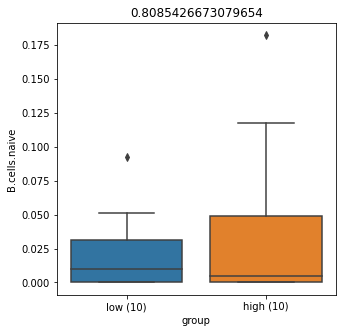

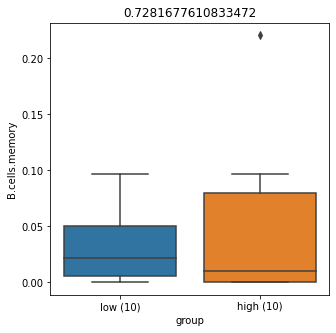

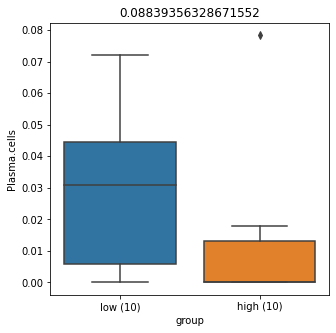

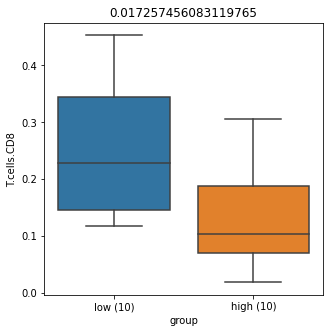

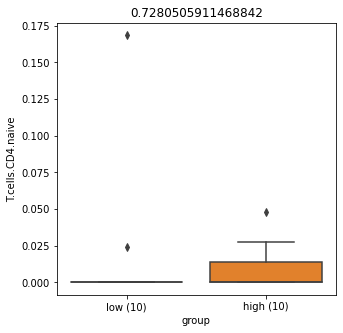

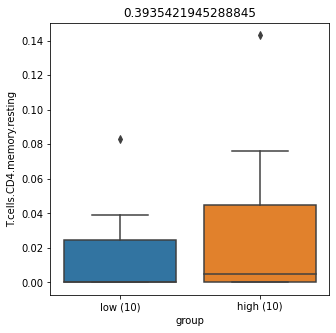

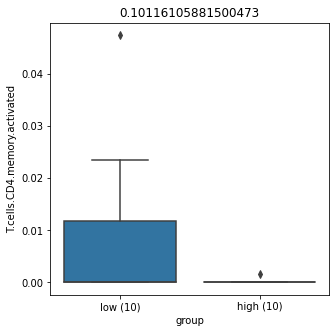

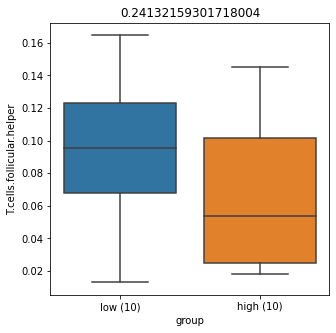

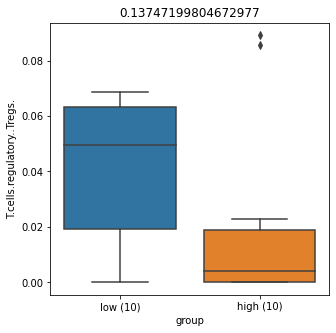

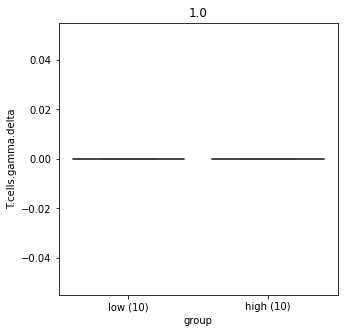

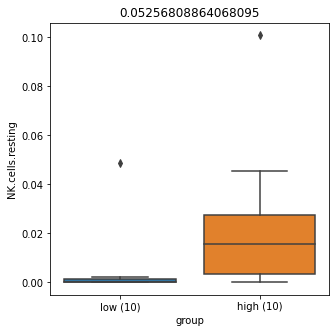

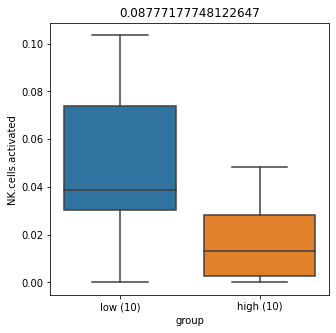

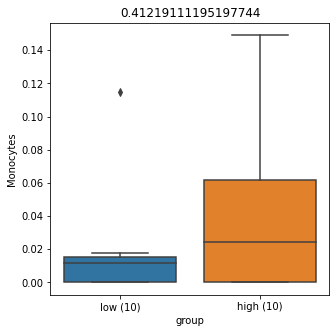

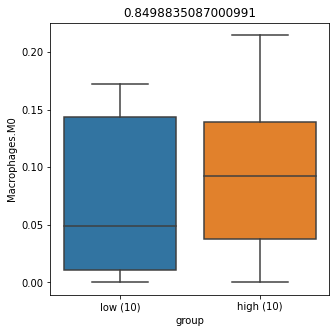

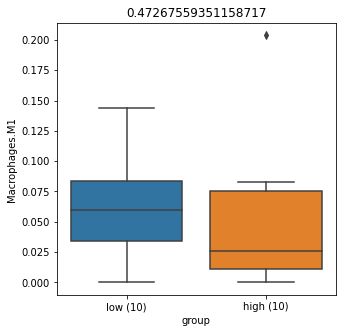

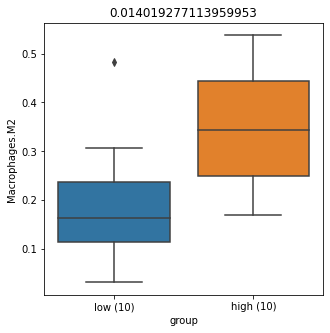

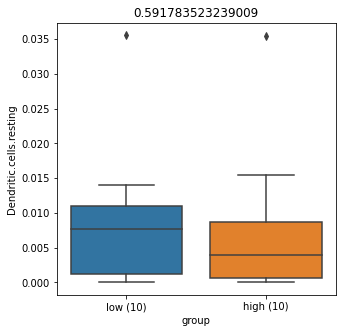

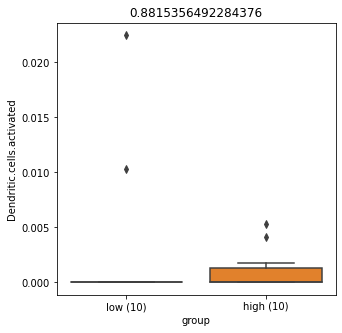

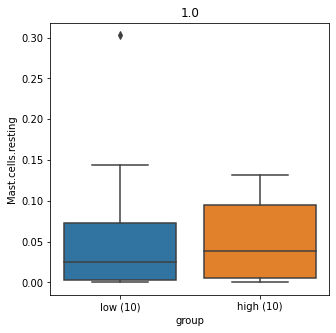

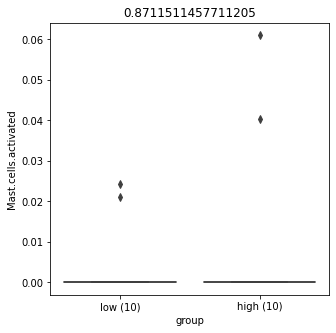

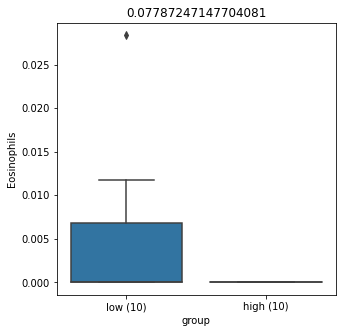

In [142]:
for x in tcga_group1_prs.columns[2:-2]:
    f=plt.figure(figsize=(5,5))
    
    pheno=x #define phenotype
    tcga_group1_prs_cancer=tcga_group1_prs[tcga_group1_prs["cancer"]=="SKCM"]
    tcga_group1_prs_cancer=tcga_group1_prs_cancer[~tcga_group1_prs_cancer[x].isnull()]
    
    tcga_group1_prs_cancer["group"]=np.where(tcga_group1_prs_cancer["PRS"]>tcga_group1_prs_cancer["PRS"].quantile(0.9),"high","medium")
    tcga_group1_prs_cancer["group"]=np.where(tcga_group1_prs_cancer["PRS"]<tcga_group1_prs_cancer["PRS"].quantile(0.1),"low",tcga_group1_prs_cancer["group"])

    ax=sns.boxplot(x="group",y=pheno,data=tcga_group1_prs_cancer,order=["low","high"])
    
    labels=[item.get_text() for item in ax.get_xticklabels()]
    labels=[x+" ("+str(len(tcga_group1_prs_cancer[tcga_group1_prs_cancer["group"]==x]))+")" for x in labels]
    ax.set_xticklabels(labels)
    
    cat1 = tcga_group1_prs_cancer[(tcga_group1_prs_cancer["group"]=="low")]
    cat2 = tcga_group1_prs_cancer[(tcga_group1_prs_cancer["group"]=="high")]
    plt.title(str(mannwhitneyu(cat1[pheno], cat2[pheno])[1]))
    plt.savefig("../plots/fig5/melanoma.PRS."+x+".pdf")

In [148]:
mac_plot=pd.melt(tcga_group1_prs_cancer,id_vars=["IID","group"],value_vars=["Macrophages.M1","Macrophages.M2","Macrophages.M0"])

In [152]:
mac_plot=mac_plot[mac_plot["group"].isin(["low","high"])]

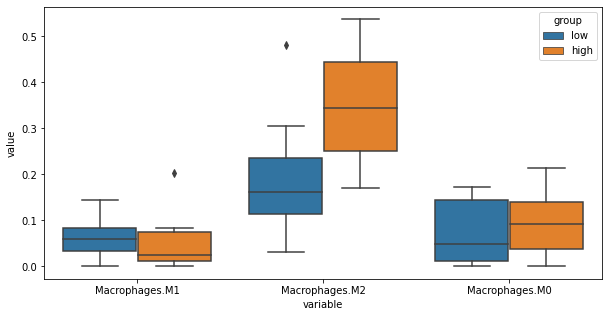

In [157]:
f=plt.figure(figsize=(10,5))
sns.boxplot(x="variable",hue="group",y="value",data=mac_plot)
plt.savefig("mac.pdf")

In [158]:
tcga_group1_prs_cancer["group"].value_counts()

medium    72
low       10
high      10
Name: group, dtype: int64

In [143]:
tcga_prostate_prs=make_ukbb_prs("../data/genotypes/all.time.raw",prostate_sumstats,prostate_sumstats["ID"].tolist())
tcga_prostate_prs=pd.merge(tcga_prostate_prss,sayaman_sig,on="IID",how="left")
tcga_prostate_prs["cancer"]=tcga_prostate_prs["IID"].map(mp)

11 PRS snps
loading 11 snps
['6:32651641:G:T_T', '6:31239896:T:C_C', '6:29921773:C:T_T', '5:96004344:C:T_T', '6:32634243:G:A_A', '6:31321578:G:A_A', '1:150658287:A:G_G', '6:29909372:G:C_C', '6:29910358:G:C_C', '6:32659609:T:C_C', '6:31783507:G:C_C']
0 snps missing weight
switching 9 genotypes


NameError: name 'tcga_prostate_prss' is not defined

In [ ]:
for x in tcga_group1_prs.columns[2:-2]:
    f=plt.figure(figsize=(5,5))
    
    pheno=x #define phenotype
    tcga_group1_prs_cancer=tcga_group1_prs[tcga_group1_prs["cancer"]=="SKCM"]
    tcga_group1_prs_cancer=tcga_group1_prs_cancer[~tcga_group1_prs_cancer[x].isnull()]
    
    tcga_group1_prs_cancer["group"]=np.where(tcga_group1_prs_cancer["PRS"]>tcga_group1_prs_cancer["PRS"].quantile(0.9),"high","medium")
    tcga_group1_prs_cancer["group"]=np.where(tcga_group1_prs_cancer["PRS"]<tcga_group1_prs_cancer["PRS"].quantile(0.1),"low",tcga_group1_prs_cancer["group"])

    sns.boxplot(x="group",y=pheno,data=tcga_group1_prs_cancer,order=["low","high"])
    cat1 = tcga_group1_prs_cancer[(tcga_group1_prs_cancer["group"]=="low")]
    cat2 = tcga_group1_prs_cancer[(tcga_group1_prs_cancer["group"]=="high")]
    plt.title(str(mannwhitneyu(cat1[pheno], cat2[pheno])[1]))

In [ ]:
prostate_sumstats../plots/

In [85]:
tcga_prostate_prs=pd.merge(tcga_prostate_prs,ciber_lm22,on="IID",how="left")

In [86]:
tcga_prostate_prs["cancer"]=tcga_prostate_prs["IID"].map(mp)

<ipython-input-87-6fb649da4005>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tcga_prostate_prs_cancer["group"]=np.where(tcga_prostate_prs_cancer["PRS"]>tcga_prostate_prs_cancer["PRS"].quantile(0.9),"high","medium")
<ipython-input-87-6fb649da4005>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tcga_prostate_prs_cancer["group"]=np.where(tcga_prostate_prs_cancer["PRS"]<tcga_prostate_prs_cancer["PRS"].quantile(0.1),"low",tcga_prostate_prs_cancer["group"])
<ipython-input-87-6fb649da4005>:7: SettingWithCopy

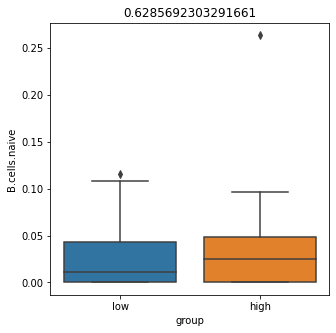

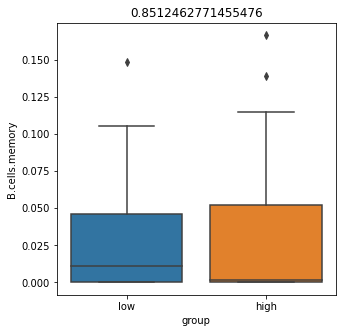

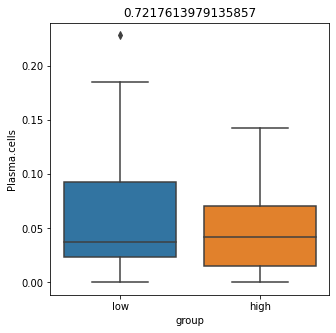

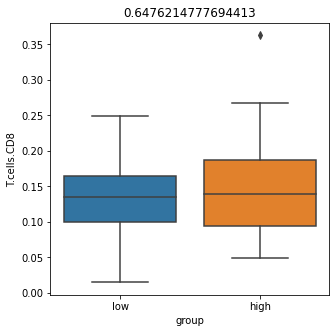

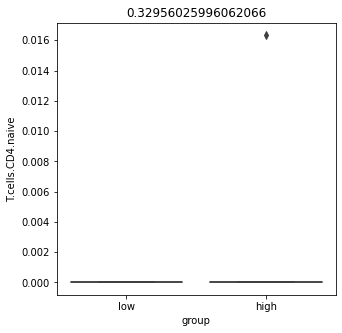

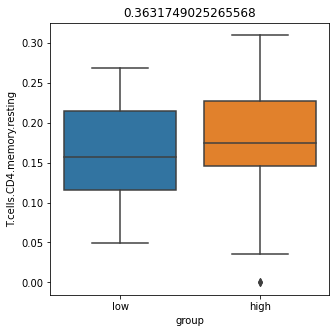

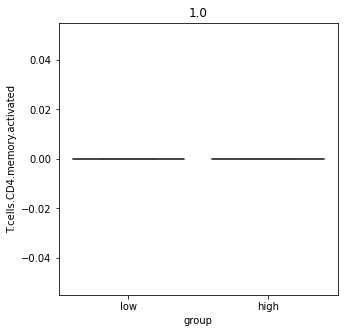

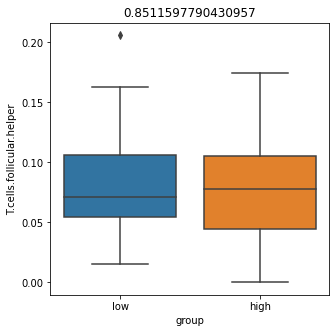

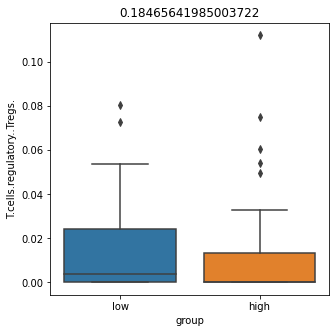

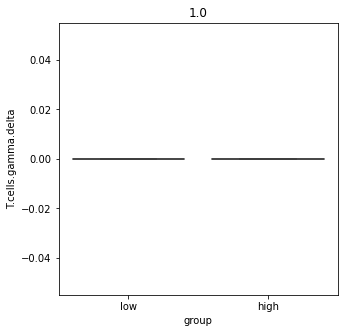

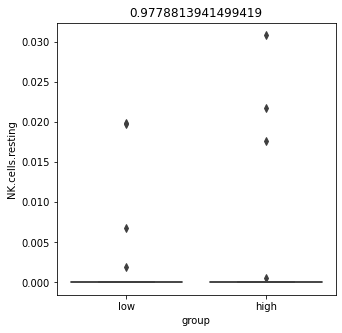

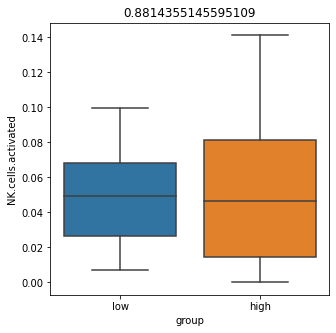

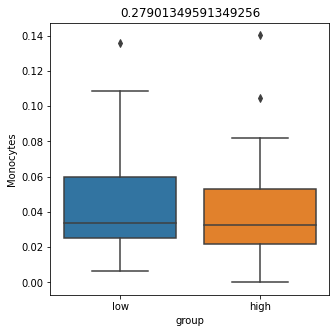

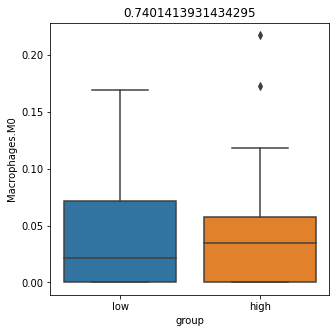

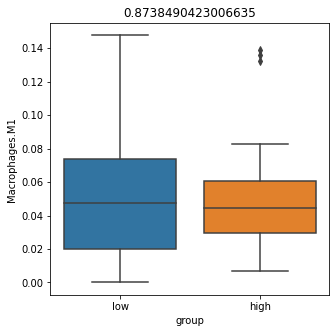

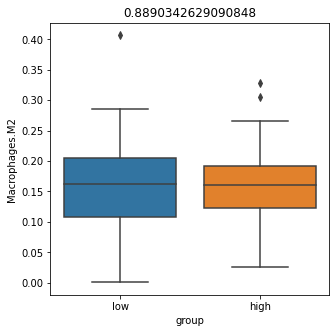

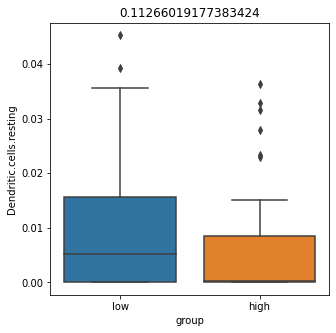

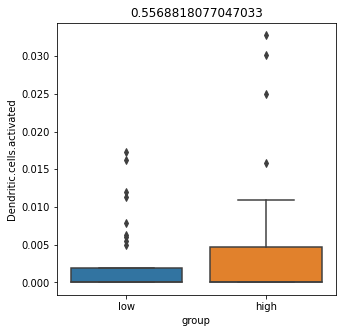

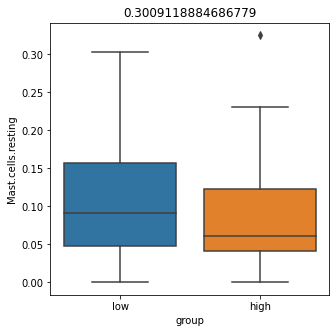

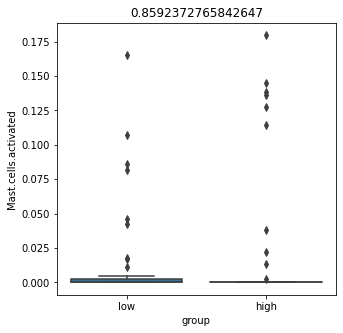

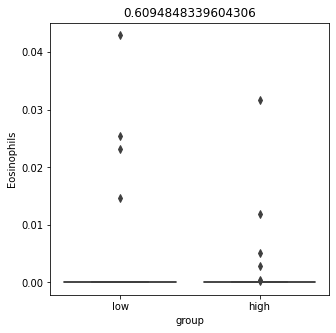

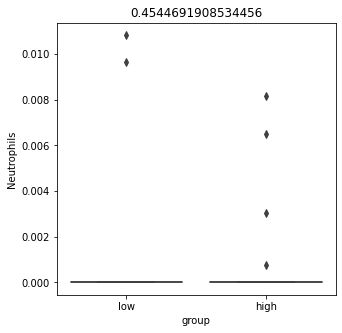

In [87]:
for x in tcga_prostate_prs.columns[2:-1]:
    try:
        f=plt.figure(figsize=(5,5))
        pheno=x
        tcga_prostate_prs_cancer=tcga_prostate_prs[tcga_prostate_prs["cancer"]=="PRAD"]
        
        tcga_prostate_prs_cancer["group"]=np.where(tcga_prostate_prs_cancer["PRS"]>tcga_prostate_prs_cancer["PRS"].quantile(0.9),"high","medium")
        tcga_prostate_prs_cancer["group"]=np.where(tcga_prostate_prs_cancer["PRS"]<tcga_prostate_prs_cancer["PRS"].quantile(0.1),"low",tcga_prostate_prs_cancer["group"])

        sns.boxplot(x="group",y=pheno,data=tcga_prostate_prs_cancer,order=["low","high"])
        cat1 = tcga_prostate_prs_cancer[(tcga_prostate_prs_cancer["group"]=="low")]
        cat2 = tcga_prostate_prs_cancer[(tcga_prostate_prs_cancer["group"]=="high")]
        plt.title(str(mannwhitneyu(cat1[pheno], cat2[pheno])[1]))
    except:
        print(x)

### Get genes in tumor inflammation signature

In [161]:
def calculate_sig(rna,genes,norm):
    '''
    calculate weighted quantile normalized score
    '''
    rna=rna.rename(columns={"Unnamed: 0":"FID"})
    rna_sig=rna[["FID"]+genes].set_index("FID")
    
    if norm:
        rna_sig_quantile=qnorm.quantile_normalize(rna_sig)
        rna_sig_quantile_norm_log=np.log10(rna_sig_quantile)
        rna_sig_quantile_norm_log["signature_score"]=rna_sig_quantile_norm_log.mean(axis=1)
        return(rna_sig_quantile_norm_log)
    else:
        rna_sig["signature_score"]=rna_sig.mean(axis=1)
        return(rna_sig)


In [149]:
IFNg=["IDO1","CXCL10","CXCL9","HLA-DRA","STAT1","IFNG"]
expanded_tis=["CD3D","IDO1","CIITA","CD3E","CCL5","GZMK","CD2","HLA-DRA","CXCL13","IL2RG","NKG7","HLA-E","CXCR6","LAG3","TAGAP","CXCL10","STAT1","GZMB"]

In [146]:
pancan=pd.read_csv("/cellar/users/mpagadal/data/tcga/rna/tpm/compiled/pancanatlas/all.tumor.rna.tsv",delimiter="\t")

In [171]:
tcga_ifng=calculate_sig(pancan,IFNg,True)

In [172]:
tcga_group1_prs=make_ukbb_prs("../data/genotypes/all.time.raw",group1_mhcII_sumstats,group1_mhcII_sumstats["ID"].tolist())
tcga_group1_prs=pd.merge(tcga_group1_prs,tcga_ifng.reset_index().rename(columns={"FID":"IID"}),on="IID",how="left")

52 PRS snps
loading 52 snps
['5:96374150:A:G_G', '5:96374150:A:G_G', '1:151119769:T:A_A', '5:96200770:T:A_A', '1:150597890:A:G_G', '6:32438298:A:G_G', '6:32606941:C:T_T', '6:32605295:C:T_T', '5:96230122:T:G_G', '6:32592605:T:A_A', '1:150861859:C:T_T', '5:96115721:T:C_C', '1:150130096:G:A_A', '6:32581973:G:A_A', '6:32614080:C:T_T', '5:96069295:G:A_A', '5:96069295:G:A_A', '5:96373750:A:G_G', '5:96152436:G:C_C', '5:96152436:G:C_C', '6:32658935:A:G_G', '6:32580657:T:C_C', '6:32580657:T:C_C', '11:65493807:T:C_C', '1:150467096:T:A_A', '1:150658287:A:G_G', '6:32636351:T:C_C', '1:150958977:T:C_C', '1:150635066:C:T_T', '6:32395036:T:C_C', '6:32660784:G:C_C', '11:65394322:A:G_G', '6:32796793:G:A_A', '6:32636866:T:A_A', '5:96229272:G:A_A', '5:96229272:G:A_A', '11:65712413:A:G_G', '1:150878649:C:T_T', '1:150737220:A:G_G', '5:96293021:G:A_A', '6:32610059:G:T_T', '11:65580638:T:G_G', '1:150618632:C:A_A', '6:32586908:A:G_G', '6:32634405:T:C_C', '6:32692735:T:A_A', '6:32575658:G:C_C', '6:32683121:A:G_

In [173]:
tcga_group1_prs["cancer"]=tcga_group1_prs["IID"].map(mp)

Text(0.5, 1.0, '0.3846730627355087')

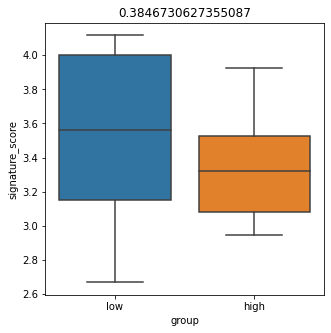

In [175]:
f=plt.figure(figsize=(5,5))
    
pheno="signature_score" #define phenotype
tcga_group1_prs_cancer=tcga_group1_prs[tcga_group1_prs["cancer"]=="SKCM"]
tcga_group1_prs_cancer=tcga_group1_prs_cancer[~tcga_group1_prs_cancer[pheno].isnull()]
    
tcga_group1_prs_cancer["group"]=np.where(tcga_group1_prs_cancer["PRS"]>tcga_group1_prs_cancer["PRS"].quantile(0.9),"high","medium")
tcga_group1_prs_cancer["group"]=np.where(tcga_group1_prs_cancer["PRS"]<tcga_group1_prs_cancer["PRS"].quantile(0.1),"low",tcga_group1_prs_cancer["group"])

sns.boxplot(x="group",y=pheno,data=tcga_group1_prs_cancer,order=["low","high"])
cat1 = tcga_group1_prs_cancer[(tcga_group1_prs_cancer["group"]=="low")]
cat2 = tcga_group1_prs_cancer[(tcga_group1_prs_cancer["group"]=="high")]
plt.title(str(mannwhitneyu(cat1[pheno], cat2[pheno])[1]))

Text(0.5, 1.0, '0.8136256134756809')

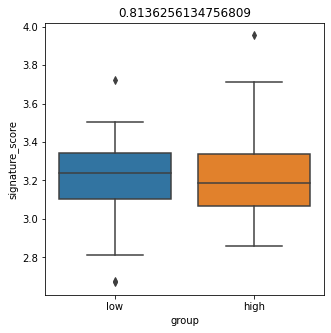

In [176]:
f=plt.figure(figsize=(5,5))
    
pheno="signature_score" #define phenotype
tcga_group1_prs_cancer=tcga_group1_prs[tcga_group1_prs["cancer"]=="PRAD"]
tcga_group1_prs_cancer=tcga_group1_prs_cancer[~tcga_group1_prs_cancer[pheno].isnull()]
    
tcga_group1_prs_cancer["group"]=np.where(tcga_group1_prs_cancer["PRS"]>tcga_group1_prs_cancer["PRS"].quantile(0.9),"high","medium")
tcga_group1_prs_cancer["group"]=np.where(tcga_group1_prs_cancer["PRS"]<tcga_group1_prs_cancer["PRS"].quantile(0.1),"low",tcga_group1_prs_cancer["group"])

sns.boxplot(x="group",y=pheno,data=tcga_group1_prs_cancer,order=["low","high"])
cat1 = tcga_group1_prs_cancer[(tcga_group1_prs_cancer["group"]=="low")]
cat2 = tcga_group1_prs_cancer[(tcga_group1_prs_cancer["group"]=="high")]
plt.title(str(mannwhitneyu(cat1[pheno], cat2[pheno])[1]))

In [177]:
tcga_ifng_expand=calculate_sig(pancan,expanded_tis,True)

In [178]:
tcga_group1_prs=make_ukbb_prs("../data/genotypes/all.time.raw",group1_mhcII_sumstats,group1_mhcII_sumstats["ID"].tolist())
tcga_group1_prs=pd.merge(tcga_group1_prs,tcga_ifng_expand.reset_index().rename(columns={"FID":"IID"}),on="IID",how="left")

52 PRS snps
loading 52 snps
['5:96374150:A:G_G', '5:96374150:A:G_G', '1:151119769:T:A_A', '5:96200770:T:A_A', '1:150597890:A:G_G', '6:32438298:A:G_G', '6:32606941:C:T_T', '6:32605295:C:T_T', '5:96230122:T:G_G', '6:32592605:T:A_A', '1:150861859:C:T_T', '5:96115721:T:C_C', '1:150130096:G:A_A', '6:32581973:G:A_A', '6:32614080:C:T_T', '5:96069295:G:A_A', '5:96069295:G:A_A', '5:96373750:A:G_G', '5:96152436:G:C_C', '5:96152436:G:C_C', '6:32658935:A:G_G', '6:32580657:T:C_C', '6:32580657:T:C_C', '11:65493807:T:C_C', '1:150467096:T:A_A', '1:150658287:A:G_G', '6:32636351:T:C_C', '1:150958977:T:C_C', '1:150635066:C:T_T', '6:32395036:T:C_C', '6:32660784:G:C_C', '11:65394322:A:G_G', '6:32796793:G:A_A', '6:32636866:T:A_A', '5:96229272:G:A_A', '5:96229272:G:A_A', '11:65712413:A:G_G', '1:150878649:C:T_T', '1:150737220:A:G_G', '5:96293021:G:A_A', '6:32610059:G:T_T', '11:65580638:T:G_G', '1:150618632:C:A_A', '6:32586908:A:G_G', '6:32634405:T:C_C', '6:32692735:T:A_A', '6:32575658:G:C_C', '6:32683121:A:G_

In [179]:
tcga_group1_prs["cancer"]=tcga_group1_prs["IID"].map(mp)

Text(0.5, 1.0, '0.21229383619233155')

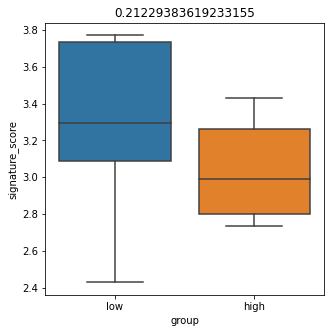

In [180]:
f=plt.figure(figsize=(5,5))
    
pheno="signature_score" #define phenotype
tcga_group1_prs_cancer=tcga_group1_prs[tcga_group1_prs["cancer"]=="SKCM"]
tcga_group1_prs_cancer=tcga_group1_prs_cancer[~tcga_group1_prs_cancer[pheno].isnull()]
    
tcga_group1_prs_cancer["group"]=np.where(tcga_group1_prs_cancer["PRS"]>tcga_group1_prs_cancer["PRS"].quantile(0.9),"high","medium")
tcga_group1_prs_cancer["group"]=np.where(tcga_group1_prs_cancer["PRS"]<tcga_group1_prs_cancer["PRS"].quantile(0.1),"low",tcga_group1_prs_cancer["group"])

sns.boxplot(x="group",y=pheno,data=tcga_group1_prs_cancer,order=["low","high"])
cat1 = tcga_group1_prs_cancer[(tcga_group1_prs_cancer["group"]=="low")]
cat2 = tcga_group1_prs_cancer[(tcga_group1_prs_cancer["group"]=="high")]
plt.title(str(mannwhitneyu(cat1[pheno], cat2[pheno])[1]))

Text(0.5, 1.0, '0.30094021724345754')

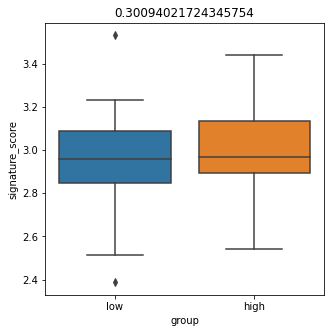

In [181]:
f=plt.figure(figsize=(5,5))
    
pheno="signature_score" #define phenotype
tcga_group1_prs_cancer=tcga_group1_prs[tcga_group1_prs["cancer"]=="PRAD"]
tcga_group1_prs_cancer=tcga_group1_prs_cancer[~tcga_group1_prs_cancer[pheno].isnull()]
    
tcga_group1_prs_cancer["group"]=np.where(tcga_group1_prs_cancer["PRS"]>tcga_group1_prs_cancer["PRS"].quantile(0.9),"high","medium")
tcga_group1_prs_cancer["group"]=np.where(tcga_group1_prs_cancer["PRS"]<tcga_group1_prs_cancer["PRS"].quantile(0.1),"low",tcga_group1_prs_cancer["group"])

sns.boxplot(x="group",y=pheno,data=tcga_group1_prs_cancer,order=["low","high"])
cat1 = tcga_group1_prs_cancer[(tcga_group1_prs_cancer["group"]=="low")]
cat2 = tcga_group1_prs_cancer[(tcga_group1_prs_cancer["group"]=="high")]
plt.title(str(mannwhitneyu(cat1[pheno], cat2[pheno])[1]))

### Run analysis with CRP

In [247]:
tcga_prostate_prs=make_ukbb_prs("../data/genotypes/all.time.raw",prostate_sumstats,prostate_sumstats["ID"].tolist())

pancan_crp=pancan[["Unnamed: 0","CRP"]]
pancan_crp.columns=["IID","CRP"]
pancan_crp["CRP"]=np.log2(pancan_crp["CRP"])

tcga_prostate_prs=pd.merge(tcga_prostate_prs,pancan_crp,on="IID",how="left")
tcga_prostate_prs["cancer"]=tcga_prostate_prs["IID"].map(mp)

11 PRS snps
loading 11 snps
['6:32651641:G:T_T', '6:31239896:T:C_C', '6:29921773:C:T_T', '5:96004344:C:T_T', '6:32634243:G:A_A', '6:31321578:G:A_A', '1:150658287:A:G_G', '6:29909372:G:C_C', '6:29910358:G:C_C', '6:32659609:T:C_C', '6:31783507:G:C_C']
0 snps missing weight
switching 9 genotypes


/cellar/users/mpagadal/Programs/miniconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/cellar/users/mpagadal/Programs/miniconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
<ipython-input-247-5f7fb2ee3071>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pancan_crp["CRP"]=np.log2(pancan_crp["CRP"])


/cellar/users/mpagadal/Programs/miniconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:4009: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/cellar/users/mpagadal/Programs/miniconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:4011: RuntimeWarning: invalid value encountered in add
  lerp_interpolation = asanyarray(add(a, diff_b_a*t, out=out))
/cellar/users/mpagadal/Programs/miniconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:4009: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


Text(0.5, 1.0, '0.873972167418482')

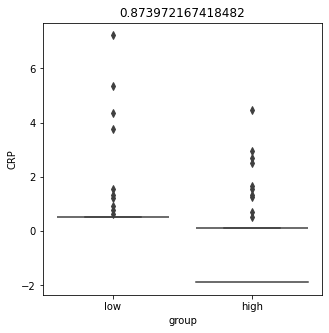

In [248]:
f=plt.figure(figsize=(5,5))
    
pheno="CRP" #define phenotype
tcga_prostate_prs_cancer=tcga_prostate_prs[tcga_prostate_prs["cancer"]=="PRAD"]
tcga_prostate_prs_cancer=tcga_prostate_prs_cancer[~tcga_prostate_prs_cancer[pheno].isnull()]
    
tcga_prostate_prs_cancer["group"]=np.where(tcga_prostate_prs_cancer["PRS"]>tcga_prostate_prs_cancer["PRS"].quantile(0.9),"high","medium")
tcga_prostate_prs_cancer["group"]=np.where(tcga_prostate_prs_cancer["PRS"]<tcga_prostate_prs_cancer["PRS"].quantile(0.1),"low",tcga_prostate_prs_cancer["group"])

sns.boxplot(x="group",y=pheno,data=tcga_prostate_prs_cancer,order=["low","high"])
cat1 = tcga_prostate_prs_cancer[(tcga_prostate_prs_cancer["group"]=="low")]
cat2 = tcga_prostate_prs_cancer[(tcga_prostate_prs_cancer["group"]=="high")]
plt.title(str(mannwhitneyu(cat1[pheno], cat2[pheno])[1]))

In [249]:
tcga_prostate_prs=make_ukbb_prs("../data/genotypes/all.time.raw",prostate_sumstats,prostate_sumstats["ID"].tolist())

pancan_crp=pancan[["Unnamed: 0","PTX3"]]
pancan_crp.columns=["IID","PTX3"]
pancan_crp["PTX3"]=np.log2(pancan_crp["PTX3"])

tcga_prostate_prs=pd.merge(tcga_prostate_prs,pancan_crp,on="IID",how="left")
tcga_prostate_prs["cancer"]=tcga_prostate_prs["IID"].map(mp)

11 PRS snps
loading 11 snps
['6:32651641:G:T_T', '6:31239896:T:C_C', '6:29921773:C:T_T', '5:96004344:C:T_T', '6:32634243:G:A_A', '6:31321578:G:A_A', '1:150658287:A:G_G', '6:29909372:G:C_C', '6:29910358:G:C_C', '6:32659609:T:C_C', '6:31783507:G:C_C']
0 snps missing weight
switching 9 genotypes


/cellar/users/mpagadal/Programs/miniconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/cellar/users/mpagadal/Programs/miniconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
<ipython-input-249-62328e689de1>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pancan_crp["PTX3"]=np.log2(pancan_crp["PTX3"])


Text(0.5, 1.0, '0.892836539135391')

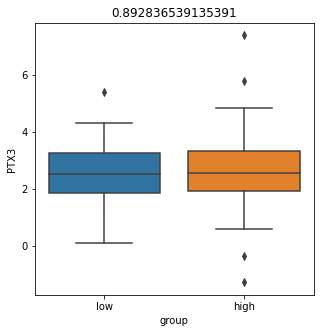

In [250]:
f=plt.figure(figsize=(5,5))
    
pheno="PTX3" #define phenotype
tcga_prostate_prs_cancer=tcga_prostate_prs[tcga_prostate_prs["cancer"]=="PRAD"]
tcga_prostate_prs_cancer=tcga_prostate_prs_cancer[~tcga_prostate_prs_cancer[pheno].isnull()]
    
tcga_prostate_prs_cancer["group"]=np.where(tcga_prostate_prs_cancer["PRS"]>tcga_prostate_prs_cancer["PRS"].quantile(0.9),"high","medium")
tcga_prostate_prs_cancer["group"]=np.where(tcga_prostate_prs_cancer["PRS"]<tcga_prostate_prs_cancer["PRS"].quantile(0.1),"low",tcga_prostate_prs_cancer["group"])

sns.boxplot(x="group",y=pheno,data=tcga_prostate_prs_cancer,order=["low","high"])
cat1 = tcga_prostate_prs_cancer[(tcga_prostate_prs_cancer["group"]=="low")]
cat2 = tcga_prostate_prs_cancer[(tcga_prostate_prs_cancer["group"]=="high")]
plt.title(str(mannwhitneyu(cat1[pheno], cat2[pheno])[1]))

In [277]:
tcga_prostate_prs=make_ukbb_prs("../data/genotypes/all.time.raw",prostate_sumstats,prostate_sumstats["ID"].tolist())

pancan_crp=pancan[["Unnamed: 0","IL6"]]
pancan_crp.columns=["IID","IL6"]
pancan_crp["IL6"]=np.log2(pancan_crp["IL6"])

tcga_prostate_prs=pd.merge(tcga_prostate_prs,pancan_crp,on="IID",how="left")
tcga_prostate_prs["cancer"]=tcga_prostate_prs["IID"].map(mp)

11 PRS snps
loading 11 snps
['6:32651641:G:T_T', '6:31239896:T:C_C', '6:29921773:C:T_T', '5:96004344:C:T_T', '6:32634243:G:A_A', '6:31321578:G:A_A', '1:150658287:A:G_G', '6:29909372:G:C_C', '6:29910358:G:C_C', '6:32659609:T:C_C', '6:31783507:G:C_C']
0 snps missing weight
switching 9 genotypes


/cellar/users/mpagadal/Programs/miniconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/cellar/users/mpagadal/Programs/miniconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
<ipython-input-277-146b852943c2>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pancan_crp["IL6"]=np.log2(pancan_crp["IL6"])


Text(0.5, 1.0, '0.4418026418026417')

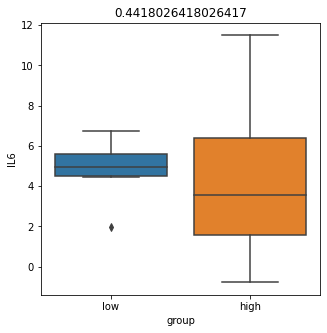

In [279]:
f=plt.figure(figsize=(5,5))
    
pheno="IL6" #define phenotype
tcga_prostate_prs_cancer=tcga_prostate_prs[tcga_prostate_prs["cancer"]=="PRAD"]
tcga_prostate_prs_cancer=tcga_prostate_prs_cancer[tcga_prostate_prs_cancer["IID"].isin(tcga_prog)]
tcga_prostate_prs_cancer=tcga_prostate_prs_cancer[~tcga_prostate_prs_cancer[pheno].isnull()]
    
tcga_prostate_prs_cancer["group"]=np.where(tcga_prostate_prs_cancer["PRS"]>tcga_prostate_prs_cancer["PRS"].quantile(0.9),"high","medium")
tcga_prostate_prs_cancer["group"]=np.where(tcga_prostate_prs_cancer["PRS"]<tcga_prostate_prs_cancer["PRS"].quantile(0.1),"low",tcga_prostate_prs_cancer["group"])

sns.boxplot(x="group",y=pheno,data=tcga_prostate_prs_cancer,order=["low","high"])
cat1 = tcga_prostate_prs_cancer[(tcga_prostate_prs_cancer["group"]=="low")]
cat2 = tcga_prostate_prs_cancer[(tcga_prostate_prs_cancer["group"]=="high")]
plt.title(str(mannwhitneyu(cat1[pheno], cat2[pheno])[1]))

In [253]:
surv=pd.read_csv("/cellar/users/mpagadal/resources/from-labmembers/andrea/Liu2018.TCGA_survival.csv")

In [256]:
surv=surv[surv["type"]=="PRAD"]

In [276]:
surv["PFI"].value_counts()

0.0    407
1.0     93
Name: PFI, dtype: int64

In [278]:
tcga_prog=surv[surv["PFI"]==1]["bcr_patient_barcode"].tolist()

In [268]:
tcga_prostate_prs[tcga_prostate_prs["IID"].isin(tcga_prog)]

,IID,PRS,IL6,cancer
255,TCGA-2A-A8W3,0.851126,4.294834,PRAD
3777,TCGA-CH-5743,1.392034,7.298328,PRAD
3783,TCGA-CH-5751,1.050582,5.822577,PRAD
3800,TCGA-CH-5791,0.097829,1.996099,PRAD
5451,TCGA-EJ-5518,1.536673,6.357723,PRAD
...,...,...,...,...
8091,TCGA-YL-A9WX,0.650720,8.098848,PRAD
8092,TCGA-YL-A9WY,1.407586,3.540002,PRAD
8159,TCGA-ZG-A9L2,1.305223,7.057873,PRAD
8162,TCGA-ZG-A9L6,0.650130,5.392187,PRAD
